In [1]:
import pandas as pd
import numpy as np 
from collections import defaultdict
from pandas.plotting import table
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.metrics import mean_squared_error,mean_absolute_error
import math
from sklearn import linear_model

# Import Data

In [2]:
movies = pd.read_csv( 'movies.csv')
ratings = pd.read_csv('ratings.csv')
 
combine_movie_rating= pd.merge(ratings,movies,on='movieId',how='inner')
combine_movie_rating=combine_movie_rating.drop(['timestamp'],axis = 1)
combine_movie_rating = combine_movie_rating.dropna(axis = 0 ,subset=['title'])
print('count：%d' % len(combine_movie_rating))
combine_movie_rating.sample(10)

count：100836


,userId,movieId,rating,title,genres
32835,599,546,2.0,Super Mario Bros. (1993),Action|Adventure|Children|Comedy|Fantasy|Sci-Fi
44835,82,3717,4.0,Gone in 60 Seconds (2000),Action|Crime
87664,95,3690,2.0,Porky's Revenge (1985),Comedy
53586,606,5995,4.5,"Pianist, The (2002)",Drama|War
9046,391,1282,5.0,Fantasia (1940),Animation|Children|Fantasy|Musical
37979,131,7153,3.5,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy
39006,159,30812,2.0,"Aviator, The (2004)",Drama
12429,220,2502,5.0,Office Space (1999),Comedy|Crime
30667,380,313,3.0,"Swan Princess, The (1994)",Animation|Children
54730,105,38061,3.0,Kiss Kiss Bang Bang (2005),Comedy|Crime|Mystery|Thriller


In [3]:
combine_movie_rating['rating'] = combine_movie_rating['rating']/5

# Data preprocessing 

In [4]:
ratings_pivot2 = combine_movie_rating.pivot(index='userId', columns='movieId',values='rating').fillna(0)
ratings_pivot2_sparse = csr_matrix(ratings_pivot2.values)
print(ratings_pivot2.shape)
ratings_pivot2.head()

(610, 9724)


movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,0.8,0.0,0.8,0.0,0.0,0.8,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
X = ratings_pivot2.values
X

array([[0.8, 0. , 0.8, ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0.5, 0.4, 0.4, ..., 0. , 0. , 0. ],
       [0.6, 0. , 0. , ..., 0. , 0. , 0. ],
       [1. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [6]:
rating = pd.DataFrame(X)
np.random.seed(44)
N = len(rating)
shuffled_indices = np.random.permutation(N)
train_indices = shuffled_indices[:int(N*0.7)]
test_indices = shuffled_indices[int(N*0.7):]
train_user = rating._stat_axis.values[train_indices]
train_set = rating.values[train_indices]
test_user = rating._stat_axis.values[test_indices]
test_set = rating.values[test_indices]

In [7]:
test_user.shape

(183,)

In [8]:
moive_id_all = ratings_pivot2.columns.values.tolist()
moive_id_all[-1]

193609

In [9]:
svd_data = combine_movie_rating[['userId', 'movieId', 'rating']]
svd_data

,userId,movieId,rating
0,1,1,0.8
1,5,1,0.8
2,7,1,0.9
3,15,1,0.5
4,17,1,0.9
...,...,...,...
100831,610,160341,0.5
100832,610,160527,0.9
100833,610,160836,0.6
100834,610,163937,0.7


In [10]:
X_df = pd.DataFrame(X)
X_df 

,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
0,0.8,0.0,0.8,0.0,0.0,0.8,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
606,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,0.5,0.4,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
test_set_df = pd.DataFrame(test_set)

In [12]:
train_set_df = pd.DataFrame(train_set)

In [13]:
svd_test_set = []
for i in range(0, test_set_df.shape[0]):
    for j in range(0,test_set_df.shape[1]):
        if test_set[i][j] != 0:
            col = []
            col.append(test_user[i])
            col.append(moive_id_all[j])
            col.append(test_set[i][j])
            svd_test_set.append(col)
svd_test_set

[[385, 6, 0.6],
 [385, 10, 0.6],
 [385, 16, 0.8],
 [385, 20, 0.4],
 [385, 21, 0.8],
 [385, 22, 0.6],
 [385, 25, 0.4],
 [385, 32, 0.6],
 [385, 34, 0.8],
 [385, 39, 0.6],
 [385, 44, 0.4],
 [385, 45, 0.6],
 [385, 47, 0.6],
 [385, 50, 0.6],
 [385, 110, 0.6],
 [385, 112, 0.8],
 [385, 153, 0.4],
 [385, 160, 0.6],
 [385, 161, 0.6],
 [385, 163, 0.8],
 [385, 165, 0.4],
 [385, 172, 0.4],
 [385, 173, 0.4],
 [385, 185, 0.2],
 [385, 196, 0.4],
 [385, 198, 0.4],
 [385, 204, 0.2],
 [385, 208, 0.4],
 [385, 223, 0.6],
 [385, 288, 0.2],
 [385, 292, 0.2],
 [385, 293, 0.6],
 [385, 296, 1.0],
 [385, 300, 0.6],
 [385, 303, 0.8],
 [385, 305, 0.6],
 [385, 316, 0.6],
 [385, 318, 0.6],
 [385, 319, 0.6],
 [385, 329, 0.6],
 [385, 333, 0.6],
 [385, 349, 0.4],
 [385, 367, 0.2],
 [385, 377, 0.6],
 [385, 380, 0.6],
 [385, 383, 0.8],
 [385, 410, 0.6],
 [385, 434, 0.4],
 [385, 442, 0.6],
 [385, 457, 0.6],
 [385, 474, 0.6],
 [385, 477, 0.6],
 [385, 480, 0.4],
 [385, 485, 0.4],
 [385, 494, 0.4],
 [385, 532, 0.8],
 [385, 

In [14]:
svd_train_set = []
for i in range(0, train_set_df.shape[0] ):
    for j in range(0,train_set_df.shape[1]):
        if train_set[i][j] != 0:
            col = []
            col.append(train_user[i])
            col.append(moive_id_all[j])
            col.append(train_set[i][j])
            svd_train_set.append(col)
svd_train_set

[[195, 62, 0.9],
 [195, 104, 0.7],
 [195, 110, 0.7],
 [195, 150, 1.0],
 [195, 364, 1.0],
 [195, 457, 0.7],
 [195, 733, 1.0],
 [195, 1036, 0.9],
 [195, 1214, 0.9],
 [195, 1259, 0.6],
 [195, 1527, 0.6],
 [195, 1552, 0.8],
 [195, 2028, 0.6],
 [195, 2571, 1.0],
 [195, 2762, 0.6],
 [195, 3578, 1.0],
 [195, 4963, 0.7],
 [195, 5418, 0.8],
 [195, 5952, 0.6],
 [195, 5995, 0.6],
 [195, 6378, 0.9],
 [195, 41569, 0.4],
 [195, 44665, 0.8],
 [195, 47099, 0.8],
 [195, 51935, 0.9],
 [195, 58559, 1.0],
 [195, 59315, 0.9],
 [195, 68954, 0.8],
 [195, 70286, 0.4],
 [195, 109487, 0.7],
 [195, 134130, 0.9],
 [195, 142488, 1.0],
 [478, 24, 0.6],
 [478, 31, 0.6],
 [478, 45, 0.6],
 [478, 82, 1.0],
 [478, 110, 0.4],
 [478, 135, 0.2],
 [478, 185, 0.2],
 [478, 186, 0.6],
 [478, 242, 0.8],
 [478, 247, 0.6],
 [478, 260, 0.8],
 [478, 341, 0.8],
 [478, 346, 0.8],
 [478, 351, 0.4],
 [478, 412, 0.8],
 [478, 435, 0.6],
 [478, 454, 0.8],
 [478, 515, 0.8],
 [478, 524, 1.0],
 [478, 533, 0.4],
 [478, 562, 0.6],
 [478, 587, 

# The rating list of user 385

In [15]:
user_385_movie = []
for j in range(0,63):
    user_385_movie.append(svd_test_set[j][1])


In [16]:
user385_rating = []
for i in range(0,len(svd_test_set)):
    
    if svd_test_set[i][0] == 385:
        user385_rating.append(svd_test_set[i])
    else:
        continue
user385_rating_df = pd.DataFrame(user385_rating, columns = ["userId","movieId","rating"])

In [17]:
user385_movie_rating= pd.merge(user385_rating_df,movies,on='movieId',how='inner')
user385_movie_rating.sort_values(by="rating",axis=0,ascending=False,inplace=True)
pd.set_option('display.max_rows', None)
user385_movie_rating

,userId,movieId,rating,title,genres
32,385,296,1.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
34,385,303,0.8,"Quick and the Dead, The (1995)",Action|Thriller|Western
8,385,34,0.8,Babe (1995),Children|Drama
15,385,112,0.8,Rumble in the Bronx (Hont faan kui) (1995),Action|Adventure|Comedy|Crime
55,385,532,0.8,Serial Mom (1994),Comedy|Crime|Horror
45,385,383,0.8,Wyatt Earp (1994),Western
61,385,593,0.8,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
19,385,163,0.8,Desperado (1995),Action|Romance|Western
62,385,608,0.8,Fargo (1996),Comedy|Crime|Drama|Thriller
4,385,21,0.8,Get Shorty (1995),Comedy|Crime|Thriller


In [18]:
from scipy import stats
user385_ratings_evaluation = user385_movie_rating['rating'].values
mean = np.mean(user385_ratings_evaluation)
median = np.median(user385_ratings_evaluation)
mode = stats.mode(user385_ratings_evaluation)[0][0]
print("mean: "+str(mean))
print("median: "+str(median))
print("mode: "+str(mode))

mean: 0.5500000000000002
median: 0.6
mode: 0.6


C:\Users\www\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


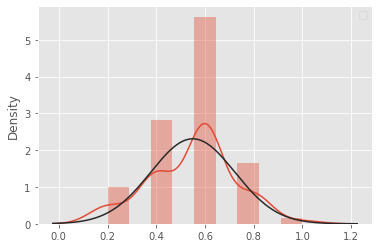

In [19]:
import seaborn as sns
plt.style.use('ggplot')
sns.distplot(user385_ratings_evaluation,hist=True,kde=True,fit=stats.norm)
plt.legend()
plt.show()

In [20]:
import dataframe_image as dfi
dfi.export(user385_movie_rating, 'user385_movie.png')

# Here, I implemented four CF algorithms: RBM, SVD, user-based and item-based

# RBM

This algorithm refers to the implementation method shared by the author echen https://github.com/echen/restricted-boltzmann-machines/blob/master/rbm.py on github.
I also refers to Chaoyang Zhang's implementation of this algorithm.
I rewrite the implementation method through my understanding.
I also modified some places, such as the initialization weights, in order to make it easier for me to understand.

In [21]:

class RBM(object):
    def __init__(self, num_visible, num_hidden, learn_rate=0.1, learn_batch=1000):
        self.num_visible = num_visible  # Number of visual units
        self.num_hidden = num_hidden  # Number of hidden units
        self.learn_rate = learn_rate  # learning rate
        self.learn_batch = learn_batch  # learning batch

        '''Initialize connection weight'''
        #This is modified
        # Randomly generate weights based on 0.1 times the standard normal distribution
        self.weights = 0.1 * \
                       np.random.randn(self.num_visible,
                                       self.num_hidden)  
        # Insert all 0s in the first line, that is, the weights of the bias and hidden layers are initialized to 0
        self.weights = np.insert(self.weights, 0, 0, axis=0)
        # Insert all 0s in the first column, that is, the weights of the bias and visual layers are initialized to 0
        self.weights = np.insert(self.weights, 0, 0, axis=1)

    #This function is modified, since algorithm will be more stable
    def _logistic(self, x):
        return 0.5 * (1 + np.tanh(0.5 * x))

    def train(self, rating_data, max_steps=1000):
        '''
        Iterative training to get the connection weight
        '''
        for step in range(max_steps):  
            error = 0.0  
            # Adjust the weights every time taking a batch of samples
            for i in range(0, rating_data.shape[0], self.learn_batch):
                num_examples = min(self.learn_batch, rating_data.shape[0] - i)
                data = rating_data[i:i + num_examples, :]
                # Insert all 1s in the first column, that is, the offset value is initialized to 1
                data = np.insert(data, 0, 1, axis=1)  

                pos_hidden_activations = np.dot(data, self.weights)
                pos_hidden_probs = self._logistic(pos_hidden_activations)
                pos_hidden_states = pos_hidden_probs > np.random.rand(num_examples, self.num_hidden + 1)
                # pos_associations=np.dot(data.T,pos_hidden_states)        
                pos_associations = np.dot(data.T, pos_hidden_probs) 

                neg_visible_activations = np.dot(
                    pos_hidden_states, self.weights.T)
                neg_visible_probs = self._logistic(neg_visible_activations)
                neg_visible_probs[:, 0] = 1  # Forcibly reset the offset value to 1
                neg_hidden_activations = np.dot(neg_visible_probs, self.weights)
                neg_hidden_probs = self._logistic(neg_hidden_activations)
                # neg_hidden_states=neg_hidden_probs>np.random.rand(num_examples,self.num_hidden+1)
                # neg_associations=np.dot(neg_visible_probs.T,neg_hidden_states)    
                neg_associations = np.dot(neg_visible_probs.T, neg_hidden_probs)  

                # Update weight
                self.weights += self.learn_rate * \
                                (pos_associations - neg_associations) / num_examples

                # calculate RMSE
                error += np.sum((data - neg_visible_probs) ** 2)

            print('iteration %d, rmse is %f' % (step, np.sqrt(error/(data.shape[0]*data.shape[1]))))

    def getHidden(self, visible_data):
        '''
        Get the hidden layer according to the input layer
        '''
        num_examples = visible_data.shape[0]
        hidden_states = np.ones((num_examples, self.num_hidden + 1))
        # Insert the offset of the first column
        visible_data = np.insert(visible_data, 0, 1, axis=1)  
        hidden_activations = np.dot(visible_data, self.weights)
        hidden_probs = self._logistic(hidden_activations)
        hidden_states[:, :] = hidden_probs > np.random.rand(
            num_examples, self.num_hidden + 1)
        #Delete the first column, that is, remove the offset
        hidden_states = hidden_states[:, 1:] 
        return hidden_states

    def getVisible(self, hidden_data):
        '''
        Get the input layer according to the hidden layer
        '''
        num_examples = hidden_data.shape[0]
        visible_states = np.ones((num_examples, self.num_visible + 1))
        hidden_data = np.insert(hidden_data, 0, 1, axis=1)
        visible_activations = np.dot(hidden_data, self.weights.T)
        visible_probs = self._logistic(visible_activations)
        visible_states[:, :] = visible_probs > np.random.rand(
            num_examples, self.num_visible + 1)
        visible_states = visible_states[:, 1:]
        return visible_states
    #This function is modified, since I just wnat to know the prediction of RMB. The author's implement 
    #is not necessaryfor me.
    def predict(self, visible_data):
        num_examples = visible_data.shape[0]
        hidden_states = np.ones((num_examples, self.num_hidden + 1))
        # Insert the offset of the first column
        visible_data = np.insert(visible_data, 0, 1, axis=1)
        '''forward'''
        hidden_activations = np.dot(visible_data, self.weights)
        hidden_probs = self._logistic(hidden_activations)
        # hidden_states[:, :] = hidden_probs > np.random.rand(
        #     num_examples, self.num_hidden + 1)
        '''backward'''
        visible_states = np.ones((num_examples, self.num_visible + 1))
        # visible_activations = np.dot(hidden_states, self.weights.T)  
        visible_activations = np.dot(hidden_probs, self.weights.T)  
        visible_probs = self._logistic(visible_activations)
        #Delete the first column, that is, remove the offset
        return visible_probs[:, 1:] 

In [22]:
rbm = RBM(num_visible=9724, num_hidden=30, learn_rate=0.08, learn_batch=30)
rbm.train(np.array(train_set), max_steps=10000)
print('weight:\n', rbm.weights)
hidden_data = rbm.getHidden(np.array(test_set))
print('hidden_data:\n', hidden_data)
visible_data = rbm.getVisible(hidden_data)
print('visible_data:\n', visible_data)
predict_data = rbm.predict(test_set)
predict_data

iteration 0, rmse is 3.520014
iteration 1, rmse is 3.119145
iteration 2, rmse is 2.628841
iteration 3, rmse is 2.045736
iteration 4, rmse is 1.606201
iteration 5, rmse is 1.328871
iteration 6, rmse is 1.212836
iteration 7, rmse is 1.202486
iteration 8, rmse is 1.309125
iteration 9, rmse is 1.383632
iteration 10, rmse is 1.456800
iteration 11, rmse is 1.495907
iteration 12, rmse is 1.547346
iteration 13, rmse is 1.595017
iteration 14, rmse is 1.661005
iteration 15, rmse is 1.716488
iteration 16, rmse is 1.758951
iteration 17, rmse is 1.791321
iteration 18, rmse is 1.785881
iteration 19, rmse is 1.795576
iteration 20, rmse is 1.810434
iteration 21, rmse is 1.824881
iteration 22, rmse is 1.826621
iteration 23, rmse is 1.818985
iteration 24, rmse is 1.797301
iteration 25, rmse is 1.785164
iteration 26, rmse is 1.746317
iteration 27, rmse is 1.722693
iteration 28, rmse is 1.668130
iteration 29, rmse is 1.591610
iteration 30, rmse is 1.508969
iteration 31, rmse is 1.431416
iteration 32, rmse

iteration 260, rmse is 0.835331
iteration 261, rmse is 0.835157
iteration 262, rmse is 0.834495
iteration 263, rmse is 0.834389
iteration 264, rmse is 0.833837
iteration 265, rmse is 0.833475
iteration 266, rmse is 0.833487
iteration 267, rmse is 0.833145
iteration 268, rmse is 0.832513
iteration 269, rmse is 0.832268
iteration 270, rmse is 0.832100
iteration 271, rmse is 0.831746
iteration 272, rmse is 0.831186
iteration 273, rmse is 0.830854
iteration 274, rmse is 0.830412
iteration 275, rmse is 0.830222
iteration 276, rmse is 0.829833
iteration 277, rmse is 0.829270
iteration 278, rmse is 0.829060
iteration 279, rmse is 0.828841
iteration 280, rmse is 0.828501
iteration 281, rmse is 0.828288
iteration 282, rmse is 0.827915
iteration 283, rmse is 0.827619
iteration 284, rmse is 0.827348
iteration 285, rmse is 0.827072
iteration 286, rmse is 0.826797
iteration 287, rmse is 0.826584
iteration 288, rmse is 0.826245
iteration 289, rmse is 0.825997
iteration 290, rmse is 0.825745
iteratio

iteration 517, rmse is 0.790482
iteration 518, rmse is 0.790340
iteration 519, rmse is 0.783909
iteration 520, rmse is 0.790322
iteration 521, rmse is 0.783909
iteration 522, rmse is 0.790111
iteration 523, rmse is 0.790003
iteration 524, rmse is 0.783757
iteration 525, rmse is 0.783617
iteration 526, rmse is 0.783702
iteration 527, rmse is 0.783531
iteration 528, rmse is 0.783591
iteration 529, rmse is 0.783454
iteration 530, rmse is 0.783297
iteration 531, rmse is 0.783272
iteration 532, rmse is 0.783092
iteration 533, rmse is 0.783334
iteration 534, rmse is 0.783252
iteration 535, rmse is 0.782944
iteration 536, rmse is 0.782958
iteration 537, rmse is 0.782895
iteration 538, rmse is 0.782887
iteration 539, rmse is 0.782719
iteration 540, rmse is 0.782683
iteration 541, rmse is 0.782658
iteration 542, rmse is 0.782512
iteration 543, rmse is 0.782600
iteration 544, rmse is 0.782520
iteration 545, rmse is 0.782340
iteration 546, rmse is 0.782255
iteration 547, rmse is 0.782173
iteratio

iteration 774, rmse is 0.761712
iteration 775, rmse is 0.761476
iteration 776, rmse is 0.761444
iteration 777, rmse is 0.761342
iteration 778, rmse is 0.761259
iteration 779, rmse is 0.761094
iteration 780, rmse is 0.761091
iteration 781, rmse is 0.761121
iteration 782, rmse is 0.760900
iteration 783, rmse is 0.761008
iteration 784, rmse is 0.760830
iteration 785, rmse is 0.760808
iteration 786, rmse is 0.760732
iteration 787, rmse is 0.760613
iteration 788, rmse is 0.760645
iteration 789, rmse is 0.760485
iteration 790, rmse is 0.760364
iteration 791, rmse is 0.760814
iteration 792, rmse is 0.760511
iteration 793, rmse is 0.760444
iteration 794, rmse is 0.760483
iteration 795, rmse is 0.760389
iteration 796, rmse is 0.760443
iteration 797, rmse is 0.760047
iteration 798, rmse is 0.760176
iteration 799, rmse is 0.759864
iteration 800, rmse is 0.759770
iteration 801, rmse is 0.759929
iteration 802, rmse is 0.759855
iteration 803, rmse is 0.759873
iteration 804, rmse is 0.759679
iteratio

iteration 1030, rmse is 0.733614
iteration 1031, rmse is 0.733507
iteration 1032, rmse is 0.733437
iteration 1033, rmse is 0.733574
iteration 1034, rmse is 0.733323
iteration 1035, rmse is 0.733152
iteration 1036, rmse is 0.733266
iteration 1037, rmse is 0.733097
iteration 1038, rmse is 0.733096
iteration 1039, rmse is 0.732826
iteration 1040, rmse is 0.732723
iteration 1041, rmse is 0.732906
iteration 1042, rmse is 0.732911
iteration 1043, rmse is 0.732750
iteration 1044, rmse is 0.732514
iteration 1045, rmse is 0.732854
iteration 1046, rmse is 0.732287
iteration 1047, rmse is 0.732417
iteration 1048, rmse is 0.732262
iteration 1049, rmse is 0.732172
iteration 1050, rmse is 0.732170
iteration 1051, rmse is 0.731937
iteration 1052, rmse is 0.732183
iteration 1053, rmse is 0.726284
iteration 1054, rmse is 0.726612
iteration 1055, rmse is 0.731856
iteration 1056, rmse is 0.726366
iteration 1057, rmse is 0.726329
iteration 1058, rmse is 0.726045
iteration 1059, rmse is 0.726191
iteration 

iteration 1279, rmse is 0.712375
iteration 1280, rmse is 0.712156
iteration 1281, rmse is 0.712514
iteration 1282, rmse is 0.712173
iteration 1283, rmse is 0.712138
iteration 1284, rmse is 0.712049
iteration 1285, rmse is 0.712259
iteration 1286, rmse is 0.712116
iteration 1287, rmse is 0.711844
iteration 1288, rmse is 0.711614
iteration 1289, rmse is 0.711649
iteration 1290, rmse is 0.711756
iteration 1291, rmse is 0.711527
iteration 1292, rmse is 0.711548
iteration 1293, rmse is 0.711447
iteration 1294, rmse is 0.711408
iteration 1295, rmse is 0.711337
iteration 1296, rmse is 0.711178
iteration 1297, rmse is 0.711105
iteration 1298, rmse is 0.710933
iteration 1299, rmse is 0.710892
iteration 1300, rmse is 0.710883
iteration 1301, rmse is 0.710714
iteration 1302, rmse is 0.710706
iteration 1303, rmse is 0.710589
iteration 1304, rmse is 0.710487
iteration 1305, rmse is 0.710364
iteration 1306, rmse is 0.710331
iteration 1307, rmse is 0.710342
iteration 1308, rmse is 0.710181
iteration 

iteration 1528, rmse is 0.695712
iteration 1529, rmse is 0.695608
iteration 1530, rmse is 0.695700
iteration 1531, rmse is 0.692924
iteration 1532, rmse is 0.695480
iteration 1533, rmse is 0.695384
iteration 1534, rmse is 0.695579
iteration 1535, rmse is 0.695245
iteration 1536, rmse is 0.695404
iteration 1537, rmse is 0.695053
iteration 1538, rmse is 0.694962
iteration 1539, rmse is 0.694979
iteration 1540, rmse is 0.695163
iteration 1541, rmse is 0.694840
iteration 1542, rmse is 0.694869
iteration 1543, rmse is 0.694673
iteration 1544, rmse is 0.694563
iteration 1545, rmse is 0.694667
iteration 1546, rmse is 0.694491
iteration 1547, rmse is 0.694542
iteration 1548, rmse is 0.694501
iteration 1549, rmse is 0.694347
iteration 1550, rmse is 0.694320
iteration 1551, rmse is 0.694063
iteration 1552, rmse is 0.694047
iteration 1553, rmse is 0.694408
iteration 1554, rmse is 0.694097
iteration 1555, rmse is 0.693998
iteration 1556, rmse is 0.694132
iteration 1557, rmse is 0.693761
iteration 

iteration 1777, rmse is 0.683218
iteration 1778, rmse is 0.682953
iteration 1779, rmse is 0.682983
iteration 1780, rmse is 0.683271
iteration 1781, rmse is 0.682912
iteration 1782, rmse is 0.682692
iteration 1783, rmse is 0.682845
iteration 1784, rmse is 0.682748
iteration 1785, rmse is 0.682906
iteration 1786, rmse is 0.682510
iteration 1787, rmse is 0.683254
iteration 1788, rmse is 0.682868
iteration 1789, rmse is 0.682367
iteration 1790, rmse is 0.682321
iteration 1791, rmse is 0.682271
iteration 1792, rmse is 0.682209
iteration 1793, rmse is 0.682501
iteration 1794, rmse is 0.682578
iteration 1795, rmse is 0.682648
iteration 1796, rmse is 0.682721
iteration 1797, rmse is 0.682415
iteration 1798, rmse is 0.682034
iteration 1799, rmse is 0.682397
iteration 1800, rmse is 0.682205
iteration 1801, rmse is 0.681753
iteration 1802, rmse is 0.682395
iteration 1803, rmse is 0.681744
iteration 1804, rmse is 0.682266
iteration 1805, rmse is 0.681854
iteration 1806, rmse is 0.681531
iteration 

iteration 2026, rmse is 0.672380
iteration 2027, rmse is 0.672600
iteration 2028, rmse is 0.673902
iteration 2029, rmse is 0.672408
iteration 2030, rmse is 0.672221
iteration 2031, rmse is 0.672190
iteration 2032, rmse is 0.672864
iteration 2033, rmse is 0.673590
iteration 2034, rmse is 0.672945
iteration 2035, rmse is 0.672210
iteration 2036, rmse is 0.672823
iteration 2037, rmse is 0.673689
iteration 2038, rmse is 0.672955
iteration 2039, rmse is 0.672434
iteration 2040, rmse is 0.672449
iteration 2041, rmse is 0.673724
iteration 2042, rmse is 0.672535
iteration 2043, rmse is 0.673537
iteration 2044, rmse is 0.672279
iteration 2045, rmse is 0.672915
iteration 2046, rmse is 0.672986
iteration 2047, rmse is 0.672914
iteration 2048, rmse is 0.672238
iteration 2049, rmse is 0.672883
iteration 2050, rmse is 0.672929
iteration 2051, rmse is 0.672353
iteration 2052, rmse is 0.671981
iteration 2053, rmse is 0.672773
iteration 2054, rmse is 0.672802
iteration 2055, rmse is 0.672577
iteration 

iteration 2275, rmse is 0.664304
iteration 2276, rmse is 0.664190
iteration 2277, rmse is 0.664215
iteration 2278, rmse is 0.664389
iteration 2279, rmse is 0.664245
iteration 2280, rmse is 0.664262
iteration 2281, rmse is 0.664240
iteration 2282, rmse is 0.664187
iteration 2283, rmse is 0.664104
iteration 2284, rmse is 0.663996
iteration 2285, rmse is 0.664304
iteration 2286, rmse is 0.663989
iteration 2287, rmse is 0.663896
iteration 2288, rmse is 0.663816
iteration 2289, rmse is 0.663744
iteration 2290, rmse is 0.663700
iteration 2291, rmse is 0.663780
iteration 2292, rmse is 0.663590
iteration 2293, rmse is 0.663710
iteration 2294, rmse is 0.663407
iteration 2295, rmse is 0.663538
iteration 2296, rmse is 0.663285
iteration 2297, rmse is 0.663409
iteration 2298, rmse is 0.663333
iteration 2299, rmse is 0.663212
iteration 2300, rmse is 0.663217
iteration 2301, rmse is 0.662993
iteration 2302, rmse is 0.663077
iteration 2303, rmse is 0.663251
iteration 2304, rmse is 0.662843
iteration 

iteration 2524, rmse is 0.655474
iteration 2525, rmse is 0.654989
iteration 2526, rmse is 0.655925
iteration 2527, rmse is 0.654939
iteration 2528, rmse is 0.655878
iteration 2529, rmse is 0.654464
iteration 2530, rmse is 0.655668
iteration 2531, rmse is 0.654647
iteration 2532, rmse is 0.655486
iteration 2533, rmse is 0.654980
iteration 2534, rmse is 0.655715
iteration 2535, rmse is 0.654619
iteration 2536, rmse is 0.655490
iteration 2537, rmse is 0.655245
iteration 2538, rmse is 0.654522
iteration 2539, rmse is 0.655074
iteration 2540, rmse is 0.655199
iteration 2541, rmse is 0.654029
iteration 2542, rmse is 0.655085
iteration 2543, rmse is 0.653936
iteration 2544, rmse is 0.655020
iteration 2545, rmse is 0.654296
iteration 2546, rmse is 0.655058
iteration 2547, rmse is 0.655366
iteration 2548, rmse is 0.654182
iteration 2549, rmse is 0.653840
iteration 2550, rmse is 0.653752
iteration 2551, rmse is 0.654824
iteration 2552, rmse is 0.654333
iteration 2553, rmse is 0.654537
iteration 

iteration 2773, rmse is 0.644896
iteration 2774, rmse is 0.644958
iteration 2775, rmse is 0.645146
iteration 2776, rmse is 0.644281
iteration 2777, rmse is 0.644728
iteration 2778, rmse is 0.644993
iteration 2779, rmse is 0.644998
iteration 2780, rmse is 0.644735
iteration 2781, rmse is 0.644585
iteration 2782, rmse is 0.644249
iteration 2783, rmse is 0.644426
iteration 2784, rmse is 0.644112
iteration 2785, rmse is 0.644751
iteration 2786, rmse is 0.644242
iteration 2787, rmse is 0.644562
iteration 2788, rmse is 0.644256
iteration 2789, rmse is 0.644139
iteration 2790, rmse is 0.644319
iteration 2791, rmse is 0.644569
iteration 2792, rmse is 0.644082
iteration 2793, rmse is 0.644437
iteration 2794, rmse is 0.644291
iteration 2795, rmse is 0.644293
iteration 2796, rmse is 0.644056
iteration 2797, rmse is 0.644162
iteration 2798, rmse is 0.643855
iteration 2799, rmse is 0.643960
iteration 2800, rmse is 0.643910
iteration 2801, rmse is 0.644209
iteration 2802, rmse is 0.643957
iteration 

iteration 3022, rmse is 0.636497
iteration 3023, rmse is 0.637367
iteration 3024, rmse is 0.636789
iteration 3025, rmse is 0.636515
iteration 3026, rmse is 0.636232
iteration 3027, rmse is 0.636405
iteration 3028, rmse is 0.636544
iteration 3029, rmse is 0.636525
iteration 3030, rmse is 0.636161
iteration 3031, rmse is 0.636361
iteration 3032, rmse is 0.636405
iteration 3033, rmse is 0.636116
iteration 3034, rmse is 0.636019
iteration 3035, rmse is 0.635987
iteration 3036, rmse is 0.636068
iteration 3037, rmse is 0.636897
iteration 3038, rmse is 0.636052
iteration 3039, rmse is 0.636332
iteration 3040, rmse is 0.635959
iteration 3041, rmse is 0.635815
iteration 3042, rmse is 0.635755
iteration 3043, rmse is 0.636214
iteration 3044, rmse is 0.636051
iteration 3045, rmse is 0.636246
iteration 3046, rmse is 0.635698
iteration 3047, rmse is 0.636161
iteration 3048, rmse is 0.635792
iteration 3049, rmse is 0.636343
iteration 3050, rmse is 0.635535
iteration 3051, rmse is 0.636557
iteration 

iteration 3271, rmse is 0.630988
iteration 3272, rmse is 0.630657
iteration 3273, rmse is 0.630385
iteration 3274, rmse is 0.631442
iteration 3275, rmse is 0.630852
iteration 3276, rmse is 0.631001
iteration 3277, rmse is 0.630265
iteration 3278, rmse is 0.630838
iteration 3279, rmse is 0.630722
iteration 3280, rmse is 0.630478
iteration 3281, rmse is 0.630196
iteration 3282, rmse is 0.630377
iteration 3283, rmse is 0.630595
iteration 3284, rmse is 0.630478
iteration 3285, rmse is 0.630264
iteration 3286, rmse is 0.630559
iteration 3287, rmse is 0.630458
iteration 3288, rmse is 0.630282
iteration 3289, rmse is 0.630990
iteration 3290, rmse is 0.630391
iteration 3291, rmse is 0.630965
iteration 3292, rmse is 0.630256
iteration 3293, rmse is 0.630275
iteration 3294, rmse is 0.630539
iteration 3295, rmse is 0.630194
iteration 3296, rmse is 0.630185
iteration 3297, rmse is 0.630770
iteration 3298, rmse is 0.630655
iteration 3299, rmse is 0.631080
iteration 3300, rmse is 0.630255
iteration 

iteration 3520, rmse is 0.625704
iteration 3521, rmse is 0.625338
iteration 3522, rmse is 0.625387
iteration 3523, rmse is 0.625349
iteration 3524, rmse is 0.625243
iteration 3525, rmse is 0.625229
iteration 3526, rmse is 0.625634
iteration 3527, rmse is 0.625272
iteration 3528, rmse is 0.625510
iteration 3529, rmse is 0.625543
iteration 3530, rmse is 0.625127
iteration 3531, rmse is 0.625171
iteration 3532, rmse is 0.625041
iteration 3533, rmse is 0.625755
iteration 3534, rmse is 0.625372
iteration 3535, rmse is 0.624996
iteration 3536, rmse is 0.625342
iteration 3537, rmse is 0.625055
iteration 3538, rmse is 0.625289
iteration 3539, rmse is 0.625261
iteration 3540, rmse is 0.625010
iteration 3541, rmse is 0.624895
iteration 3542, rmse is 0.624933
iteration 3543, rmse is 0.625084
iteration 3544, rmse is 0.625019
iteration 3545, rmse is 0.624880
iteration 3546, rmse is 0.624758
iteration 3547, rmse is 0.624722
iteration 3548, rmse is 0.624686
iteration 3549, rmse is 0.624694
iteration 

iteration 3769, rmse is 0.622058
iteration 3770, rmse is 0.621862
iteration 3771, rmse is 0.621859
iteration 3772, rmse is 0.621873
iteration 3773, rmse is 0.621832
iteration 3774, rmse is 0.621609
iteration 3775, rmse is 0.621742
iteration 3776, rmse is 0.621709
iteration 3777, rmse is 0.621683
iteration 3778, rmse is 0.621907
iteration 3779, rmse is 0.621719
iteration 3780, rmse is 0.621696
iteration 3781, rmse is 0.621670
iteration 3782, rmse is 0.621678
iteration 3783, rmse is 0.621641
iteration 3784, rmse is 0.621566
iteration 3785, rmse is 0.621620
iteration 3786, rmse is 0.621511
iteration 3787, rmse is 0.621709
iteration 3788, rmse is 0.621535
iteration 3789, rmse is 0.621559
iteration 3790, rmse is 0.621491
iteration 3791, rmse is 0.621318
iteration 3792, rmse is 0.621546
iteration 3793, rmse is 0.621514
iteration 3794, rmse is 0.621946
iteration 3795, rmse is 0.621394
iteration 3796, rmse is 0.621418
iteration 3797, rmse is 0.621750
iteration 3798, rmse is 0.621350
iteration 

iteration 4018, rmse is 0.614486
iteration 4019, rmse is 0.614655
iteration 4020, rmse is 0.614392
iteration 4021, rmse is 0.614096
iteration 4022, rmse is 0.614254
iteration 4023, rmse is 0.614225
iteration 4024, rmse is 0.614020
iteration 4025, rmse is 0.613969
iteration 4026, rmse is 0.613949
iteration 4027, rmse is 0.613719
iteration 4028, rmse is 0.614030
iteration 4029, rmse is 0.613762
iteration 4030, rmse is 0.613948
iteration 4031, rmse is 0.613925
iteration 4032, rmse is 0.613566
iteration 4033, rmse is 0.613688
iteration 4034, rmse is 0.613510
iteration 4035, rmse is 0.613310
iteration 4036, rmse is 0.613341
iteration 4037, rmse is 0.613307
iteration 4038, rmse is 0.613470
iteration 4039, rmse is 0.613192
iteration 4040, rmse is 0.613225
iteration 4041, rmse is 0.613360
iteration 4042, rmse is 0.613204
iteration 4043, rmse is 0.613215
iteration 4044, rmse is 0.613139
iteration 4045, rmse is 0.613105
iteration 4046, rmse is 0.612790
iteration 4047, rmse is 0.613054
iteration 

iteration 4267, rmse is 0.605215
iteration 4268, rmse is 0.605384
iteration 4269, rmse is 0.605251
iteration 4270, rmse is 0.605143
iteration 4271, rmse is 0.605379
iteration 4272, rmse is 0.605409
iteration 4273, rmse is 0.605328
iteration 4274, rmse is 0.605121
iteration 4275, rmse is 0.605176
iteration 4276, rmse is 0.605164
iteration 4277, rmse is 0.605278
iteration 4278, rmse is 0.605384
iteration 4279, rmse is 0.604998
iteration 4280, rmse is 0.605001
iteration 4281, rmse is 0.605180
iteration 4282, rmse is 0.604906
iteration 4283, rmse is 0.604999
iteration 4284, rmse is 0.604800
iteration 4285, rmse is 0.604762
iteration 4286, rmse is 0.604971
iteration 4287, rmse is 0.604687
iteration 4288, rmse is 0.604923
iteration 4289, rmse is 0.604661
iteration 4290, rmse is 0.604667
iteration 4291, rmse is 0.604989
iteration 4292, rmse is 0.604761
iteration 4293, rmse is 0.604800
iteration 4294, rmse is 0.604739
iteration 4295, rmse is 0.604612
iteration 4296, rmse is 0.604612
iteration 

iteration 4516, rmse is 0.600046
iteration 4517, rmse is 0.599822
iteration 4518, rmse is 0.599791
iteration 4519, rmse is 0.599967
iteration 4520, rmse is 0.600188
iteration 4521, rmse is 0.599670
iteration 4522, rmse is 0.599876
iteration 4523, rmse is 0.600356
iteration 4524, rmse is 0.599877
iteration 4525, rmse is 0.599837
iteration 4526, rmse is 0.600371
iteration 4527, rmse is 0.599999
iteration 4528, rmse is 0.600109
iteration 4529, rmse is 0.600267
iteration 4530, rmse is 0.599733
iteration 4531, rmse is 0.599779
iteration 4532, rmse is 0.599473
iteration 4533, rmse is 0.599698
iteration 4534, rmse is 0.599861
iteration 4535, rmse is 0.599768
iteration 4536, rmse is 0.599570
iteration 4537, rmse is 0.599918
iteration 4538, rmse is 0.599879
iteration 4539, rmse is 0.599752
iteration 4540, rmse is 0.599884
iteration 4541, rmse is 0.599846
iteration 4542, rmse is 0.599607
iteration 4543, rmse is 0.599251
iteration 4544, rmse is 0.599653
iteration 4545, rmse is 0.599590
iteration 

iteration 4765, rmse is 0.595530
iteration 4766, rmse is 0.595843
iteration 4767, rmse is 0.595674
iteration 4768, rmse is 0.595445
iteration 4769, rmse is 0.595427
iteration 4770, rmse is 0.596154
iteration 4771, rmse is 0.595390
iteration 4772, rmse is 0.595385
iteration 4773, rmse is 0.595953
iteration 4774, rmse is 0.595856
iteration 4775, rmse is 0.595314
iteration 4776, rmse is 0.595813
iteration 4777, rmse is 0.595279
iteration 4778, rmse is 0.595543
iteration 4779, rmse is 0.595250
iteration 4780, rmse is 0.595169
iteration 4781, rmse is 0.595923
iteration 4782, rmse is 0.596060
iteration 4783, rmse is 0.595150
iteration 4784, rmse is 0.595121
iteration 4785, rmse is 0.596009
iteration 4786, rmse is 0.595313
iteration 4787, rmse is 0.595067
iteration 4788, rmse is 0.595014
iteration 4789, rmse is 0.595026
iteration 4790, rmse is 0.595845
iteration 4791, rmse is 0.594999
iteration 4792, rmse is 0.594985
iteration 4793, rmse is 0.595259
iteration 4794, rmse is 0.595453
iteration 

iteration 5014, rmse is 0.592164
iteration 5015, rmse is 0.592157
iteration 5016, rmse is 0.592827
iteration 5017, rmse is 0.593638
iteration 5018, rmse is 0.592448
iteration 5019, rmse is 0.593353
iteration 5020, rmse is 0.592272
iteration 5021, rmse is 0.592036
iteration 5022, rmse is 0.592668
iteration 5023, rmse is 0.591833
iteration 5024, rmse is 0.592606
iteration 5025, rmse is 0.592301
iteration 5026, rmse is 0.592392
iteration 5027, rmse is 0.592180
iteration 5028, rmse is 0.592481
iteration 5029, rmse is 0.592188
iteration 5030, rmse is 0.592678
iteration 5031, rmse is 0.592891
iteration 5032, rmse is 0.592156
iteration 5033, rmse is 0.592463
iteration 5034, rmse is 0.592229
iteration 5035, rmse is 0.592040
iteration 5036, rmse is 0.592010
iteration 5037, rmse is 0.593618
iteration 5038, rmse is 0.592378
iteration 5039, rmse is 0.592270
iteration 5040, rmse is 0.591948
iteration 5041, rmse is 0.591883
iteration 5042, rmse is 0.592205
iteration 5043, rmse is 0.592489
iteration 

iteration 5263, rmse is 0.590844
iteration 5264, rmse is 0.589275
iteration 5265, rmse is 0.589496
iteration 5266, rmse is 0.589902
iteration 5267, rmse is 0.589119
iteration 5268, rmse is 0.589088
iteration 5269, rmse is 0.589489
iteration 5270, rmse is 0.591985
iteration 5271, rmse is 0.589257
iteration 5272, rmse is 0.589187
iteration 5273, rmse is 0.589109
iteration 5274, rmse is 0.589149
iteration 5275, rmse is 0.590351
iteration 5276, rmse is 0.589471
iteration 5277, rmse is 0.588909
iteration 5278, rmse is 0.591910
iteration 5279, rmse is 0.588877
iteration 5280, rmse is 0.589050
iteration 5281, rmse is 0.589484
iteration 5282, rmse is 0.589708
iteration 5283, rmse is 0.592342
iteration 5284, rmse is 0.592367
iteration 5285, rmse is 0.588952
iteration 5286, rmse is 0.589001
iteration 5287, rmse is 0.588909
iteration 5288, rmse is 0.589200
iteration 5289, rmse is 0.589668
iteration 5290, rmse is 0.589439
iteration 5291, rmse is 0.588826
iteration 5292, rmse is 0.589306
iteration 

iteration 5512, rmse is 0.588244
iteration 5513, rmse is 0.588200
iteration 5514, rmse is 0.588263
iteration 5515, rmse is 0.590074
iteration 5516, rmse is 0.588888
iteration 5517, rmse is 0.588150
iteration 5518, rmse is 0.587984
iteration 5519, rmse is 0.587950
iteration 5520, rmse is 0.587920
iteration 5521, rmse is 0.588380
iteration 5522, rmse is 0.589487
iteration 5523, rmse is 0.589413
iteration 5524, rmse is 0.588166
iteration 5525, rmse is 0.589391
iteration 5526, rmse is 0.589512
iteration 5527, rmse is 0.589373
iteration 5528, rmse is 0.589474
iteration 5529, rmse is 0.587908
iteration 5530, rmse is 0.587736
iteration 5531, rmse is 0.587850
iteration 5532, rmse is 0.587703
iteration 5533, rmse is 0.587688
iteration 5534, rmse is 0.587791
iteration 5535, rmse is 0.589319
iteration 5536, rmse is 0.587591
iteration 5537, rmse is 0.587556
iteration 5538, rmse is 0.587563
iteration 5539, rmse is 0.587544
iteration 5540, rmse is 0.587689
iteration 5541, rmse is 0.589070
iteration 

iteration 5761, rmse is 0.584837
iteration 5762, rmse is 0.583383
iteration 5763, rmse is 0.583769
iteration 5764, rmse is 0.586287
iteration 5765, rmse is 0.583283
iteration 5766, rmse is 0.585114
iteration 5767, rmse is 0.583250
iteration 5768, rmse is 0.586155
iteration 5769, rmse is 0.584662
iteration 5770, rmse is 0.586097
iteration 5771, rmse is 0.583199
iteration 5772, rmse is 0.586087
iteration 5773, rmse is 0.584564
iteration 5774, rmse is 0.584571
iteration 5775, rmse is 0.584773
iteration 5776, rmse is 0.586003
iteration 5777, rmse is 0.584517
iteration 5778, rmse is 0.584462
iteration 5779, rmse is 0.584876
iteration 5780, rmse is 0.584413
iteration 5781, rmse is 0.584619
iteration 5782, rmse is 0.584512
iteration 5783, rmse is 0.584365
iteration 5784, rmse is 0.584328
iteration 5785, rmse is 0.584701
iteration 5786, rmse is 0.584280
iteration 5787, rmse is 0.583419
iteration 5788, rmse is 0.584647
iteration 5789, rmse is 0.584229
iteration 5790, rmse is 0.582948
iteration 

iteration 6010, rmse is 0.581948
iteration 6011, rmse is 0.580261
iteration 6012, rmse is 0.580460
iteration 6013, rmse is 0.580739
iteration 6014, rmse is 0.580182
iteration 6015, rmse is 0.580736
iteration 6016, rmse is 0.581650
iteration 6017, rmse is 0.580715
iteration 6018, rmse is 0.580190
iteration 6019, rmse is 0.583388
iteration 6020, rmse is 0.580646
iteration 6021, rmse is 0.582540
iteration 6022, rmse is 0.580159
iteration 6023, rmse is 0.581392
iteration 6024, rmse is 0.581363
iteration 6025, rmse is 0.581373
iteration 6026, rmse is 0.582995
iteration 6027, rmse is 0.580728
iteration 6028, rmse is 0.581748
iteration 6029, rmse is 0.580075
iteration 6030, rmse is 0.580502
iteration 6031, rmse is 0.581314
iteration 6032, rmse is 0.580425
iteration 6033, rmse is 0.580007
iteration 6034, rmse is 0.581615
iteration 6035, rmse is 0.579955
iteration 6036, rmse is 0.581120
iteration 6037, rmse is 0.581497
iteration 6038, rmse is 0.579907
iteration 6039, rmse is 0.582869
iteration 

iteration 6259, rmse is 0.577726
iteration 6260, rmse is 0.579053
iteration 6261, rmse is 0.579048
iteration 6262, rmse is 0.578103
iteration 6263, rmse is 0.578072
iteration 6264, rmse is 0.578032
iteration 6265, rmse is 0.578050
iteration 6266, rmse is 0.578948
iteration 6267, rmse is 0.577985
iteration 6268, rmse is 0.578930
iteration 6269, rmse is 0.578891
iteration 6270, rmse is 0.579422
iteration 6271, rmse is 0.578863
iteration 6272, rmse is 0.578838
iteration 6273, rmse is 0.579451
iteration 6274, rmse is 0.577876
iteration 6275, rmse is 0.577862
iteration 6276, rmse is 0.578765
iteration 6277, rmse is 0.577820
iteration 6278, rmse is 0.578674
iteration 6279, rmse is 0.578708
iteration 6280, rmse is 0.578658
iteration 6281, rmse is 0.578669
iteration 6282, rmse is 0.577727
iteration 6283, rmse is 0.577766
iteration 6284, rmse is 0.578601
iteration 6285, rmse is 0.578590
iteration 6286, rmse is 0.578566
iteration 6287, rmse is 0.578555
iteration 6288, rmse is 0.577616
iteration 

iteration 6508, rmse is 0.576864
iteration 6509, rmse is 0.580377
iteration 6510, rmse is 0.580344
iteration 6511, rmse is 0.576804
iteration 6512, rmse is 0.580282
iteration 6513, rmse is 0.580264
iteration 6514, rmse is 0.580220
iteration 6515, rmse is 0.580180
iteration 6516, rmse is 0.580350
iteration 6517, rmse is 0.580106
iteration 6518, rmse is 0.580071
iteration 6519, rmse is 0.580014
iteration 6520, rmse is 0.580354
iteration 6521, rmse is 0.579967
iteration 6522, rmse is 0.579932
iteration 6523, rmse is 0.579896
iteration 6524, rmse is 0.579855
iteration 6525, rmse is 0.576479
iteration 6526, rmse is 0.579832
iteration 6527, rmse is 0.579767
iteration 6528, rmse is 0.579741
iteration 6529, rmse is 0.579711
iteration 6530, rmse is 0.580116
iteration 6531, rmse is 0.579646
iteration 6532, rmse is 0.579598
iteration 6533, rmse is 0.576355
iteration 6534, rmse is 0.579576
iteration 6535, rmse is 0.579531
iteration 6536, rmse is 0.579485
iteration 6537, rmse is 0.579846
iteration 

iteration 6757, rmse is 0.574789
iteration 6758, rmse is 0.574775
iteration 6759, rmse is 0.574744
iteration 6760, rmse is 0.574724
iteration 6761, rmse is 0.574699
iteration 6762, rmse is 0.574646
iteration 6763, rmse is 0.574638
iteration 6764, rmse is 0.574624
iteration 6765, rmse is 0.574569
iteration 6766, rmse is 0.574575
iteration 6767, rmse is 0.574536
iteration 6768, rmse is 0.575155
iteration 6769, rmse is 0.574490
iteration 6770, rmse is 0.574501
iteration 6771, rmse is 0.574440
iteration 6772, rmse is 0.574427
iteration 6773, rmse is 0.574380
iteration 6774, rmse is 0.574370
iteration 6775, rmse is 0.574333
iteration 6776, rmse is 0.574320
iteration 6777, rmse is 0.574267
iteration 6778, rmse is 0.574282
iteration 6779, rmse is 0.574246
iteration 6780, rmse is 0.574214
iteration 6781, rmse is 0.574186
iteration 6782, rmse is 0.574155
iteration 6783, rmse is 0.574234
iteration 6784, rmse is 0.574108
iteration 6785, rmse is 0.574090
iteration 6786, rmse is 0.574070
iteration 

iteration 7006, rmse is 0.570371
iteration 7007, rmse is 0.570152
iteration 7008, rmse is 0.570336
iteration 7009, rmse is 0.570303
iteration 7010, rmse is 0.570324
iteration 7011, rmse is 0.570266
iteration 7012, rmse is 0.570224
iteration 7013, rmse is 0.570212
iteration 7014, rmse is 0.570215
iteration 7015, rmse is 0.569962
iteration 7016, rmse is 0.570146
iteration 7017, rmse is 0.570441
iteration 7018, rmse is 0.570143
iteration 7019, rmse is 0.570119
iteration 7020, rmse is 0.570075
iteration 7021, rmse is 0.570051
iteration 7022, rmse is 0.570038
iteration 7023, rmse is 0.570009
iteration 7024, rmse is 0.569985
iteration 7025, rmse is 0.569976
iteration 7026, rmse is 0.569953
iteration 7027, rmse is 0.569928
iteration 7028, rmse is 0.569918
iteration 7029, rmse is 0.569894
iteration 7030, rmse is 0.569887
iteration 7031, rmse is 0.570255
iteration 7032, rmse is 0.569833
iteration 7033, rmse is 0.569806
iteration 7034, rmse is 0.569787
iteration 7035, rmse is 0.569765
iteration 

iteration 7255, rmse is 0.567292
iteration 7256, rmse is 0.567073
iteration 7257, rmse is 0.567044
iteration 7258, rmse is 0.567033
iteration 7259, rmse is 0.567007
iteration 7260, rmse is 0.567000
iteration 7261, rmse is 0.567376
iteration 7262, rmse is 0.567364
iteration 7263, rmse is 0.566954
iteration 7264, rmse is 0.567320
iteration 7265, rmse is 0.566880
iteration 7266, rmse is 0.566880
iteration 7267, rmse is 0.566879
iteration 7268, rmse is 0.566834
iteration 7269, rmse is 0.566888
iteration 7270, rmse is 0.567021
iteration 7271, rmse is 0.566796
iteration 7272, rmse is 0.566786
iteration 7273, rmse is 0.566767
iteration 7274, rmse is 0.566755
iteration 7275, rmse is 0.566733
iteration 7276, rmse is 0.566713
iteration 7277, rmse is 0.566699
iteration 7278, rmse is 0.566666
iteration 7279, rmse is 0.566629
iteration 7280, rmse is 0.566655
iteration 7281, rmse is 0.567043
iteration 7282, rmse is 0.566615
iteration 7283, rmse is 0.566601
iteration 7284, rmse is 0.566997
iteration 

iteration 7504, rmse is 0.564154
iteration 7505, rmse is 0.563742
iteration 7506, rmse is 0.563745
iteration 7507, rmse is 0.563740
iteration 7508, rmse is 0.564555
iteration 7509, rmse is 0.564047
iteration 7510, rmse is 0.564041
iteration 7511, rmse is 0.564039
iteration 7512, rmse is 0.564035
iteration 7513, rmse is 0.563679
iteration 7514, rmse is 0.563663
iteration 7515, rmse is 0.564460
iteration 7516, rmse is 0.563639
iteration 7517, rmse is 0.563610
iteration 7518, rmse is 0.563946
iteration 7519, rmse is 0.563947
iteration 7520, rmse is 0.563589
iteration 7521, rmse is 0.563591
iteration 7522, rmse is 0.563565
iteration 7523, rmse is 0.564378
iteration 7524, rmse is 0.563886
iteration 7525, rmse is 0.564015
iteration 7526, rmse is 0.563858
iteration 7527, rmse is 0.563845
iteration 7528, rmse is 0.563840
iteration 7529, rmse is 0.563821
iteration 7530, rmse is 0.563805
iteration 7531, rmse is 0.563792
iteration 7532, rmse is 0.564276
iteration 7533, rmse is 0.563893
iteration 

iteration 7753, rmse is 0.561865
iteration 7754, rmse is 0.563397
iteration 7755, rmse is 0.563394
iteration 7756, rmse is 0.563705
iteration 7757, rmse is 0.563068
iteration 7758, rmse is 0.563339
iteration 7759, rmse is 0.563642
iteration 7760, rmse is 0.563332
iteration 7761, rmse is 0.563302
iteration 7762, rmse is 0.563285
iteration 7763, rmse is 0.563005
iteration 7764, rmse is 0.563589
iteration 7765, rmse is 0.563258
iteration 7766, rmse is 0.563242
iteration 7767, rmse is 0.563221
iteration 7768, rmse is 0.563212
iteration 7769, rmse is 0.563207
iteration 7770, rmse is 0.563198
iteration 7771, rmse is 0.563202
iteration 7772, rmse is 0.563153
iteration 7773, rmse is 0.563143
iteration 7774, rmse is 0.563134
iteration 7775, rmse is 0.563119
iteration 7776, rmse is 0.562829
iteration 7777, rmse is 0.563059
iteration 7778, rmse is 0.563067
iteration 7779, rmse is 0.563349
iteration 7780, rmse is 0.563054
iteration 7781, rmse is 0.563040
iteration 7782, rmse is 0.562778
iteration 

iteration 8002, rmse is 0.560976
iteration 8003, rmse is 0.560976
iteration 8004, rmse is 0.561000
iteration 8005, rmse is 0.560970
iteration 8006, rmse is 0.561491
iteration 8007, rmse is 0.560945
iteration 8008, rmse is 0.560930
iteration 8009, rmse is 0.560927
iteration 8010, rmse is 0.561457
iteration 8011, rmse is 0.561478
iteration 8012, rmse is 0.560894
iteration 8013, rmse is 0.561009
iteration 8014, rmse is 0.561444
iteration 8015, rmse is 0.561496
iteration 8016, rmse is 0.561432
iteration 8017, rmse is 0.560850
iteration 8018, rmse is 0.560830
iteration 8019, rmse is 0.561400
iteration 8020, rmse is 0.561361
iteration 8021, rmse is 0.561297
iteration 8022, rmse is 0.560822
iteration 8023, rmse is 0.560836
iteration 8024, rmse is 0.561296
iteration 8025, rmse is 0.561303
iteration 8026, rmse is 0.561323
iteration 8027, rmse is 0.561293
iteration 8028, rmse is 0.560753
iteration 8029, rmse is 0.560714
iteration 8030, rmse is 0.560692
iteration 8031, rmse is 0.560785
iteration 

iteration 8251, rmse is 0.559193
iteration 8252, rmse is 0.559049
iteration 8253, rmse is 0.559170
iteration 8254, rmse is 0.559008
iteration 8255, rmse is 0.559204
iteration 8256, rmse is 0.559002
iteration 8257, rmse is 0.559141
iteration 8258, rmse is 0.559178
iteration 8259, rmse is 0.559346
iteration 8260, rmse is 0.559000
iteration 8261, rmse is 0.558952
iteration 8262, rmse is 0.559151
iteration 8263, rmse is 0.559097
iteration 8264, rmse is 0.559049
iteration 8265, rmse is 0.559129
iteration 8266, rmse is 0.559077
iteration 8267, rmse is 0.559023
iteration 8268, rmse is 0.558908
iteration 8269, rmse is 0.558903
iteration 8270, rmse is 0.559037
iteration 8271, rmse is 0.559023
iteration 8272, rmse is 0.559118
iteration 8273, rmse is 0.558849
iteration 8274, rmse is 0.558954
iteration 8275, rmse is 0.559012
iteration 8276, rmse is 0.558943
iteration 8277, rmse is 0.558803
iteration 8278, rmse is 0.558901
iteration 8279, rmse is 0.558795
iteration 8280, rmse is 0.558975
iteration 

iteration 8500, rmse is 0.559066
iteration 8501, rmse is 0.559069
iteration 8502, rmse is 0.559026
iteration 8503, rmse is 0.559430
iteration 8504, rmse is 0.559031
iteration 8505, rmse is 0.559005
iteration 8506, rmse is 0.558975
iteration 8507, rmse is 0.558988
iteration 8508, rmse is 0.558976
iteration 8509, rmse is 0.558963
iteration 8510, rmse is 0.558949
iteration 8511, rmse is 0.558940
iteration 8512, rmse is 0.558944
iteration 8513, rmse is 0.558914
iteration 8514, rmse is 0.559030
iteration 8515, rmse is 0.558904
iteration 8516, rmse is 0.559044
iteration 8517, rmse is 0.558871
iteration 8518, rmse is 0.558884
iteration 8519, rmse is 0.559032
iteration 8520, rmse is 0.558866
iteration 8521, rmse is 0.558810
iteration 8522, rmse is 0.558825
iteration 8523, rmse is 0.558833
iteration 8524, rmse is 0.558839
iteration 8525, rmse is 0.558864
iteration 8526, rmse is 0.558939
iteration 8527, rmse is 0.558799
iteration 8528, rmse is 0.558965
iteration 8529, rmse is 0.558764
iteration 

iteration 8749, rmse is 0.557492
iteration 8750, rmse is 0.557091
iteration 8751, rmse is 0.557064
iteration 8752, rmse is 0.557107
iteration 8753, rmse is 0.557107
iteration 8754, rmse is 0.557038
iteration 8755, rmse is 0.557057
iteration 8756, rmse is 0.557047
iteration 8757, rmse is 0.557041
iteration 8758, rmse is 0.557029
iteration 8759, rmse is 0.557042
iteration 8760, rmse is 0.557042
iteration 8761, rmse is 0.556983
iteration 8762, rmse is 0.556991
iteration 8763, rmse is 0.557161
iteration 8764, rmse is 0.556998
iteration 8765, rmse is 0.557157
iteration 8766, rmse is 0.556973
iteration 8767, rmse is 0.556991
iteration 8768, rmse is 0.556972
iteration 8769, rmse is 0.557003
iteration 8770, rmse is 0.557009
iteration 8771, rmse is 0.556941
iteration 8772, rmse is 0.557214
iteration 8773, rmse is 0.556915
iteration 8774, rmse is 0.556907
iteration 8775, rmse is 0.556898
iteration 8776, rmse is 0.556895
iteration 8777, rmse is 0.556904
iteration 8778, rmse is 0.556884
iteration 

iteration 8998, rmse is 0.555721
iteration 8999, rmse is 0.555729
iteration 9000, rmse is 0.555726
iteration 9001, rmse is 0.555708
iteration 9002, rmse is 0.555989
iteration 9003, rmse is 0.556082
iteration 9004, rmse is 0.555699
iteration 9005, rmse is 0.555676
iteration 9006, rmse is 0.555658
iteration 9007, rmse is 0.555665
iteration 9008, rmse is 0.555734
iteration 9009, rmse is 0.555633
iteration 9010, rmse is 0.555643
iteration 9011, rmse is 0.555637
iteration 9012, rmse is 0.555689
iteration 9013, rmse is 0.555959
iteration 9014, rmse is 0.555613
iteration 9015, rmse is 0.555621
iteration 9016, rmse is 0.556083
iteration 9017, rmse is 0.555592
iteration 9018, rmse is 0.555636
iteration 9019, rmse is 0.555605
iteration 9020, rmse is 0.555572
iteration 9021, rmse is 0.555555
iteration 9022, rmse is 0.555539
iteration 9023, rmse is 0.555581
iteration 9024, rmse is 0.555582
iteration 9025, rmse is 0.555538
iteration 9026, rmse is 0.556170
iteration 9027, rmse is 0.555515
iteration 

iteration 9247, rmse is 0.555935
iteration 9248, rmse is 0.554985
iteration 9249, rmse is 0.554692
iteration 9250, rmse is 0.554694
iteration 9251, rmse is 0.554950
iteration 9252, rmse is 0.554672
iteration 9253, rmse is 0.555844
iteration 9254, rmse is 0.554937
iteration 9255, rmse is 0.555306
iteration 9256, rmse is 0.554653
iteration 9257, rmse is 0.554655
iteration 9258, rmse is 0.555816
iteration 9259, rmse is 0.556466
iteration 9260, rmse is 0.554626
iteration 9261, rmse is 0.554581
iteration 9262, rmse is 0.554911
iteration 9263, rmse is 0.554854
iteration 9264, rmse is 0.556355
iteration 9265, rmse is 0.555787
iteration 9266, rmse is 0.554568
iteration 9267, rmse is 0.556019
iteration 9268, rmse is 0.554580
iteration 9269, rmse is 0.555732
iteration 9270, rmse is 0.556004
iteration 9271, rmse is 0.554831
iteration 9272, rmse is 0.555693
iteration 9273, rmse is 0.554515
iteration 9274, rmse is 0.555703
iteration 9275, rmse is 0.556283
iteration 9276, rmse is 0.556232
iteration 

iteration 9496, rmse is 0.554279
iteration 9497, rmse is 0.554268
iteration 9498, rmse is 0.554261
iteration 9499, rmse is 0.554282
iteration 9500, rmse is 0.554479
iteration 9501, rmse is 0.554258
iteration 9502, rmse is 0.554229
iteration 9503, rmse is 0.554313
iteration 9504, rmse is 0.554235
iteration 9505, rmse is 0.554192
iteration 9506, rmse is 0.554354
iteration 9507, rmse is 0.554204
iteration 9508, rmse is 0.554819
iteration 9509, rmse is 0.554182
iteration 9510, rmse is 0.554281
iteration 9511, rmse is 0.554823
iteration 9512, rmse is 0.554204
iteration 9513, rmse is 0.554169
iteration 9514, rmse is 0.554153
iteration 9515, rmse is 0.554867
iteration 9516, rmse is 0.554144
iteration 9517, rmse is 0.554213
iteration 9518, rmse is 0.554131
iteration 9519, rmse is 0.554199
iteration 9520, rmse is 0.554197
iteration 9521, rmse is 0.554198
iteration 9522, rmse is 0.554183
iteration 9523, rmse is 0.554179
iteration 9524, rmse is 0.554084
iteration 9525, rmse is 0.554100
iteration 

iteration 9745, rmse is 0.553720
iteration 9746, rmse is 0.553195
iteration 9747, rmse is 0.553222
iteration 9748, rmse is 0.553161
iteration 9749, rmse is 0.553123
iteration 9750, rmse is 0.553124
iteration 9751, rmse is 0.553125
iteration 9752, rmse is 0.553132
iteration 9753, rmse is 0.553112
iteration 9754, rmse is 0.553132
iteration 9755, rmse is 0.553096
iteration 9756, rmse is 0.553168
iteration 9757, rmse is 0.553095
iteration 9758, rmse is 0.553107
iteration 9759, rmse is 0.553066
iteration 9760, rmse is 0.553059
iteration 9761, rmse is 0.553046
iteration 9762, rmse is 0.553047
iteration 9763, rmse is 0.553046
iteration 9764, rmse is 0.553041
iteration 9765, rmse is 0.553037
iteration 9766, rmse is 0.553005
iteration 9767, rmse is 0.553026
iteration 9768, rmse is 0.553018
iteration 9769, rmse is 0.552998
iteration 9770, rmse is 0.553141
iteration 9771, rmse is 0.553002
iteration 9772, rmse is 0.553370
iteration 9773, rmse is 0.552975
iteration 9774, rmse is 0.552969
iteration 

iteration 9994, rmse is 0.554152
iteration 9995, rmse is 0.554073
iteration 9996, rmse is 0.554332
iteration 9997, rmse is 0.554355
iteration 9998, rmse is 0.554320
iteration 9999, rmse is 0.554328
weight:
 [[ 3.94214827e+01  1.36308036e+02  6.48052909e+01 ...  2.10734862e+01
   1.24069444e+02  1.68345929e+01]
 [-1.49597788e+00  1.53719401e-01 -6.60146823e-01 ... -6.69744765e-02
  -1.94965075e-01 -4.97945057e-01]
 [-7.64983310e-01  3.41840868e-01 -4.37572894e-01 ...  8.82419513e-01
  -1.74845165e+00 -4.96238902e-01]
 ...
 [-6.41242411e-02 -7.88820077e-02 -3.86531368e-01 ... -9.92625358e-01
   7.27202376e-01 -5.64851431e-01]
 [-4.89803250e-02 -7.00300224e-02 -3.35789731e-01 ... -9.87527329e-01
   7.85046619e-01 -6.79240260e-01]
 [-1.07560697e+00 -1.27251143e+00 -1.25025474e+00 ... -4.14256032e-01
  -8.71754086e-01 -3.19311450e-01]]
hidden_data:
 [[1. 1. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 1. 1. 1.]
 [1. 1. 0. ... 1. 1. 1.]
 [1. 1. 0. ..

array([[6.13764378e-01, 4.09460733e-01, 3.13315700e-02, ...,
        1.71766601e-10, 1.84896154e-10, 4.28768132e-13],
       [5.26436636e-01, 6.36905430e-01, 3.51118173e-01, ...,
        1.72266723e-02, 2.00106088e-02, 1.18046942e-01],
       [4.77980024e-01, 9.06628727e-01, 1.68413708e-02, ...,
        1.53107191e-03, 1.55982983e-03, 4.81029993e-05],
       ...,
       [5.86166296e-01, 6.22445678e-03, 2.09463780e-03, ...,
        2.31580287e-07, 2.39355208e-07, 3.66676589e-09],
       [6.14482581e-01, 4.10555822e-01, 3.12717384e-02, ...,
        1.72100334e-10, 1.85240490e-10, 4.31266134e-13],
       [2.83183683e-01, 4.21137350e-02, 4.29049499e-05, ...,
        2.22220481e-09, 2.42335668e-09, 2.46807574e-11]])

In [37]:
user_bvm_recommend = []
for i in range(0,len(predict_data[0])):
    user = []
    movieid = moive_id_all[i]
    userid = 385
    if movieid not in user_385_movie:           
        rating = predict_data[0][i]
        user.append(userid)
        user.append(movieid)
        user.append(rating)
        user_bvm_recommend.append(user)
user_bvm_recommend_df = pd.DataFrame(user_bvm_recommend, columns = ["userId","movieId","rating"])

In [38]:
user_bvm_recommend= pd.merge(user_bvm_recommend_df,movies,on='movieId',how='inner')
user_bvm_recommend.sort_values(by="rating",axis=0,ascending=False,inplace=True)
pd.set_option('display.max_rows', None)
user_bvm_recommend_10 = user_bvm_recommend[:10]
user_bvm_recommend_10

,userId,movieId,rating,title,genres
107,385,150,0.670660,Apollo 13 (1995),Adventure|Drama|IMAX
272,385,356,0.640292,Forrest Gump (1994),Comedy|Drama|Romance|War
346,385,454,0.560695,"Firm, The (1993)",Drama|Thriller
280,385,364,0.538465,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX
448,385,588,0.463723,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical
168,385,231,0.454684,Dumb & Dumber (Dumb and Dumber) (1994),Adventure|Comedy
256,385,339,0.448572,While You Were Sleeping (1995),Comedy|Romance
163,385,225,0.438593,Disclosure (1994),Drama|Thriller
416,385,539,0.409764,Sleepless in Seattle (1993),Comedy|Drama|Romance
188,385,253,0.409125,Interview with the Vampire: The Vampire Chroni...,Drama|Horror


In [23]:
rbm2 = RBM(num_visible=9724, num_hidden=40, learn_rate=0.08, learn_batch=20)
rbm2.train(np.array(train_set), max_steps=20000)
print('weight:\n', rbm2.weights)
hidden_data2 = rbm2.getHidden(np.array(test_set))
print('hidden_data:\n', hidden_data2)
visible_data2 = rbm2.getVisible(hidden_data2)
print('visible_data:\n', visible_data2)
predict_data2 = rbm2.predict(test_set)
predict_data2

iteration 0, rmse is 3.309451
iteration 1, rmse is 2.502191
iteration 2, rmse is 1.657399
iteration 3, rmse is 1.213407
iteration 4, rmse is 1.264392
iteration 5, rmse is 1.403191
iteration 6, rmse is 1.481544
iteration 7, rmse is 1.558151
iteration 8, rmse is 1.636591
iteration 9, rmse is 1.695905
iteration 10, rmse is 1.711686
iteration 11, rmse is 1.715827
iteration 12, rmse is 1.701949
iteration 13, rmse is 1.675748
iteration 14, rmse is 1.596714
iteration 15, rmse is 1.480657
iteration 16, rmse is 1.392168
iteration 17, rmse is 1.314099
iteration 18, rmse is 1.239571
iteration 19, rmse is 1.194210
iteration 20, rmse is 1.151328
iteration 21, rmse is 1.118632
iteration 22, rmse is 1.086673
iteration 23, rmse is 1.069629
iteration 24, rmse is 1.057347
iteration 25, rmse is 1.052400
iteration 26, rmse is 1.037613
iteration 27, rmse is 1.028806
iteration 28, rmse is 1.016288
iteration 29, rmse is 1.008084
iteration 30, rmse is 0.989376
iteration 31, rmse is 0.988026
iteration 32, rmse

iteration 260, rmse is 0.750636
iteration 261, rmse is 0.750469
iteration 262, rmse is 0.750302
iteration 263, rmse is 0.750128
iteration 264, rmse is 0.749821
iteration 265, rmse is 0.749598
iteration 266, rmse is 0.749519
iteration 267, rmse is 0.749320
iteration 268, rmse is 0.748999
iteration 269, rmse is 0.748863
iteration 270, rmse is 0.748773
iteration 271, rmse is 0.748452
iteration 272, rmse is 0.748142
iteration 273, rmse is 0.748140
iteration 274, rmse is 0.747834
iteration 275, rmse is 0.747705
iteration 276, rmse is 0.747470
iteration 277, rmse is 0.747232
iteration 278, rmse is 0.747071
iteration 279, rmse is 0.746934
iteration 280, rmse is 0.746620
iteration 281, rmse is 0.746500
iteration 282, rmse is 0.746209
iteration 283, rmse is 0.746113
iteration 284, rmse is 0.745753
iteration 285, rmse is 0.745655
iteration 286, rmse is 0.745359
iteration 287, rmse is 0.745319
iteration 288, rmse is 0.745040
iteration 289, rmse is 0.744872
iteration 290, rmse is 0.744574
iteratio

iteration 517, rmse is 0.703825
iteration 518, rmse is 0.703780
iteration 519, rmse is 0.703236
iteration 520, rmse is 0.703355
iteration 521, rmse is 0.702968
iteration 522, rmse is 0.702875
iteration 523, rmse is 0.702539
iteration 524, rmse is 0.702268
iteration 525, rmse is 0.702024
iteration 526, rmse is 0.702205
iteration 527, rmse is 0.702117
iteration 528, rmse is 0.702086
iteration 529, rmse is 0.701948
iteration 530, rmse is 0.701589
iteration 531, rmse is 0.701562
iteration 532, rmse is 0.701207
iteration 533, rmse is 0.701329
iteration 534, rmse is 0.701112
iteration 535, rmse is 0.700607
iteration 536, rmse is 0.700613
iteration 537, rmse is 0.700643
iteration 538, rmse is 0.700525
iteration 539, rmse is 0.700264
iteration 540, rmse is 0.700117
iteration 541, rmse is 0.699853
iteration 542, rmse is 0.699666
iteration 543, rmse is 0.699485
iteration 544, rmse is 0.699374
iteration 545, rmse is 0.699339
iteration 546, rmse is 0.699274
iteration 547, rmse is 0.698925
iteratio

iteration 774, rmse is 0.661629
iteration 775, rmse is 0.662068
iteration 776, rmse is 0.661239
iteration 777, rmse is 0.661370
iteration 778, rmse is 0.661359
iteration 779, rmse is 0.660997
iteration 780, rmse is 0.660985
iteration 781, rmse is 0.661122
iteration 782, rmse is 0.660684
iteration 783, rmse is 0.660485
iteration 784, rmse is 0.660657
iteration 785, rmse is 0.661138
iteration 786, rmse is 0.660616
iteration 787, rmse is 0.660603
iteration 788, rmse is 0.660154
iteration 789, rmse is 0.660718
iteration 790, rmse is 0.660179
iteration 791, rmse is 0.659700
iteration 792, rmse is 0.660002
iteration 793, rmse is 0.659523
iteration 794, rmse is 0.659681
iteration 795, rmse is 0.659931
iteration 796, rmse is 0.660144
iteration 797, rmse is 0.659581
iteration 798, rmse is 0.659519
iteration 799, rmse is 0.659351
iteration 800, rmse is 0.659680
iteration 801, rmse is 0.659688
iteration 802, rmse is 0.658904
iteration 803, rmse is 0.658941
iteration 804, rmse is 0.659278
iteratio

iteration 1030, rmse is 0.626869
iteration 1031, rmse is 0.626617
iteration 1032, rmse is 0.626084
iteration 1033, rmse is 0.626547
iteration 1034, rmse is 0.626137
iteration 1035, rmse is 0.626353
iteration 1036, rmse is 0.626331
iteration 1037, rmse is 0.625665
iteration 1038, rmse is 0.626352
iteration 1039, rmse is 0.625588
iteration 1040, rmse is 0.625846
iteration 1041, rmse is 0.625285
iteration 1042, rmse is 0.625168
iteration 1043, rmse is 0.624908
iteration 1044, rmse is 0.625015
iteration 1045, rmse is 0.624707
iteration 1046, rmse is 0.624950
iteration 1047, rmse is 0.624482
iteration 1048, rmse is 0.624517
iteration 1049, rmse is 0.624166
iteration 1050, rmse is 0.624733
iteration 1051, rmse is 0.625006
iteration 1052, rmse is 0.623722
iteration 1053, rmse is 0.624466
iteration 1054, rmse is 0.623767
iteration 1055, rmse is 0.623828
iteration 1056, rmse is 0.623763
iteration 1057, rmse is 0.623632
iteration 1058, rmse is 0.623480
iteration 1059, rmse is 0.623636
iteration 

iteration 1279, rmse is 0.590196
iteration 1280, rmse is 0.590222
iteration 1281, rmse is 0.589937
iteration 1282, rmse is 0.589477
iteration 1283, rmse is 0.589720
iteration 1284, rmse is 0.589407
iteration 1285, rmse is 0.589097
iteration 1286, rmse is 0.589118
iteration 1287, rmse is 0.589173
iteration 1288, rmse is 0.588726
iteration 1289, rmse is 0.588961
iteration 1290, rmse is 0.588831
iteration 1291, rmse is 0.588631
iteration 1292, rmse is 0.588237
iteration 1293, rmse is 0.588024
iteration 1294, rmse is 0.588922
iteration 1295, rmse is 0.588115
iteration 1296, rmse is 0.587619
iteration 1297, rmse is 0.587725
iteration 1298, rmse is 0.587768
iteration 1299, rmse is 0.587254
iteration 1300, rmse is 0.587856
iteration 1301, rmse is 0.586947
iteration 1302, rmse is 0.586821
iteration 1303, rmse is 0.586824
iteration 1304, rmse is 0.586727
iteration 1305, rmse is 0.587140
iteration 1306, rmse is 0.586847
iteration 1307, rmse is 0.586755
iteration 1308, rmse is 0.586553
iteration 

iteration 1528, rmse is 0.567049
iteration 1529, rmse is 0.566408
iteration 1530, rmse is 0.566270
iteration 1531, rmse is 0.565911
iteration 1532, rmse is 0.565703
iteration 1533, rmse is 0.566125
iteration 1534, rmse is 0.565905
iteration 1535, rmse is 0.565186
iteration 1536, rmse is 0.565023
iteration 1537, rmse is 0.565610
iteration 1538, rmse is 0.565207
iteration 1539, rmse is 0.564678
iteration 1540, rmse is 0.564515
iteration 1541, rmse is 0.564863
iteration 1542, rmse is 0.564536
iteration 1543, rmse is 0.564806
iteration 1544, rmse is 0.564822
iteration 1545, rmse is 0.565031
iteration 1546, rmse is 0.564886
iteration 1547, rmse is 0.564697
iteration 1548, rmse is 0.564912
iteration 1549, rmse is 0.564171
iteration 1550, rmse is 0.564856
iteration 1551, rmse is 0.564676
iteration 1552, rmse is 0.564415
iteration 1553, rmse is 0.564098
iteration 1554, rmse is 0.563642
iteration 1555, rmse is 0.564228
iteration 1556, rmse is 0.563249
iteration 1557, rmse is 0.563903
iteration 

iteration 1777, rmse is 0.551182
iteration 1778, rmse is 0.551043
iteration 1779, rmse is 0.551308
iteration 1780, rmse is 0.550719
iteration 1781, rmse is 0.550582
iteration 1782, rmse is 0.550829
iteration 1783, rmse is 0.550839
iteration 1784, rmse is 0.550387
iteration 1785, rmse is 0.550284
iteration 1786, rmse is 0.550803
iteration 1787, rmse is 0.550207
iteration 1788, rmse is 0.549923
iteration 1789, rmse is 0.549938
iteration 1790, rmse is 0.550152
iteration 1791, rmse is 0.549795
iteration 1792, rmse is 0.549758
iteration 1793, rmse is 0.549732
iteration 1794, rmse is 0.549494
iteration 1795, rmse is 0.549815
iteration 1796, rmse is 0.549587
iteration 1797, rmse is 0.549483
iteration 1798, rmse is 0.549572
iteration 1799, rmse is 0.549377
iteration 1800, rmse is 0.549099
iteration 1801, rmse is 0.549320
iteration 1802, rmse is 0.549019
iteration 1803, rmse is 0.548846
iteration 1804, rmse is 0.548780
iteration 1805, rmse is 0.548623
iteration 1806, rmse is 0.548473
iteration 

iteration 2026, rmse is 0.535874
iteration 2027, rmse is 0.535569
iteration 2028, rmse is 0.535541
iteration 2029, rmse is 0.535382
iteration 2030, rmse is 0.535550
iteration 2031, rmse is 0.535313
iteration 2032, rmse is 0.535373
iteration 2033, rmse is 0.535407
iteration 2034, rmse is 0.535373
iteration 2035, rmse is 0.534954
iteration 2036, rmse is 0.535510
iteration 2037, rmse is 0.535604
iteration 2038, rmse is 0.535078
iteration 2039, rmse is 0.534723
iteration 2040, rmse is 0.534688
iteration 2041, rmse is 0.534853
iteration 2042, rmse is 0.534636
iteration 2043, rmse is 0.534706
iteration 2044, rmse is 0.534540
iteration 2045, rmse is 0.534587
iteration 2046, rmse is 0.534276
iteration 2047, rmse is 0.534229
iteration 2048, rmse is 0.534133
iteration 2049, rmse is 0.534359
iteration 2050, rmse is 0.534683
iteration 2051, rmse is 0.534463
iteration 2052, rmse is 0.534170
iteration 2053, rmse is 0.534243
iteration 2054, rmse is 0.534054
iteration 2055, rmse is 0.533784
iteration 

iteration 2275, rmse is 0.525797
iteration 2276, rmse is 0.525992
iteration 2277, rmse is 0.525198
iteration 2278, rmse is 0.525377
iteration 2279, rmse is 0.525149
iteration 2280, rmse is 0.525131
iteration 2281, rmse is 0.524999
iteration 2282, rmse is 0.525873
iteration 2283, rmse is 0.524778
iteration 2284, rmse is 0.524912
iteration 2285, rmse is 0.525312
iteration 2286, rmse is 0.524876
iteration 2287, rmse is 0.525011
iteration 2288, rmse is 0.524224
iteration 2289, rmse is 0.524932
iteration 2290, rmse is 0.525141
iteration 2291, rmse is 0.524539
iteration 2292, rmse is 0.525002
iteration 2293, rmse is 0.524364
iteration 2294, rmse is 0.524513
iteration 2295, rmse is 0.524856
iteration 2296, rmse is 0.525494
iteration 2297, rmse is 0.524469
iteration 2298, rmse is 0.524698
iteration 2299, rmse is 0.525125
iteration 2300, rmse is 0.524897
iteration 2301, rmse is 0.524770
iteration 2302, rmse is 0.524938
iteration 2303, rmse is 0.524594
iteration 2304, rmse is 0.524645
iteration 

iteration 2524, rmse is 0.518024
iteration 2525, rmse is 0.517817
iteration 2526, rmse is 0.518362
iteration 2527, rmse is 0.518250
iteration 2528, rmse is 0.518243
iteration 2529, rmse is 0.518018
iteration 2530, rmse is 0.517629
iteration 2531, rmse is 0.517825
iteration 2532, rmse is 0.518165
iteration 2533, rmse is 0.518638
iteration 2534, rmse is 0.518741
iteration 2535, rmse is 0.517790
iteration 2536, rmse is 0.517741
iteration 2537, rmse is 0.517701
iteration 2538, rmse is 0.517896
iteration 2539, rmse is 0.517747
iteration 2540, rmse is 0.517848
iteration 2541, rmse is 0.517998
iteration 2542, rmse is 0.517969
iteration 2543, rmse is 0.517736
iteration 2544, rmse is 0.517589
iteration 2545, rmse is 0.517701
iteration 2546, rmse is 0.517868
iteration 2547, rmse is 0.517367
iteration 2548, rmse is 0.517527
iteration 2549, rmse is 0.517898
iteration 2550, rmse is 0.517658
iteration 2551, rmse is 0.517484
iteration 2552, rmse is 0.517556
iteration 2553, rmse is 0.517350
iteration 

iteration 2773, rmse is 0.514749
iteration 2774, rmse is 0.514369
iteration 2775, rmse is 0.515753
iteration 2776, rmse is 0.514266
iteration 2777, rmse is 0.514293
iteration 2778, rmse is 0.514136
iteration 2779, rmse is 0.514750
iteration 2780, rmse is 0.514760
iteration 2781, rmse is 0.514248
iteration 2782, rmse is 0.513966
iteration 2783, rmse is 0.514196
iteration 2784, rmse is 0.513953
iteration 2785, rmse is 0.513772
iteration 2786, rmse is 0.514649
iteration 2787, rmse is 0.514417
iteration 2788, rmse is 0.514382
iteration 2789, rmse is 0.514143
iteration 2790, rmse is 0.514588
iteration 2791, rmse is 0.514480
iteration 2792, rmse is 0.514232
iteration 2793, rmse is 0.513790
iteration 2794, rmse is 0.513620
iteration 2795, rmse is 0.513628
iteration 2796, rmse is 0.513442
iteration 2797, rmse is 0.513502
iteration 2798, rmse is 0.513589
iteration 2799, rmse is 0.513328
iteration 2800, rmse is 0.513697
iteration 2801, rmse is 0.513641
iteration 2802, rmse is 0.513261
iteration 

iteration 3022, rmse is 0.509803
iteration 3023, rmse is 0.510537
iteration 3024, rmse is 0.509604
iteration 3025, rmse is 0.510314
iteration 3026, rmse is 0.511558
iteration 3027, rmse is 0.510187
iteration 3028, rmse is 0.509871
iteration 3029, rmse is 0.509758
iteration 3030, rmse is 0.509866
iteration 3031, rmse is 0.509960
iteration 3032, rmse is 0.510953
iteration 3033, rmse is 0.510047
iteration 3034, rmse is 0.509962
iteration 3035, rmse is 0.509698
iteration 3036, rmse is 0.509457
iteration 3037, rmse is 0.509731
iteration 3038, rmse is 0.511141
iteration 3039, rmse is 0.509312
iteration 3040, rmse is 0.509358
iteration 3041, rmse is 0.509826
iteration 3042, rmse is 0.509294
iteration 3043, rmse is 0.509674
iteration 3044, rmse is 0.509275
iteration 3045, rmse is 0.509199
iteration 3046, rmse is 0.510357
iteration 3047, rmse is 0.509450
iteration 3048, rmse is 0.509003
iteration 3049, rmse is 0.509136
iteration 3050, rmse is 0.508968
iteration 3051, rmse is 0.508885
iteration 

iteration 3271, rmse is 0.502840
iteration 3272, rmse is 0.503820
iteration 3273, rmse is 0.503750
iteration 3274, rmse is 0.503731
iteration 3275, rmse is 0.502680
iteration 3276, rmse is 0.504036
iteration 3277, rmse is 0.503606
iteration 3278, rmse is 0.503295
iteration 3279, rmse is 0.503807
iteration 3280, rmse is 0.503367
iteration 3281, rmse is 0.503954
iteration 3282, rmse is 0.503696
iteration 3283, rmse is 0.503788
iteration 3284, rmse is 0.503183
iteration 3285, rmse is 0.503273
iteration 3286, rmse is 0.503501
iteration 3287, rmse is 0.503484
iteration 3288, rmse is 0.503084
iteration 3289, rmse is 0.503181
iteration 3290, rmse is 0.502836
iteration 3291, rmse is 0.503116
iteration 3292, rmse is 0.502847
iteration 3293, rmse is 0.502605
iteration 3294, rmse is 0.502613
iteration 3295, rmse is 0.503034
iteration 3296, rmse is 0.502838
iteration 3297, rmse is 0.502666
iteration 3298, rmse is 0.502453
iteration 3299, rmse is 0.502278
iteration 3300, rmse is 0.502647
iteration 

iteration 3520, rmse is 0.497301
iteration 3521, rmse is 0.497227
iteration 3522, rmse is 0.497397
iteration 3523, rmse is 0.497130
iteration 3524, rmse is 0.497044
iteration 3525, rmse is 0.496675
iteration 3526, rmse is 0.496927
iteration 3527, rmse is 0.497570
iteration 3528, rmse is 0.497075
iteration 3529, rmse is 0.497009
iteration 3530, rmse is 0.496840
iteration 3531, rmse is 0.497503
iteration 3532, rmse is 0.496785
iteration 3533, rmse is 0.496846
iteration 3534, rmse is 0.496412
iteration 3535, rmse is 0.497174
iteration 3536, rmse is 0.496682
iteration 3537, rmse is 0.496924
iteration 3538, rmse is 0.496663
iteration 3539, rmse is 0.496500
iteration 3540, rmse is 0.496641
iteration 3541, rmse is 0.496422
iteration 3542, rmse is 0.496663
iteration 3543, rmse is 0.496798
iteration 3544, rmse is 0.496511
iteration 3545, rmse is 0.496158
iteration 3546, rmse is 0.496347
iteration 3547, rmse is 0.496188
iteration 3548, rmse is 0.496358
iteration 3549, rmse is 0.496283
iteration 

iteration 3769, rmse is 0.492589
iteration 3770, rmse is 0.493058
iteration 3771, rmse is 0.492466
iteration 3772, rmse is 0.492189
iteration 3773, rmse is 0.492170
iteration 3774, rmse is 0.492106
iteration 3775, rmse is 0.492101
iteration 3776, rmse is 0.492076
iteration 3777, rmse is 0.492041
iteration 3778, rmse is 0.492522
iteration 3779, rmse is 0.491954
iteration 3780, rmse is 0.492008
iteration 3781, rmse is 0.491950
iteration 3782, rmse is 0.491973
iteration 3783, rmse is 0.491873
iteration 3784, rmse is 0.491771
iteration 3785, rmse is 0.491889
iteration 3786, rmse is 0.492308
iteration 3787, rmse is 0.492345
iteration 3788, rmse is 0.491874
iteration 3789, rmse is 0.491685
iteration 3790, rmse is 0.492387
iteration 3791, rmse is 0.492158
iteration 3792, rmse is 0.491626
iteration 3793, rmse is 0.491585
iteration 3794, rmse is 0.492353
iteration 3795, rmse is 0.491562
iteration 3796, rmse is 0.491515
iteration 3797, rmse is 0.492511
iteration 3798, rmse is 0.492522
iteration 

iteration 4018, rmse is 0.487648
iteration 4019, rmse is 0.487982
iteration 4020, rmse is 0.487534
iteration 4021, rmse is 0.489864
iteration 4022, rmse is 0.487570
iteration 4023, rmse is 0.487557
iteration 4024, rmse is 0.487475
iteration 4025, rmse is 0.487463
iteration 4026, rmse is 0.487385
iteration 4027, rmse is 0.487476
iteration 4028, rmse is 0.487443
iteration 4029, rmse is 0.487413
iteration 4030, rmse is 0.489674
iteration 4031, rmse is 0.487624
iteration 4032, rmse is 0.487752
iteration 4033, rmse is 0.487445
iteration 4034, rmse is 0.487336
iteration 4035, rmse is 0.487571
iteration 4036, rmse is 0.487614
iteration 4037, rmse is 0.487502
iteration 4038, rmse is 0.487501
iteration 4039, rmse is 0.487734
iteration 4040, rmse is 0.487480
iteration 4041, rmse is 0.487166
iteration 4042, rmse is 0.487231
iteration 4043, rmse is 0.487077
iteration 4044, rmse is 0.487418
iteration 4045, rmse is 0.487287
iteration 4046, rmse is 0.487139
iteration 4047, rmse is 0.487321
iteration 

iteration 4267, rmse is 0.484896
iteration 4268, rmse is 0.484675
iteration 4269, rmse is 0.484658
iteration 4270, rmse is 0.484524
iteration 4271, rmse is 0.484632
iteration 4272, rmse is 0.484784
iteration 4273, rmse is 0.484487
iteration 4274, rmse is 0.484635
iteration 4275, rmse is 0.484532
iteration 4276, rmse is 0.484360
iteration 4277, rmse is 0.484437
iteration 4278, rmse is 0.484613
iteration 4279, rmse is 0.484506
iteration 4280, rmse is 0.484678
iteration 4281, rmse is 0.484913
iteration 4282, rmse is 0.484418
iteration 4283, rmse is 0.484472
iteration 4284, rmse is 0.484227
iteration 4285, rmse is 0.484440
iteration 4286, rmse is 0.484314
iteration 4287, rmse is 0.484464
iteration 4288, rmse is 0.484099
iteration 4289, rmse is 0.484222
iteration 4290, rmse is 0.484774
iteration 4291, rmse is 0.484084
iteration 4292, rmse is 0.484402
iteration 4293, rmse is 0.484246
iteration 4294, rmse is 0.484321
iteration 4295, rmse is 0.484700
iteration 4296, rmse is 0.484453
iteration 

iteration 4516, rmse is 0.481711
iteration 4517, rmse is 0.481689
iteration 4518, rmse is 0.481981
iteration 4519, rmse is 0.481431
iteration 4520, rmse is 0.481593
iteration 4521, rmse is 0.482346
iteration 4522, rmse is 0.481783
iteration 4523, rmse is 0.482701
iteration 4524, rmse is 0.481870
iteration 4525, rmse is 0.481827
iteration 4526, rmse is 0.482929
iteration 4527, rmse is 0.481676
iteration 4528, rmse is 0.481818
iteration 4529, rmse is 0.482303
iteration 4530, rmse is 0.481722
iteration 4531, rmse is 0.482028
iteration 4532, rmse is 0.481631
iteration 4533, rmse is 0.481576
iteration 4534, rmse is 0.481565
iteration 4535, rmse is 0.481655
iteration 4536, rmse is 0.481860
iteration 4537, rmse is 0.481997
iteration 4538, rmse is 0.481896
iteration 4539, rmse is 0.482765
iteration 4540, rmse is 0.481422
iteration 4541, rmse is 0.481847
iteration 4542, rmse is 0.482005
iteration 4543, rmse is 0.481682
iteration 4544, rmse is 0.481523
iteration 4545, rmse is 0.481718
iteration 

iteration 4765, rmse is 0.481247
iteration 4766, rmse is 0.480963
iteration 4767, rmse is 0.481317
iteration 4768, rmse is 0.481363
iteration 4769, rmse is 0.481221
iteration 4770, rmse is 0.481603
iteration 4771, rmse is 0.482373
iteration 4772, rmse is 0.480975
iteration 4773, rmse is 0.481146
iteration 4774, rmse is 0.481767
iteration 4775, rmse is 0.481438
iteration 4776, rmse is 0.481678
iteration 4777, rmse is 0.481626
iteration 4778, rmse is 0.481311
iteration 4779, rmse is 0.481284
iteration 4780, rmse is 0.481362
iteration 4781, rmse is 0.481783
iteration 4782, rmse is 0.481457
iteration 4783, rmse is 0.481752
iteration 4784, rmse is 0.480897
iteration 4785, rmse is 0.481105
iteration 4786, rmse is 0.481193
iteration 4787, rmse is 0.480727
iteration 4788, rmse is 0.480825
iteration 4789, rmse is 0.480966
iteration 4790, rmse is 0.481719
iteration 4791, rmse is 0.480761
iteration 4792, rmse is 0.482044
iteration 4793, rmse is 0.480828
iteration 4794, rmse is 0.480694
iteration 

iteration 5014, rmse is 0.479022
iteration 5015, rmse is 0.478716
iteration 5016, rmse is 0.478214
iteration 5017, rmse is 0.478787
iteration 5018, rmse is 0.478709
iteration 5019, rmse is 0.478562
iteration 5020, rmse is 0.478467
iteration 5021, rmse is 0.478025
iteration 5022, rmse is 0.478364
iteration 5023, rmse is 0.478099
iteration 5024, rmse is 0.478048
iteration 5025, rmse is 0.479274
iteration 5026, rmse is 0.478299
iteration 5027, rmse is 0.478080
iteration 5028, rmse is 0.478347
iteration 5029, rmse is 0.478175
iteration 5030, rmse is 0.478423
iteration 5031, rmse is 0.477885
iteration 5032, rmse is 0.477965
iteration 5033, rmse is 0.478472
iteration 5034, rmse is 0.478156
iteration 5035, rmse is 0.478485
iteration 5036, rmse is 0.478683
iteration 5037, rmse is 0.477836
iteration 5038, rmse is 0.478267
iteration 5039, rmse is 0.478291
iteration 5040, rmse is 0.477961
iteration 5041, rmse is 0.478361
iteration 5042, rmse is 0.478435
iteration 5043, rmse is 0.477741
iteration 

iteration 5263, rmse is 0.476913
iteration 5264, rmse is 0.476898
iteration 5265, rmse is 0.477030
iteration 5266, rmse is 0.477767
iteration 5267, rmse is 0.478381
iteration 5268, rmse is 0.479583
iteration 5269, rmse is 0.476497
iteration 5270, rmse is 0.476641
iteration 5271, rmse is 0.477159
iteration 5272, rmse is 0.477792
iteration 5273, rmse is 0.476772
iteration 5274, rmse is 0.476865
iteration 5275, rmse is 0.477962
iteration 5276, rmse is 0.477060
iteration 5277, rmse is 0.476623
iteration 5278, rmse is 0.476572
iteration 5279, rmse is 0.476647
iteration 5280, rmse is 0.478566
iteration 5281, rmse is 0.476798
iteration 5282, rmse is 0.476753
iteration 5283, rmse is 0.476811
iteration 5284, rmse is 0.479412
iteration 5285, rmse is 0.478209
iteration 5286, rmse is 0.477094
iteration 5287, rmse is 0.478488
iteration 5288, rmse is 0.479093
iteration 5289, rmse is 0.478593
iteration 5290, rmse is 0.476505
iteration 5291, rmse is 0.476377
iteration 5292, rmse is 0.476563
iteration 

iteration 5512, rmse is 0.477724
iteration 5513, rmse is 0.477835
iteration 5514, rmse is 0.478139
iteration 5515, rmse is 0.476947
iteration 5516, rmse is 0.477739
iteration 5517, rmse is 0.478035
iteration 5518, rmse is 0.477992
iteration 5519, rmse is 0.477778
iteration 5520, rmse is 0.476568
iteration 5521, rmse is 0.477113
iteration 5522, rmse is 0.477623
iteration 5523, rmse is 0.477993
iteration 5524, rmse is 0.477552
iteration 5525, rmse is 0.477729
iteration 5526, rmse is 0.477984
iteration 5527, rmse is 0.477808
iteration 5528, rmse is 0.477908
iteration 5529, rmse is 0.477841
iteration 5530, rmse is 0.477708
iteration 5531, rmse is 0.477538
iteration 5532, rmse is 0.477989
iteration 5533, rmse is 0.477460
iteration 5534, rmse is 0.477630
iteration 5535, rmse is 0.478198
iteration 5536, rmse is 0.477288
iteration 5537, rmse is 0.479616
iteration 5538, rmse is 0.477164
iteration 5539, rmse is 0.477477
iteration 5540, rmse is 0.477433
iteration 5541, rmse is 0.477403
iteration 

iteration 5761, rmse is 0.476084
iteration 5762, rmse is 0.475690
iteration 5763, rmse is 0.475993
iteration 5764, rmse is 0.475885
iteration 5765, rmse is 0.475808
iteration 5766, rmse is 0.475646
iteration 5767, rmse is 0.475680
iteration 5768, rmse is 0.475355
iteration 5769, rmse is 0.475373
iteration 5770, rmse is 0.475646
iteration 5771, rmse is 0.475549
iteration 5772, rmse is 0.475485
iteration 5773, rmse is 0.475704
iteration 5774, rmse is 0.476477
iteration 5775, rmse is 0.476159
iteration 5776, rmse is 0.476601
iteration 5777, rmse is 0.476073
iteration 5778, rmse is 0.476186
iteration 5779, rmse is 0.475541
iteration 5780, rmse is 0.475092
iteration 5781, rmse is 0.477129
iteration 5782, rmse is 0.475769
iteration 5783, rmse is 0.475001
iteration 5784, rmse is 0.475939
iteration 5785, rmse is 0.475135
iteration 5786, rmse is 0.475015
iteration 5787, rmse is 0.475842
iteration 5788, rmse is 0.475495
iteration 5789, rmse is 0.475092
iteration 5790, rmse is 0.476188
iteration 

iteration 6010, rmse is 0.474408
iteration 6011, rmse is 0.474116
iteration 6012, rmse is 0.474151
iteration 6013, rmse is 0.474011
iteration 6014, rmse is 0.474060
iteration 6015, rmse is 0.474588
iteration 6016, rmse is 0.474251
iteration 6017, rmse is 0.476570
iteration 6018, rmse is 0.474151
iteration 6019, rmse is 0.474176
iteration 6020, rmse is 0.473958
iteration 6021, rmse is 0.473977
iteration 6022, rmse is 0.473793
iteration 6023, rmse is 0.473973
iteration 6024, rmse is 0.474081
iteration 6025, rmse is 0.473765
iteration 6026, rmse is 0.474096
iteration 6027, rmse is 0.473721
iteration 6028, rmse is 0.474380
iteration 6029, rmse is 0.474029
iteration 6030, rmse is 0.473725
iteration 6031, rmse is 0.474556
iteration 6032, rmse is 0.473927
iteration 6033, rmse is 0.473951
iteration 6034, rmse is 0.473838
iteration 6035, rmse is 0.475946
iteration 6036, rmse is 0.473999
iteration 6037, rmse is 0.473799
iteration 6038, rmse is 0.473742
iteration 6039, rmse is 0.473465
iteration 

iteration 6259, rmse is 0.472348
iteration 6260, rmse is 0.472737
iteration 6261, rmse is 0.472208
iteration 6262, rmse is 0.472326
iteration 6263, rmse is 0.472162
iteration 6264, rmse is 0.472440
iteration 6265, rmse is 0.472201
iteration 6266, rmse is 0.472598
iteration 6267, rmse is 0.472260
iteration 6268, rmse is 0.472216
iteration 6269, rmse is 0.472301
iteration 6270, rmse is 0.472346
iteration 6271, rmse is 0.472156
iteration 6272, rmse is 0.472153
iteration 6273, rmse is 0.472154
iteration 6274, rmse is 0.472154
iteration 6275, rmse is 0.472151
iteration 6276, rmse is 0.472117
iteration 6277, rmse is 0.472308
iteration 6278, rmse is 0.472101
iteration 6279, rmse is 0.471844
iteration 6280, rmse is 0.472231
iteration 6281, rmse is 0.472051
iteration 6282, rmse is 0.472190
iteration 6283, rmse is 0.471997
iteration 6284, rmse is 0.472230
iteration 6285, rmse is 0.473169
iteration 6286, rmse is 0.471989
iteration 6287, rmse is 0.472804
iteration 6288, rmse is 0.471882
iteration 

iteration 6508, rmse is 0.471144
iteration 6509, rmse is 0.470763
iteration 6510, rmse is 0.471276
iteration 6511, rmse is 0.470768
iteration 6512, rmse is 0.471003
iteration 6513, rmse is 0.471026
iteration 6514, rmse is 0.470713
iteration 6515, rmse is 0.470733
iteration 6516, rmse is 0.471025
iteration 6517, rmse is 0.470729
iteration 6518, rmse is 0.470576
iteration 6519, rmse is 0.470566
iteration 6520, rmse is 0.470566
iteration 6521, rmse is 0.471019
iteration 6522, rmse is 0.470630
iteration 6523, rmse is 0.470822
iteration 6524, rmse is 0.471244
iteration 6525, rmse is 0.470586
iteration 6526, rmse is 0.471005
iteration 6527, rmse is 0.470565
iteration 6528, rmse is 0.470426
iteration 6529, rmse is 0.470966
iteration 6530, rmse is 0.470951
iteration 6531, rmse is 0.470462
iteration 6532, rmse is 0.470387
iteration 6533, rmse is 0.470792
iteration 6534, rmse is 0.470335
iteration 6535, rmse is 0.470565
iteration 6536, rmse is 0.470455
iteration 6537, rmse is 0.470678
iteration 

iteration 6757, rmse is 0.469727
iteration 6758, rmse is 0.469829
iteration 6759, rmse is 0.468789
iteration 6760, rmse is 0.468651
iteration 6761, rmse is 0.468694
iteration 6762, rmse is 0.470266
iteration 6763, rmse is 0.468810
iteration 6764, rmse is 0.469003
iteration 6765, rmse is 0.469791
iteration 6766, rmse is 0.469556
iteration 6767, rmse is 0.470131
iteration 6768, rmse is 0.469000
iteration 6769, rmse is 0.470082
iteration 6770, rmse is 0.468821
iteration 6771, rmse is 0.469804
iteration 6772, rmse is 0.469313
iteration 6773, rmse is 0.469717
iteration 6774, rmse is 0.469118
iteration 6775, rmse is 0.470206
iteration 6776, rmse is 0.468797
iteration 6777, rmse is 0.469076
iteration 6778, rmse is 0.468870
iteration 6779, rmse is 0.469418
iteration 6780, rmse is 0.469113
iteration 6781, rmse is 0.469414
iteration 6782, rmse is 0.469959
iteration 6783, rmse is 0.469569
iteration 6784, rmse is 0.468912
iteration 6785, rmse is 0.469585
iteration 6786, rmse is 0.469987
iteration 

iteration 7006, rmse is 0.468226
iteration 7007, rmse is 0.468202
iteration 7008, rmse is 0.468885
iteration 7009, rmse is 0.468508
iteration 7010, rmse is 0.469024
iteration 7011, rmse is 0.468330
iteration 7012, rmse is 0.468623
iteration 7013, rmse is 0.468342
iteration 7014, rmse is 0.468399
iteration 7015, rmse is 0.468325
iteration 7016, rmse is 0.468493
iteration 7017, rmse is 0.468564
iteration 7018, rmse is 0.468234
iteration 7019, rmse is 0.468542
iteration 7020, rmse is 0.468960
iteration 7021, rmse is 0.468782
iteration 7022, rmse is 0.468804
iteration 7023, rmse is 0.468237
iteration 7024, rmse is 0.468464
iteration 7025, rmse is 0.468447
iteration 7026, rmse is 0.468516
iteration 7027, rmse is 0.468282
iteration 7028, rmse is 0.468652
iteration 7029, rmse is 0.467996
iteration 7030, rmse is 0.468267
iteration 7031, rmse is 0.468344
iteration 7032, rmse is 0.468063
iteration 7033, rmse is 0.468529
iteration 7034, rmse is 0.468424
iteration 7035, rmse is 0.468471
iteration 

iteration 7255, rmse is 0.467427
iteration 7256, rmse is 0.468026
iteration 7257, rmse is 0.467827
iteration 7258, rmse is 0.467748
iteration 7259, rmse is 0.467528
iteration 7260, rmse is 0.468241
iteration 7261, rmse is 0.467202
iteration 7262, rmse is 0.467354
iteration 7263, rmse is 0.467384
iteration 7264, rmse is 0.467947
iteration 7265, rmse is 0.467340
iteration 7266, rmse is 0.467612
iteration 7267, rmse is 0.467990
iteration 7268, rmse is 0.468166
iteration 7269, rmse is 0.467325
iteration 7270, rmse is 0.467113
iteration 7271, rmse is 0.467387
iteration 7272, rmse is 0.467593
iteration 7273, rmse is 0.467353
iteration 7274, rmse is 0.467635
iteration 7275, rmse is 0.467168
iteration 7276, rmse is 0.467559
iteration 7277, rmse is 0.467203
iteration 7278, rmse is 0.467005
iteration 7279, rmse is 0.467885
iteration 7280, rmse is 0.467210
iteration 7281, rmse is 0.467842
iteration 7282, rmse is 0.467905
iteration 7283, rmse is 0.467413
iteration 7284, rmse is 0.467857
iteration 

iteration 7504, rmse is 0.466360
iteration 7505, rmse is 0.466547
iteration 7506, rmse is 0.466362
iteration 7507, rmse is 0.466306
iteration 7508, rmse is 0.466283
iteration 7509, rmse is 0.466866
iteration 7510, rmse is 0.466034
iteration 7511, rmse is 0.466182
iteration 7512, rmse is 0.466389
iteration 7513, rmse is 0.466329
iteration 7514, rmse is 0.466726
iteration 7515, rmse is 0.466182
iteration 7516, rmse is 0.466867
iteration 7517, rmse is 0.466472
iteration 7518, rmse is 0.466122
iteration 7519, rmse is 0.466242
iteration 7520, rmse is 0.466406
iteration 7521, rmse is 0.466206
iteration 7522, rmse is 0.466030
iteration 7523, rmse is 0.466075
iteration 7524, rmse is 0.466206
iteration 7525, rmse is 0.466420
iteration 7526, rmse is 0.466224
iteration 7527, rmse is 0.466179
iteration 7528, rmse is 0.466329
iteration 7529, rmse is 0.466685
iteration 7530, rmse is 0.466293
iteration 7531, rmse is 0.466202
iteration 7532, rmse is 0.466093
iteration 7533, rmse is 0.466051
iteration 

iteration 7753, rmse is 0.466273
iteration 7754, rmse is 0.465348
iteration 7755, rmse is 0.465269
iteration 7756, rmse is 0.465065
iteration 7757, rmse is 0.464989
iteration 7758, rmse is 0.465565
iteration 7759, rmse is 0.465074
iteration 7760, rmse is 0.465502
iteration 7761, rmse is 0.465521
iteration 7762, rmse is 0.465257
iteration 7763, rmse is 0.465566
iteration 7764, rmse is 0.465810
iteration 7765, rmse is 0.465376
iteration 7766, rmse is 0.465303
iteration 7767, rmse is 0.465117
iteration 7768, rmse is 0.465353
iteration 7769, rmse is 0.465434
iteration 7770, rmse is 0.465601
iteration 7771, rmse is 0.465055
iteration 7772, rmse is 0.465293
iteration 7773, rmse is 0.465954
iteration 7774, rmse is 0.465052
iteration 7775, rmse is 0.465014
iteration 7776, rmse is 0.465337
iteration 7777, rmse is 0.465301
iteration 7778, rmse is 0.464915
iteration 7779, rmse is 0.464962
iteration 7780, rmse is 0.465144
iteration 7781, rmse is 0.465194
iteration 7782, rmse is 0.464902
iteration 

iteration 8002, rmse is 0.464098
iteration 8003, rmse is 0.464771
iteration 8004, rmse is 0.463989
iteration 8005, rmse is 0.464206
iteration 8006, rmse is 0.464379
iteration 8007, rmse is 0.464065
iteration 8008, rmse is 0.464033
iteration 8009, rmse is 0.463932
iteration 8010, rmse is 0.464204
iteration 8011, rmse is 0.464802
iteration 8012, rmse is 0.464027
iteration 8013, rmse is 0.464774
iteration 8014, rmse is 0.463977
iteration 8015, rmse is 0.463982
iteration 8016, rmse is 0.464210
iteration 8017, rmse is 0.464540
iteration 8018, rmse is 0.463953
iteration 8019, rmse is 0.466664
iteration 8020, rmse is 0.464063
iteration 8021, rmse is 0.463964
iteration 8022, rmse is 0.463971
iteration 8023, rmse is 0.464102
iteration 8024, rmse is 0.464949
iteration 8025, rmse is 0.464717
iteration 8026, rmse is 0.463965
iteration 8027, rmse is 0.464729
iteration 8028, rmse is 0.464879
iteration 8029, rmse is 0.464947
iteration 8030, rmse is 0.464270
iteration 8031, rmse is 0.464660
iteration 

iteration 8251, rmse is 0.465208
iteration 8252, rmse is 0.464947
iteration 8253, rmse is 0.464782
iteration 8254, rmse is 0.464995
iteration 8255, rmse is 0.465611
iteration 8256, rmse is 0.465558
iteration 8257, rmse is 0.464796
iteration 8258, rmse is 0.465505
iteration 8259, rmse is 0.464441
iteration 8260, rmse is 0.464454
iteration 8261, rmse is 0.464386
iteration 8262, rmse is 0.465144
iteration 8263, rmse is 0.464854
iteration 8264, rmse is 0.466335
iteration 8265, rmse is 0.464476
iteration 8266, rmse is 0.464593
iteration 8267, rmse is 0.464936
iteration 8268, rmse is 0.464503
iteration 8269, rmse is 0.464550
iteration 8270, rmse is 0.464623
iteration 8271, rmse is 0.464370
iteration 8272, rmse is 0.464587
iteration 8273, rmse is 0.465260
iteration 8274, rmse is 0.464567
iteration 8275, rmse is 0.464293
iteration 8276, rmse is 0.465391
iteration 8277, rmse is 0.464307
iteration 8278, rmse is 0.464299
iteration 8279, rmse is 0.464683
iteration 8280, rmse is 0.464489
iteration 

iteration 8500, rmse is 0.466588
iteration 8501, rmse is 0.466994
iteration 8502, rmse is 0.466548
iteration 8503, rmse is 0.466240
iteration 8504, rmse is 0.466638
iteration 8505, rmse is 0.465918
iteration 8506, rmse is 0.466364
iteration 8507, rmse is 0.467156
iteration 8508, rmse is 0.466436
iteration 8509, rmse is 0.466354
iteration 8510, rmse is 0.466518
iteration 8511, rmse is 0.467014
iteration 8512, rmse is 0.466362
iteration 8513, rmse is 0.466350
iteration 8514, rmse is 0.466289
iteration 8515, rmse is 0.466264
iteration 8516, rmse is 0.466508
iteration 8517, rmse is 0.466188
iteration 8518, rmse is 0.466160
iteration 8519, rmse is 0.466366
iteration 8520, rmse is 0.466151
iteration 8521, rmse is 0.466736
iteration 8522, rmse is 0.466164
iteration 8523, rmse is 0.466145
iteration 8524, rmse is 0.466059
iteration 8525, rmse is 0.466102
iteration 8526, rmse is 0.466071
iteration 8527, rmse is 0.466040
iteration 8528, rmse is 0.466706
iteration 8529, rmse is 0.465852
iteration 

iteration 8749, rmse is 0.463699
iteration 8750, rmse is 0.463653
iteration 8751, rmse is 0.463617
iteration 8752, rmse is 0.463541
iteration 8753, rmse is 0.463586
iteration 8754, rmse is 0.463502
iteration 8755, rmse is 0.463502
iteration 8756, rmse is 0.464000
iteration 8757, rmse is 0.463910
iteration 8758, rmse is 0.463675
iteration 8759, rmse is 0.463512
iteration 8760, rmse is 0.463695
iteration 8761, rmse is 0.463489
iteration 8762, rmse is 0.463465
iteration 8763, rmse is 0.463611
iteration 8764, rmse is 0.463427
iteration 8765, rmse is 0.463459
iteration 8766, rmse is 0.463489
iteration 8767, rmse is 0.463473
iteration 8768, rmse is 0.463470
iteration 8769, rmse is 0.463622
iteration 8770, rmse is 0.463389
iteration 8771, rmse is 0.463411
iteration 8772, rmse is 0.463381
iteration 8773, rmse is 0.463724
iteration 8774, rmse is 0.463742
iteration 8775, rmse is 0.463460
iteration 8776, rmse is 0.463612
iteration 8777, rmse is 0.463463
iteration 8778, rmse is 0.463347
iteration 

iteration 8998, rmse is 0.462814
iteration 8999, rmse is 0.462810
iteration 9000, rmse is 0.462949
iteration 9001, rmse is 0.464058
iteration 9002, rmse is 0.462735
iteration 9003, rmse is 0.463202
iteration 9004, rmse is 0.462622
iteration 9005, rmse is 0.462883
iteration 9006, rmse is 0.463327
iteration 9007, rmse is 0.463198
iteration 9008, rmse is 0.462834
iteration 9009, rmse is 0.462765
iteration 9010, rmse is 0.462688
iteration 9011, rmse is 0.462998
iteration 9012, rmse is 0.462591
iteration 9013, rmse is 0.462767
iteration 9014, rmse is 0.462617
iteration 9015, rmse is 0.462621
iteration 9016, rmse is 0.462920
iteration 9017, rmse is 0.463463
iteration 9018, rmse is 0.463027
iteration 9019, rmse is 0.462651
iteration 9020, rmse is 0.462740
iteration 9021, rmse is 0.462665
iteration 9022, rmse is 0.462773
iteration 9023, rmse is 0.462579
iteration 9024, rmse is 0.463216
iteration 9025, rmse is 0.462995
iteration 9026, rmse is 0.462489
iteration 9027, rmse is 0.462737
iteration 

iteration 9247, rmse is 0.462035
iteration 9248, rmse is 0.462512
iteration 9249, rmse is 0.463099
iteration 9250, rmse is 0.462407
iteration 9251, rmse is 0.462529
iteration 9252, rmse is 0.462385
iteration 9253, rmse is 0.462061
iteration 9254, rmse is 0.462199
iteration 9255, rmse is 0.462720
iteration 9256, rmse is 0.462643
iteration 9257, rmse is 0.462483
iteration 9258, rmse is 0.462738
iteration 9259, rmse is 0.462604
iteration 9260, rmse is 0.463521
iteration 9261, rmse is 0.462229
iteration 9262, rmse is 0.462213
iteration 9263, rmse is 0.462587
iteration 9264, rmse is 0.462712
iteration 9265, rmse is 0.463597
iteration 9266, rmse is 0.463059
iteration 9267, rmse is 0.462329
iteration 9268, rmse is 0.462142
iteration 9269, rmse is 0.463521
iteration 9270, rmse is 0.462744
iteration 9271, rmse is 0.463636
iteration 9272, rmse is 0.463481
iteration 9273, rmse is 0.463323
iteration 9274, rmse is 0.462438
iteration 9275, rmse is 0.462150
iteration 9276, rmse is 0.463675
iteration 

iteration 9496, rmse is 0.463081
iteration 9497, rmse is 0.463540
iteration 9498, rmse is 0.462927
iteration 9499, rmse is 0.462347
iteration 9500, rmse is 0.462340
iteration 9501, rmse is 0.462466
iteration 9502, rmse is 0.462270
iteration 9503, rmse is 0.462990
iteration 9504, rmse is 0.462904
iteration 9505, rmse is 0.462995
iteration 9506, rmse is 0.462413
iteration 9507, rmse is 0.462300
iteration 9508, rmse is 0.462873
iteration 9509, rmse is 0.462283
iteration 9510, rmse is 0.463290
iteration 9511, rmse is 0.463089
iteration 9512, rmse is 0.462651
iteration 9513, rmse is 0.462445
iteration 9514, rmse is 0.462331
iteration 9515, rmse is 0.462153
iteration 9516, rmse is 0.462276
iteration 9517, rmse is 0.462263
iteration 9518, rmse is 0.462346
iteration 9519, rmse is 0.462384
iteration 9520, rmse is 0.462380
iteration 9521, rmse is 0.462245
iteration 9522, rmse is 0.462749
iteration 9523, rmse is 0.462821
iteration 9524, rmse is 0.463048
iteration 9525, rmse is 0.463155
iteration 

iteration 9745, rmse is 0.461673
iteration 9746, rmse is 0.461499
iteration 9747, rmse is 0.461704
iteration 9748, rmse is 0.461594
iteration 9749, rmse is 0.463207
iteration 9750, rmse is 0.462883
iteration 9751, rmse is 0.461761
iteration 9752, rmse is 0.461976
iteration 9753, rmse is 0.461526
iteration 9754, rmse is 0.462318
iteration 9755, rmse is 0.461633
iteration 9756, rmse is 0.461610
iteration 9757, rmse is 0.461909
iteration 9758, rmse is 0.461888
iteration 9759, rmse is 0.461914
iteration 9760, rmse is 0.461696
iteration 9761, rmse is 0.461597
iteration 9762, rmse is 0.462982
iteration 9763, rmse is 0.461938
iteration 9764, rmse is 0.461812
iteration 9765, rmse is 0.461453
iteration 9766, rmse is 0.461448
iteration 9767, rmse is 0.461944
iteration 9768, rmse is 0.461472
iteration 9769, rmse is 0.462230
iteration 9770, rmse is 0.461770
iteration 9771, rmse is 0.461674
iteration 9772, rmse is 0.461737
iteration 9773, rmse is 0.461824
iteration 9774, rmse is 0.461720
iteration 

iteration 9994, rmse is 0.461751
iteration 9995, rmse is 0.461657
iteration 9996, rmse is 0.461454
iteration 9997, rmse is 0.462094
iteration 9998, rmse is 0.461566
iteration 9999, rmse is 0.461826
iteration 10000, rmse is 0.461603
iteration 10001, rmse is 0.461398
iteration 10002, rmse is 0.461695
iteration 10003, rmse is 0.461923
iteration 10004, rmse is 0.461800
iteration 10005, rmse is 0.461346
iteration 10006, rmse is 0.461929
iteration 10007, rmse is 0.461371
iteration 10008, rmse is 0.461325
iteration 10009, rmse is 0.461405
iteration 10010, rmse is 0.461542
iteration 10011, rmse is 0.461291
iteration 10012, rmse is 0.461339
iteration 10013, rmse is 0.461452
iteration 10014, rmse is 0.461516
iteration 10015, rmse is 0.461439
iteration 10016, rmse is 0.461496
iteration 10017, rmse is 0.461648
iteration 10018, rmse is 0.461910
iteration 10019, rmse is 0.461481
iteration 10020, rmse is 0.461928
iteration 10021, rmse is 0.461301
iteration 10022, rmse is 0.462455
iteration 10023, rms

iteration 10236, rmse is 0.462483
iteration 10237, rmse is 0.462552
iteration 10238, rmse is 0.461496
iteration 10239, rmse is 0.462418
iteration 10240, rmse is 0.462969
iteration 10241, rmse is 0.462334
iteration 10242, rmse is 0.462653
iteration 10243, rmse is 0.462163
iteration 10244, rmse is 0.463408
iteration 10245, rmse is 0.463659
iteration 10246, rmse is 0.463690
iteration 10247, rmse is 0.463760
iteration 10248, rmse is 0.463422
iteration 10249, rmse is 0.463335
iteration 10250, rmse is 0.462430
iteration 10251, rmse is 0.462116
iteration 10252, rmse is 0.463912
iteration 10253, rmse is 0.463697
iteration 10254, rmse is 0.463950
iteration 10255, rmse is 0.463500
iteration 10256, rmse is 0.463448
iteration 10257, rmse is 0.463683
iteration 10258, rmse is 0.463939
iteration 10259, rmse is 0.463337
iteration 10260, rmse is 0.463115
iteration 10261, rmse is 0.463575
iteration 10262, rmse is 0.463634
iteration 10263, rmse is 0.463554
iteration 10264, rmse is 0.463242
iteration 1026

iteration 10477, rmse is 0.461186
iteration 10478, rmse is 0.461068
iteration 10479, rmse is 0.461339
iteration 10480, rmse is 0.461136
iteration 10481, rmse is 0.461426
iteration 10482, rmse is 0.461192
iteration 10483, rmse is 0.461529
iteration 10484, rmse is 0.461598
iteration 10485, rmse is 0.461323
iteration 10486, rmse is 0.460990
iteration 10487, rmse is 0.461143
iteration 10488, rmse is 0.461321
iteration 10489, rmse is 0.461114
iteration 10490, rmse is 0.460978
iteration 10491, rmse is 0.460989
iteration 10492, rmse is 0.460998
iteration 10493, rmse is 0.461185
iteration 10494, rmse is 0.460951
iteration 10495, rmse is 0.461231
iteration 10496, rmse is 0.460980
iteration 10497, rmse is 0.460988
iteration 10498, rmse is 0.461494
iteration 10499, rmse is 0.460976
iteration 10500, rmse is 0.461247
iteration 10501, rmse is 0.461014
iteration 10502, rmse is 0.460903
iteration 10503, rmse is 0.460906
iteration 10504, rmse is 0.461246
iteration 10505, rmse is 0.460975
iteration 1050

iteration 10718, rmse is 0.461132
iteration 10719, rmse is 0.460698
iteration 10720, rmse is 0.460640
iteration 10721, rmse is 0.460682
iteration 10722, rmse is 0.461050
iteration 10723, rmse is 0.461206
iteration 10724, rmse is 0.460834
iteration 10725, rmse is 0.461005
iteration 10726, rmse is 0.461015
iteration 10727, rmse is 0.460638
iteration 10728, rmse is 0.460690
iteration 10729, rmse is 0.460604
iteration 10730, rmse is 0.460901
iteration 10731, rmse is 0.460460
iteration 10732, rmse is 0.460872
iteration 10733, rmse is 0.460941
iteration 10734, rmse is 0.461317
iteration 10735, rmse is 0.460978
iteration 10736, rmse is 0.461050
iteration 10737, rmse is 0.460810
iteration 10738, rmse is 0.460798
iteration 10739, rmse is 0.461048
iteration 10740, rmse is 0.460485
iteration 10741, rmse is 0.460611
iteration 10742, rmse is 0.460484
iteration 10743, rmse is 0.460422
iteration 10744, rmse is 0.460789
iteration 10745, rmse is 0.460411
iteration 10746, rmse is 0.461161
iteration 1074

iteration 10959, rmse is 0.460160
iteration 10960, rmse is 0.460089
iteration 10961, rmse is 0.459861
iteration 10962, rmse is 0.460247
iteration 10963, rmse is 0.460381
iteration 10964, rmse is 0.460028
iteration 10965, rmse is 0.460023
iteration 10966, rmse is 0.460126
iteration 10967, rmse is 0.461830
iteration 10968, rmse is 0.460203
iteration 10969, rmse is 0.459908
iteration 10970, rmse is 0.459912
iteration 10971, rmse is 0.460577
iteration 10972, rmse is 0.460000
iteration 10973, rmse is 0.460020
iteration 10974, rmse is 0.460029
iteration 10975, rmse is 0.460554
iteration 10976, rmse is 0.460193
iteration 10977, rmse is 0.461776
iteration 10978, rmse is 0.460329
iteration 10979, rmse is 0.460122
iteration 10980, rmse is 0.459792
iteration 10981, rmse is 0.460013
iteration 10982, rmse is 0.460116
iteration 10983, rmse is 0.460012
iteration 10984, rmse is 0.459945
iteration 10985, rmse is 0.460008
iteration 10986, rmse is 0.459988
iteration 10987, rmse is 0.459938
iteration 1098

iteration 11200, rmse is 0.460064
iteration 11201, rmse is 0.460157
iteration 11202, rmse is 0.459991
iteration 11203, rmse is 0.460012
iteration 11204, rmse is 0.460040
iteration 11205, rmse is 0.459993
iteration 11206, rmse is 0.460007
iteration 11207, rmse is 0.459935
iteration 11208, rmse is 0.460007
iteration 11209, rmse is 0.459967
iteration 11210, rmse is 0.459981
iteration 11211, rmse is 0.459999
iteration 11212, rmse is 0.459992
iteration 11213, rmse is 0.459968
iteration 11214, rmse is 0.459945
iteration 11215, rmse is 0.460130
iteration 11216, rmse is 0.460036
iteration 11217, rmse is 0.459964
iteration 11218, rmse is 0.460015
iteration 11219, rmse is 0.459904
iteration 11220, rmse is 0.459877
iteration 11221, rmse is 0.459959
iteration 11222, rmse is 0.460206
iteration 11223, rmse is 0.460321
iteration 11224, rmse is 0.459831
iteration 11225, rmse is 0.459854
iteration 11226, rmse is 0.459803
iteration 11227, rmse is 0.459840
iteration 11228, rmse is 0.459830
iteration 1122

iteration 11441, rmse is 0.458788
iteration 11442, rmse is 0.458853
iteration 11443, rmse is 0.458890
iteration 11444, rmse is 0.458800
iteration 11445, rmse is 0.458791
iteration 11446, rmse is 0.458710
iteration 11447, rmse is 0.458986
iteration 11448, rmse is 0.458868
iteration 11449, rmse is 0.459029
iteration 11450, rmse is 0.458921
iteration 11451, rmse is 0.458880
iteration 11452, rmse is 0.458859
iteration 11453, rmse is 0.458652
iteration 11454, rmse is 0.458905
iteration 11455, rmse is 0.458824
iteration 11456, rmse is 0.458863
iteration 11457, rmse is 0.459613
iteration 11458, rmse is 0.458722
iteration 11459, rmse is 0.458719
iteration 11460, rmse is 0.458920
iteration 11461, rmse is 0.458721
iteration 11462, rmse is 0.458706
iteration 11463, rmse is 0.458857
iteration 11464, rmse is 0.459046
iteration 11465, rmse is 0.459141
iteration 11466, rmse is 0.458895
iteration 11467, rmse is 0.458740
iteration 11468, rmse is 0.458585
iteration 11469, rmse is 0.458935
iteration 1147

iteration 11682, rmse is 0.458635
iteration 11683, rmse is 0.458502
iteration 11684, rmse is 0.458367
iteration 11685, rmse is 0.458623
iteration 11686, rmse is 0.458866
iteration 11687, rmse is 0.458442
iteration 11688, rmse is 0.458586
iteration 11689, rmse is 0.458542
iteration 11690, rmse is 0.458419
iteration 11691, rmse is 0.458423
iteration 11692, rmse is 0.458614
iteration 11693, rmse is 0.458634
iteration 11694, rmse is 0.458764
iteration 11695, rmse is 0.458979
iteration 11696, rmse is 0.458509
iteration 11697, rmse is 0.458507
iteration 11698, rmse is 0.458460
iteration 11699, rmse is 0.458459
iteration 11700, rmse is 0.458622
iteration 11701, rmse is 0.458521
iteration 11702, rmse is 0.458533
iteration 11703, rmse is 0.458556
iteration 11704, rmse is 0.458335
iteration 11705, rmse is 0.458609
iteration 11706, rmse is 0.458509
iteration 11707, rmse is 0.458507
iteration 11708, rmse is 0.458291
iteration 11709, rmse is 0.458404
iteration 11710, rmse is 0.458436
iteration 1171

iteration 11923, rmse is 0.457592
iteration 11924, rmse is 0.457805
iteration 11925, rmse is 0.457583
iteration 11926, rmse is 0.457590
iteration 11927, rmse is 0.457667
iteration 11928, rmse is 0.457687
iteration 11929, rmse is 0.457775
iteration 11930, rmse is 0.457636
iteration 11931, rmse is 0.458300
iteration 11932, rmse is 0.457958
iteration 11933, rmse is 0.457572
iteration 11934, rmse is 0.457603
iteration 11935, rmse is 0.457558
iteration 11936, rmse is 0.457524
iteration 11937, rmse is 0.458155
iteration 11938, rmse is 0.457507
iteration 11939, rmse is 0.457659
iteration 11940, rmse is 0.457771
iteration 11941, rmse is 0.457808
iteration 11942, rmse is 0.457696
iteration 11943, rmse is 0.457613
iteration 11944, rmse is 0.457603
iteration 11945, rmse is 0.457919
iteration 11946, rmse is 0.457695
iteration 11947, rmse is 0.457948
iteration 11948, rmse is 0.457722
iteration 11949, rmse is 0.457745
iteration 11950, rmse is 0.457599
iteration 11951, rmse is 0.457694
iteration 1195

iteration 12164, rmse is 0.457744
iteration 12165, rmse is 0.457776
iteration 12166, rmse is 0.457826
iteration 12167, rmse is 0.457335
iteration 12168, rmse is 0.457642
iteration 12169, rmse is 0.457755
iteration 12170, rmse is 0.459911
iteration 12171, rmse is 0.457627
iteration 12172, rmse is 0.457824
iteration 12173, rmse is 0.457668
iteration 12174, rmse is 0.457295
iteration 12175, rmse is 0.457543
iteration 12176, rmse is 0.457826
iteration 12177, rmse is 0.457621
iteration 12178, rmse is 0.457698
iteration 12179, rmse is 0.457722
iteration 12180, rmse is 0.458036
iteration 12181, rmse is 0.457435
iteration 12182, rmse is 0.457572
iteration 12183, rmse is 0.457658
iteration 12184, rmse is 0.457541
iteration 12185, rmse is 0.460229
iteration 12186, rmse is 0.460069
iteration 12187, rmse is 0.457457
iteration 12188, rmse is 0.457388
iteration 12189, rmse is 0.457534
iteration 12190, rmse is 0.457674
iteration 12191, rmse is 0.457574
iteration 12192, rmse is 0.459715
iteration 1219

iteration 12405, rmse is 0.457418
iteration 12406, rmse is 0.457462
iteration 12407, rmse is 0.457351
iteration 12408, rmse is 0.457359
iteration 12409, rmse is 0.457305
iteration 12410, rmse is 0.458186
iteration 12411, rmse is 0.457316
iteration 12412, rmse is 0.457303
iteration 12413, rmse is 0.457606
iteration 12414, rmse is 0.457358
iteration 12415, rmse is 0.457381
iteration 12416, rmse is 0.457349
iteration 12417, rmse is 0.457304
iteration 12418, rmse is 0.457274
iteration 12419, rmse is 0.457268
iteration 12420, rmse is 0.457285
iteration 12421, rmse is 0.457256
iteration 12422, rmse is 0.457465
iteration 12423, rmse is 0.457167
iteration 12424, rmse is 0.457215
iteration 12425, rmse is 0.457258
iteration 12426, rmse is 0.457750
iteration 12427, rmse is 0.457232
iteration 12428, rmse is 0.457207
iteration 12429, rmse is 0.457211
iteration 12430, rmse is 0.457123
iteration 12431, rmse is 0.457341
iteration 12432, rmse is 0.457355
iteration 12433, rmse is 0.457193
iteration 1243

iteration 12646, rmse is 0.457796
iteration 12647, rmse is 0.457471
iteration 12648, rmse is 0.458061
iteration 12649, rmse is 0.457340
iteration 12650, rmse is 0.457421
iteration 12651, rmse is 0.456858
iteration 12652, rmse is 0.457241
iteration 12653, rmse is 0.457742
iteration 12654, rmse is 0.457212
iteration 12655, rmse is 0.457348
iteration 12656, rmse is 0.457276
iteration 12657, rmse is 0.457114
iteration 12658, rmse is 0.457250
iteration 12659, rmse is 0.458027
iteration 12660, rmse is 0.456905
iteration 12661, rmse is 0.457497
iteration 12662, rmse is 0.457705
iteration 12663, rmse is 0.457285
iteration 12664, rmse is 0.457789
iteration 12665, rmse is 0.458041
iteration 12666, rmse is 0.457365
iteration 12667, rmse is 0.457530
iteration 12668, rmse is 0.457214
iteration 12669, rmse is 0.457248
iteration 12670, rmse is 0.457172
iteration 12671, rmse is 0.457203
iteration 12672, rmse is 0.457094
iteration 12673, rmse is 0.457162
iteration 12674, rmse is 0.457269
iteration 1267

iteration 12887, rmse is 0.458241
iteration 12888, rmse is 0.458427
iteration 12889, rmse is 0.457626
iteration 12890, rmse is 0.457679
iteration 12891, rmse is 0.457566
iteration 12892, rmse is 0.457863
iteration 12893, rmse is 0.457680
iteration 12894, rmse is 0.457899
iteration 12895, rmse is 0.458119
iteration 12896, rmse is 0.457573
iteration 12897, rmse is 0.457953
iteration 12898, rmse is 0.458063
iteration 12899, rmse is 0.457523
iteration 12900, rmse is 0.458152
iteration 12901, rmse is 0.457602
iteration 12902, rmse is 0.457697
iteration 12903, rmse is 0.458808
iteration 12904, rmse is 0.457500
iteration 12905, rmse is 0.457908
iteration 12906, rmse is 0.458154
iteration 12907, rmse is 0.457967
iteration 12908, rmse is 0.457789
iteration 12909, rmse is 0.457762
iteration 12910, rmse is 0.457867
iteration 12911, rmse is 0.457581
iteration 12912, rmse is 0.458119
iteration 12913, rmse is 0.457636
iteration 12914, rmse is 0.458540
iteration 12915, rmse is 0.457759
iteration 1291

iteration 13128, rmse is 0.457321
iteration 13129, rmse is 0.457417
iteration 13130, rmse is 0.457166
iteration 13131, rmse is 0.457724
iteration 13132, rmse is 0.457093
iteration 13133, rmse is 0.457250
iteration 13134, rmse is 0.457485
iteration 13135, rmse is 0.457202
iteration 13136, rmse is 0.457664
iteration 13137, rmse is 0.457120
iteration 13138, rmse is 0.457134
iteration 13139, rmse is 0.457113
iteration 13140, rmse is 0.457934
iteration 13141, rmse is 0.457049
iteration 13142, rmse is 0.457162
iteration 13143, rmse is 0.457078
iteration 13144, rmse is 0.457142
iteration 13145, rmse is 0.457253
iteration 13146, rmse is 0.457178
iteration 13147, rmse is 0.457089
iteration 13148, rmse is 0.457187
iteration 13149, rmse is 0.456830
iteration 13150, rmse is 0.456823
iteration 13151, rmse is 0.456990
iteration 13152, rmse is 0.456949
iteration 13153, rmse is 0.456833
iteration 13154, rmse is 0.457094
iteration 13155, rmse is 0.456891
iteration 13156, rmse is 0.457199
iteration 1315

iteration 13369, rmse is 0.457279
iteration 13370, rmse is 0.456785
iteration 13371, rmse is 0.460618
iteration 13372, rmse is 0.456894
iteration 13373, rmse is 0.456840
iteration 13374, rmse is 0.457054
iteration 13375, rmse is 0.457563
iteration 13376, rmse is 0.456793
iteration 13377, rmse is 0.456548
iteration 13378, rmse is 0.457442
iteration 13379, rmse is 0.457162
iteration 13380, rmse is 0.457252
iteration 13381, rmse is 0.456676
iteration 13382, rmse is 0.457400
iteration 13383, rmse is 0.456713
iteration 13384, rmse is 0.457066
iteration 13385, rmse is 0.456814
iteration 13386, rmse is 0.457005
iteration 13387, rmse is 0.457169
iteration 13388, rmse is 0.457883
iteration 13389, rmse is 0.457078
iteration 13390, rmse is 0.457517
iteration 13391, rmse is 0.457435
iteration 13392, rmse is 0.456614
iteration 13393, rmse is 0.457019
iteration 13394, rmse is 0.456564
iteration 13395, rmse is 0.457502
iteration 13396, rmse is 0.456956
iteration 13397, rmse is 0.460587
iteration 1339

iteration 13610, rmse is 0.457681
iteration 13611, rmse is 0.457985
iteration 13612, rmse is 0.457532
iteration 13613, rmse is 0.457530
iteration 13614, rmse is 0.458392
iteration 13615, rmse is 0.457569
iteration 13616, rmse is 0.457543
iteration 13617, rmse is 0.457795
iteration 13618, rmse is 0.457478
iteration 13619, rmse is 0.457408
iteration 13620, rmse is 0.457412
iteration 13621, rmse is 0.457423
iteration 13622, rmse is 0.457525
iteration 13623, rmse is 0.457368
iteration 13624, rmse is 0.458060
iteration 13625, rmse is 0.457430
iteration 13626, rmse is 0.457341
iteration 13627, rmse is 0.457519
iteration 13628, rmse is 0.457345
iteration 13629, rmse is 0.457505
iteration 13630, rmse is 0.457359
iteration 13631, rmse is 0.457368
iteration 13632, rmse is 0.457309
iteration 13633, rmse is 0.457340
iteration 13634, rmse is 0.457876
iteration 13635, rmse is 0.457321
iteration 13636, rmse is 0.457315
iteration 13637, rmse is 0.457407
iteration 13638, rmse is 0.457252
iteration 1363

iteration 13851, rmse is 0.457153
iteration 13852, rmse is 0.457182
iteration 13853, rmse is 0.457666
iteration 13854, rmse is 0.457199
iteration 13855, rmse is 0.456987
iteration 13856, rmse is 0.457749
iteration 13857, rmse is 0.457593
iteration 13858, rmse is 0.457053
iteration 13859, rmse is 0.457705
iteration 13860, rmse is 0.457106
iteration 13861, rmse is 0.457043
iteration 13862, rmse is 0.458086
iteration 13863, rmse is 0.457036
iteration 13864, rmse is 0.456991
iteration 13865, rmse is 0.457012
iteration 13866, rmse is 0.459326
iteration 13867, rmse is 0.457177
iteration 13868, rmse is 0.457599
iteration 13869, rmse is 0.457615
iteration 13870, rmse is 0.457600
iteration 13871, rmse is 0.457042
iteration 13872, rmse is 0.457538
iteration 13873, rmse is 0.456971
iteration 13874, rmse is 0.457207
iteration 13875, rmse is 0.457520
iteration 13876, rmse is 0.457727
iteration 13877, rmse is 0.456948
iteration 13878, rmse is 0.457538
iteration 13879, rmse is 0.457967
iteration 1388

iteration 14092, rmse is 0.456847
iteration 14093, rmse is 0.457219
iteration 14094, rmse is 0.457457
iteration 14095, rmse is 0.456755
iteration 14096, rmse is 0.456737
iteration 14097, rmse is 0.457172
iteration 14098, rmse is 0.456744
iteration 14099, rmse is 0.456967
iteration 14100, rmse is 0.456869
iteration 14101, rmse is 0.456659
iteration 14102, rmse is 0.457991
iteration 14103, rmse is 0.456671
iteration 14104, rmse is 0.457251
iteration 14105, rmse is 0.456787
iteration 14106, rmse is 0.457578
iteration 14107, rmse is 0.456773
iteration 14108, rmse is 0.457661
iteration 14109, rmse is 0.458042
iteration 14110, rmse is 0.456781
iteration 14111, rmse is 0.457584
iteration 14112, rmse is 0.457938
iteration 14113, rmse is 0.457537
iteration 14114, rmse is 0.458230
iteration 14115, rmse is 0.457519
iteration 14116, rmse is 0.457519
iteration 14117, rmse is 0.457472
iteration 14118, rmse is 0.458140
iteration 14119, rmse is 0.457610
iteration 14120, rmse is 0.457428
iteration 1412

iteration 14333, rmse is 0.456819
iteration 14334, rmse is 0.456512
iteration 14335, rmse is 0.456080
iteration 14336, rmse is 0.456434
iteration 14337, rmse is 0.456339
iteration 14338, rmse is 0.456158
iteration 14339, rmse is 0.456323
iteration 14340, rmse is 0.456382
iteration 14341, rmse is 0.456092
iteration 14342, rmse is 0.456321
iteration 14343, rmse is 0.456793
iteration 14344, rmse is 0.456300
iteration 14345, rmse is 0.456337
iteration 14346, rmse is 0.456242
iteration 14347, rmse is 0.456255
iteration 14348, rmse is 0.456298
iteration 14349, rmse is 0.456506
iteration 14350, rmse is 0.456305
iteration 14351, rmse is 0.456266
iteration 14352, rmse is 0.456046
iteration 14353, rmse is 0.456475
iteration 14354, rmse is 0.456891
iteration 14355, rmse is 0.456209
iteration 14356, rmse is 0.456265
iteration 14357, rmse is 0.456733
iteration 14358, rmse is 0.456556
iteration 14359, rmse is 0.455952
iteration 14360, rmse is 0.457514
iteration 14361, rmse is 0.457639
iteration 1436

iteration 14574, rmse is 0.450551
iteration 14575, rmse is 0.450580
iteration 14576, rmse is 0.450566
iteration 14577, rmse is 0.450942
iteration 14578, rmse is 0.450494
iteration 14579, rmse is 0.450755
iteration 14580, rmse is 0.450374
iteration 14581, rmse is 0.450343
iteration 14582, rmse is 0.450712
iteration 14583, rmse is 0.450380
iteration 14584, rmse is 0.450640
iteration 14585, rmse is 0.450451
iteration 14586, rmse is 0.450274
iteration 14587, rmse is 0.450251
iteration 14588, rmse is 0.450724
iteration 14589, rmse is 0.450691
iteration 14590, rmse is 0.451702
iteration 14591, rmse is 0.450256
iteration 14592, rmse is 0.450255
iteration 14593, rmse is 0.449754
iteration 14594, rmse is 0.451999
iteration 14595, rmse is 0.450052
iteration 14596, rmse is 0.452326
iteration 14597, rmse is 0.449849
iteration 14598, rmse is 0.451679
iteration 14599, rmse is 0.450055
iteration 14600, rmse is 0.452163
iteration 14601, rmse is 0.451385
iteration 14602, rmse is 0.451257
iteration 1460

iteration 14815, rmse is 0.445165
iteration 14816, rmse is 0.445435
iteration 14817, rmse is 0.444809
iteration 14818, rmse is 0.444335
iteration 14819, rmse is 0.444971
iteration 14820, rmse is 0.445140
iteration 14821, rmse is 0.444855
iteration 14822, rmse is 0.444854
iteration 14823, rmse is 0.445618
iteration 14824, rmse is 0.444782
iteration 14825, rmse is 0.445294
iteration 14826, rmse is 0.444707
iteration 14827, rmse is 0.444812
iteration 14828, rmse is 0.444582
iteration 14829, rmse is 0.444697
iteration 14830, rmse is 0.444849
iteration 14831, rmse is 0.444991
iteration 14832, rmse is 0.444549
iteration 14833, rmse is 0.444856
iteration 14834, rmse is 0.445120
iteration 14835, rmse is 0.444767
iteration 14836, rmse is 0.444518
iteration 14837, rmse is 0.444796
iteration 14838, rmse is 0.444952
iteration 14839, rmse is 0.444372
iteration 14840, rmse is 0.444279
iteration 14841, rmse is 0.444626
iteration 14842, rmse is 0.444160
iteration 14843, rmse is 0.444383
iteration 1484

iteration 15056, rmse is 0.440867
iteration 15057, rmse is 0.440890
iteration 15058, rmse is 0.441116
iteration 15059, rmse is 0.440757
iteration 15060, rmse is 0.440833
iteration 15061, rmse is 0.440881
iteration 15062, rmse is 0.440953
iteration 15063, rmse is 0.440885
iteration 15064, rmse is 0.440938
iteration 15065, rmse is 0.441012
iteration 15066, rmse is 0.440808
iteration 15067, rmse is 0.440758
iteration 15068, rmse is 0.440840
iteration 15069, rmse is 0.440751
iteration 15070, rmse is 0.441039
iteration 15071, rmse is 0.440773
iteration 15072, rmse is 0.440718
iteration 15073, rmse is 0.440782
iteration 15074, rmse is 0.440654
iteration 15075, rmse is 0.441010
iteration 15076, rmse is 0.441040
iteration 15077, rmse is 0.440770
iteration 15078, rmse is 0.441138
iteration 15079, rmse is 0.440944
iteration 15080, rmse is 0.440783
iteration 15081, rmse is 0.440597
iteration 15082, rmse is 0.440537
iteration 15083, rmse is 0.440733
iteration 15084, rmse is 0.440702
iteration 1508

iteration 15297, rmse is 0.438588
iteration 15298, rmse is 0.438195
iteration 15299, rmse is 0.438522
iteration 15300, rmse is 0.438851
iteration 15301, rmse is 0.439102
iteration 15302, rmse is 0.438322
iteration 15303, rmse is 0.438142
iteration 15304, rmse is 0.438256
iteration 15305, rmse is 0.438361
iteration 15306, rmse is 0.438507
iteration 15307, rmse is 0.438213
iteration 15308, rmse is 0.438258
iteration 15309, rmse is 0.438482
iteration 15310, rmse is 0.438107
iteration 15311, rmse is 0.438224
iteration 15312, rmse is 0.438615
iteration 15313, rmse is 0.438165
iteration 15314, rmse is 0.438113
iteration 15315, rmse is 0.438367
iteration 15316, rmse is 0.441200
iteration 15317, rmse is 0.440901
iteration 15318, rmse is 0.438032
iteration 15319, rmse is 0.440816
iteration 15320, rmse is 0.438763
iteration 15321, rmse is 0.438206
iteration 15322, rmse is 0.438288
iteration 15323, rmse is 0.438280
iteration 15324, rmse is 0.438097
iteration 15325, rmse is 0.438182
iteration 1532

iteration 15538, rmse is 0.439104
iteration 15539, rmse is 0.439098
iteration 15540, rmse is 0.438914
iteration 15541, rmse is 0.437965
iteration 15542, rmse is 0.439042
iteration 15543, rmse is 0.437674
iteration 15544, rmse is 0.439107
iteration 15545, rmse is 0.438729
iteration 15546, rmse is 0.438932
iteration 15547, rmse is 0.439033
iteration 15548, rmse is 0.438840
iteration 15549, rmse is 0.439123
iteration 15550, rmse is 0.439768
iteration 15551, rmse is 0.440197
iteration 15552, rmse is 0.437700
iteration 15553, rmse is 0.440398
iteration 15554, rmse is 0.439568
iteration 15555, rmse is 0.438969
iteration 15556, rmse is 0.438665
iteration 15557, rmse is 0.439064
iteration 15558, rmse is 0.439773
iteration 15559, rmse is 0.439508
iteration 15560, rmse is 0.438410
iteration 15561, rmse is 0.439881
iteration 15562, rmse is 0.439598
iteration 15563, rmse is 0.438322
iteration 15564, rmse is 0.440064
iteration 15565, rmse is 0.439319
iteration 15566, rmse is 0.438701
iteration 1556

iteration 15779, rmse is 0.437156
iteration 15780, rmse is 0.437293
iteration 15781, rmse is 0.437153
iteration 15782, rmse is 0.437027
iteration 15783, rmse is 0.437332
iteration 15784, rmse is 0.435847
iteration 15785, rmse is 0.437047
iteration 15786, rmse is 0.435511
iteration 15787, rmse is 0.435633
iteration 15788, rmse is 0.437422
iteration 15789, rmse is 0.435425
iteration 15790, rmse is 0.437216
iteration 15791, rmse is 0.436992
iteration 15792, rmse is 0.436888
iteration 15793, rmse is 0.436957
iteration 15794, rmse is 0.436865
iteration 15795, rmse is 0.436932
iteration 15796, rmse is 0.436885
iteration 15797, rmse is 0.436886
iteration 15798, rmse is 0.436873
iteration 15799, rmse is 0.436751
iteration 15800, rmse is 0.436777
iteration 15801, rmse is 0.436853
iteration 15802, rmse is 0.436864
iteration 15803, rmse is 0.436683
iteration 15804, rmse is 0.436652
iteration 15805, rmse is 0.436796
iteration 15806, rmse is 0.436673
iteration 15807, rmse is 0.436734
iteration 1580

iteration 16020, rmse is 0.433809
iteration 16021, rmse is 0.433877
iteration 16022, rmse is 0.434841
iteration 16023, rmse is 0.433766
iteration 16024, rmse is 0.434646
iteration 16025, rmse is 0.433649
iteration 16026, rmse is 0.434925
iteration 16027, rmse is 0.435588
iteration 16028, rmse is 0.433619
iteration 16029, rmse is 0.433928
iteration 16030, rmse is 0.434035
iteration 16031, rmse is 0.433508
iteration 16032, rmse is 0.433919
iteration 16033, rmse is 0.434136
iteration 16034, rmse is 0.434957
iteration 16035, rmse is 0.433500
iteration 16036, rmse is 0.434211
iteration 16037, rmse is 0.433587
iteration 16038, rmse is 0.433593
iteration 16039, rmse is 0.433388
iteration 16040, rmse is 0.433433
iteration 16041, rmse is 0.434537
iteration 16042, rmse is 0.435295
iteration 16043, rmse is 0.433548
iteration 16044, rmse is 0.433526
iteration 16045, rmse is 0.433781
iteration 16046, rmse is 0.433516
iteration 16047, rmse is 0.433514
iteration 16048, rmse is 0.433380
iteration 1604

iteration 16261, rmse is 0.433694
iteration 16262, rmse is 0.433714
iteration 16263, rmse is 0.433939
iteration 16264, rmse is 0.434590
iteration 16265, rmse is 0.434758
iteration 16266, rmse is 0.433360
iteration 16267, rmse is 0.433446
iteration 16268, rmse is 0.432876
iteration 16269, rmse is 0.433656
iteration 16270, rmse is 0.433415
iteration 16271, rmse is 0.433580
iteration 16272, rmse is 0.433370
iteration 16273, rmse is 0.433428
iteration 16274, rmse is 0.433331
iteration 16275, rmse is 0.434155
iteration 16276, rmse is 0.433602
iteration 16277, rmse is 0.433333
iteration 16278, rmse is 0.433568
iteration 16279, rmse is 0.434331
iteration 16280, rmse is 0.433502
iteration 16281, rmse is 0.433064
iteration 16282, rmse is 0.433713
iteration 16283, rmse is 0.434482
iteration 16284, rmse is 0.433186
iteration 16285, rmse is 0.435299
iteration 16286, rmse is 0.434405
iteration 16287, rmse is 0.434603
iteration 16288, rmse is 0.433013
iteration 16289, rmse is 0.433563
iteration 1629

iteration 16502, rmse is 0.432774
iteration 16503, rmse is 0.432938
iteration 16504, rmse is 0.432804
iteration 16505, rmse is 0.432944
iteration 16506, rmse is 0.432750
iteration 16507, rmse is 0.432926
iteration 16508, rmse is 0.432510
iteration 16509, rmse is 0.432867
iteration 16510, rmse is 0.432968
iteration 16511, rmse is 0.433414
iteration 16512, rmse is 0.432729
iteration 16513, rmse is 0.432612
iteration 16514, rmse is 0.433118
iteration 16515, rmse is 0.432777
iteration 16516, rmse is 0.432901
iteration 16517, rmse is 0.432450
iteration 16518, rmse is 0.433104
iteration 16519, rmse is 0.432580
iteration 16520, rmse is 0.433543
iteration 16521, rmse is 0.432997
iteration 16522, rmse is 0.432442
iteration 16523, rmse is 0.432706
iteration 16524, rmse is 0.432628
iteration 16525, rmse is 0.432611
iteration 16526, rmse is 0.432445
iteration 16527, rmse is 0.432620
iteration 16528, rmse is 0.432559
iteration 16529, rmse is 0.432443
iteration 16530, rmse is 0.432665
iteration 1653

iteration 16743, rmse is 0.430528
iteration 16744, rmse is 0.430470
iteration 16745, rmse is 0.431986
iteration 16746, rmse is 0.430402
iteration 16747, rmse is 0.430545
iteration 16748, rmse is 0.430398
iteration 16749, rmse is 0.430312
iteration 16750, rmse is 0.430246
iteration 16751, rmse is 0.430294
iteration 16752, rmse is 0.430280
iteration 16753, rmse is 0.430347
iteration 16754, rmse is 0.430352
iteration 16755, rmse is 0.430226
iteration 16756, rmse is 0.430876
iteration 16757, rmse is 0.430342
iteration 16758, rmse is 0.430256
iteration 16759, rmse is 0.430260
iteration 16760, rmse is 0.430255
iteration 16761, rmse is 0.430244
iteration 16762, rmse is 0.430234
iteration 16763, rmse is 0.433860
iteration 16764, rmse is 0.430270
iteration 16765, rmse is 0.430195
iteration 16766, rmse is 0.430336
iteration 16767, rmse is 0.430216
iteration 16768, rmse is 0.430275
iteration 16769, rmse is 0.430256
iteration 16770, rmse is 0.430149
iteration 16771, rmse is 0.430435
iteration 1677

iteration 16984, rmse is 0.428961
iteration 16985, rmse is 0.429036
iteration 16986, rmse is 0.428916
iteration 16987, rmse is 0.430882
iteration 16988, rmse is 0.430913
iteration 16989, rmse is 0.430781
iteration 16990, rmse is 0.429009
iteration 16991, rmse is 0.428859
iteration 16992, rmse is 0.428968
iteration 16993, rmse is 0.428865
iteration 16994, rmse is 0.429012
iteration 16995, rmse is 0.429160
iteration 16996, rmse is 0.428813
iteration 16997, rmse is 0.428866
iteration 16998, rmse is 0.429334
iteration 16999, rmse is 0.428877
iteration 17000, rmse is 0.428797
iteration 17001, rmse is 0.428797
iteration 17002, rmse is 0.428929
iteration 17003, rmse is 0.428819
iteration 17004, rmse is 0.428837
iteration 17005, rmse is 0.428703
iteration 17006, rmse is 0.429836
iteration 17007, rmse is 0.428926
iteration 17008, rmse is 0.428913
iteration 17009, rmse is 0.429464
iteration 17010, rmse is 0.430829
iteration 17011, rmse is 0.428790
iteration 17012, rmse is 0.430122
iteration 1701

iteration 17225, rmse is 0.427991
iteration 17226, rmse is 0.428185
iteration 17227, rmse is 0.430025
iteration 17228, rmse is 0.428111
iteration 17229, rmse is 0.429373
iteration 17230, rmse is 0.427884
iteration 17231, rmse is 0.427918
iteration 17232, rmse is 0.428001
iteration 17233, rmse is 0.428665
iteration 17234, rmse is 0.427968
iteration 17235, rmse is 0.428037
iteration 17236, rmse is 0.428163
iteration 17237, rmse is 0.428139
iteration 17238, rmse is 0.428192
iteration 17239, rmse is 0.427844
iteration 17240, rmse is 0.427936
iteration 17241, rmse is 0.428060
iteration 17242, rmse is 0.427957
iteration 17243, rmse is 0.427903
iteration 17244, rmse is 0.427944
iteration 17245, rmse is 0.427969
iteration 17246, rmse is 0.427823
iteration 17247, rmse is 0.428137
iteration 17248, rmse is 0.431217
iteration 17249, rmse is 0.427892
iteration 17250, rmse is 0.429215
iteration 17251, rmse is 0.427905
iteration 17252, rmse is 0.429706
iteration 17253, rmse is 0.428055
iteration 1725

iteration 17466, rmse is 0.429465
iteration 17467, rmse is 0.429376
iteration 17468, rmse is 0.429703
iteration 17469, rmse is 0.429235
iteration 17470, rmse is 0.429856
iteration 17471, rmse is 0.429419
iteration 17472, rmse is 0.430093
iteration 17473, rmse is 0.429864
iteration 17474, rmse is 0.429490
iteration 17475, rmse is 0.429775
iteration 17476, rmse is 0.429251
iteration 17477, rmse is 0.429872
iteration 17478, rmse is 0.429816
iteration 17479, rmse is 0.429587
iteration 17480, rmse is 0.429856
iteration 17481, rmse is 0.429386
iteration 17482, rmse is 0.429329
iteration 17483, rmse is 0.429732
iteration 17484, rmse is 0.429685
iteration 17485, rmse is 0.429679
iteration 17486, rmse is 0.429756
iteration 17487, rmse is 0.429730
iteration 17488, rmse is 0.429571
iteration 17489, rmse is 0.429608
iteration 17490, rmse is 0.429211
iteration 17491, rmse is 0.429567
iteration 17492, rmse is 0.429692
iteration 17493, rmse is 0.429488
iteration 17494, rmse is 0.429475
iteration 1749

iteration 17707, rmse is 0.429068
iteration 17708, rmse is 0.429127
iteration 17709, rmse is 0.428483
iteration 17710, rmse is 0.429003
iteration 17711, rmse is 0.429352
iteration 17712, rmse is 0.429018
iteration 17713, rmse is 0.428930
iteration 17714, rmse is 0.428495
iteration 17715, rmse is 0.429007
iteration 17716, rmse is 0.428493
iteration 17717, rmse is 0.429103
iteration 17718, rmse is 0.429196
iteration 17719, rmse is 0.428880
iteration 17720, rmse is 0.428857
iteration 17721, rmse is 0.428935
iteration 17722, rmse is 0.429381
iteration 17723, rmse is 0.429082
iteration 17724, rmse is 0.429167
iteration 17725, rmse is 0.428379
iteration 17726, rmse is 0.428779
iteration 17727, rmse is 0.428359
iteration 17728, rmse is 0.428783
iteration 17729, rmse is 0.428750
iteration 17730, rmse is 0.428756
iteration 17731, rmse is 0.428976
iteration 17732, rmse is 0.429181
iteration 17733, rmse is 0.428658
iteration 17734, rmse is 0.429079
iteration 17735, rmse is 0.429777
iteration 1773

iteration 17948, rmse is 0.428007
iteration 17949, rmse is 0.428344
iteration 17950, rmse is 0.428021
iteration 17951, rmse is 0.428029
iteration 17952, rmse is 0.428108
iteration 17953, rmse is 0.428068
iteration 17954, rmse is 0.427946
iteration 17955, rmse is 0.427931
iteration 17956, rmse is 0.427954
iteration 17957, rmse is 0.427962
iteration 17958, rmse is 0.428310
iteration 17959, rmse is 0.427875
iteration 17960, rmse is 0.428669
iteration 17961, rmse is 0.428323
iteration 17962, rmse is 0.427920
iteration 17963, rmse is 0.428238
iteration 17964, rmse is 0.427906
iteration 17965, rmse is 0.427915
iteration 17966, rmse is 0.428002
iteration 17967, rmse is 0.427900
iteration 17968, rmse is 0.428897
iteration 17969, rmse is 0.427828
iteration 17970, rmse is 0.428000
iteration 17971, rmse is 0.427789
iteration 17972, rmse is 0.427870
iteration 17973, rmse is 0.427835
iteration 17974, rmse is 0.427821
iteration 17975, rmse is 0.427771
iteration 17976, rmse is 0.427800
iteration 1797

iteration 18189, rmse is 0.426675
iteration 18190, rmse is 0.426604
iteration 18191, rmse is 0.426988
iteration 18192, rmse is 0.426534
iteration 18193, rmse is 0.426987
iteration 18194, rmse is 0.426640
iteration 18195, rmse is 0.426939
iteration 18196, rmse is 0.426698
iteration 18197, rmse is 0.427208
iteration 18198, rmse is 0.426927
iteration 18199, rmse is 0.426475
iteration 18200, rmse is 0.426475
iteration 18201, rmse is 0.426637
iteration 18202, rmse is 0.426449
iteration 18203, rmse is 0.426433
iteration 18204, rmse is 0.426829
iteration 18205, rmse is 0.426531
iteration 18206, rmse is 0.427913
iteration 18207, rmse is 0.426440
iteration 18208, rmse is 0.426903
iteration 18209, rmse is 0.426536
iteration 18210, rmse is 0.426468
iteration 18211, rmse is 0.426413
iteration 18212, rmse is 0.426761
iteration 18213, rmse is 0.426439
iteration 18214, rmse is 0.426753
iteration 18215, rmse is 0.426457
iteration 18216, rmse is 0.426740
iteration 18217, rmse is 0.426762
iteration 1821

iteration 18430, rmse is 0.426170
iteration 18431, rmse is 0.426177
iteration 18432, rmse is 0.425857
iteration 18433, rmse is 0.425753
iteration 18434, rmse is 0.425824
iteration 18435, rmse is 0.425819
iteration 18436, rmse is 0.426033
iteration 18437, rmse is 0.426115
iteration 18438, rmse is 0.425780
iteration 18439, rmse is 0.425782
iteration 18440, rmse is 0.425771
iteration 18441, rmse is 0.425726
iteration 18442, rmse is 0.425727
iteration 18443, rmse is 0.425733
iteration 18444, rmse is 0.425726
iteration 18445, rmse is 0.425793
iteration 18446, rmse is 0.426229
iteration 18447, rmse is 0.425707
iteration 18448, rmse is 0.426672
iteration 18449, rmse is 0.425779
iteration 18450, rmse is 0.425943
iteration 18451, rmse is 0.425773
iteration 18452, rmse is 0.425623
iteration 18453, rmse is 0.425977
iteration 18454, rmse is 0.426402
iteration 18455, rmse is 0.426248
iteration 18456, rmse is 0.426004
iteration 18457, rmse is 0.426219
iteration 18458, rmse is 0.425937
iteration 1845

iteration 18671, rmse is 0.434542
iteration 18672, rmse is 0.427601
iteration 18673, rmse is 0.427965
iteration 18674, rmse is 0.427756
iteration 18675, rmse is 0.427229
iteration 18676, rmse is 0.427241
iteration 18677, rmse is 0.427125
iteration 18678, rmse is 0.427281
iteration 18679, rmse is 0.427305
iteration 18680, rmse is 0.433425
iteration 18681, rmse is 0.427827
iteration 18682, rmse is 0.427707
iteration 18683, rmse is 0.426843
iteration 18684, rmse is 0.427655
iteration 18685, rmse is 0.427314
iteration 18686, rmse is 0.427105
iteration 18687, rmse is 0.426634
iteration 18688, rmse is 0.426976
iteration 18689, rmse is 0.428098
iteration 18690, rmse is 0.427059
iteration 18691, rmse is 0.426470
iteration 18692, rmse is 0.427102
iteration 18693, rmse is 0.427065
iteration 18694, rmse is 0.427287
iteration 18695, rmse is 0.433252
iteration 18696, rmse is 0.427700
iteration 18697, rmse is 0.427061
iteration 18698, rmse is 0.427166
iteration 18699, rmse is 0.426956
iteration 1870

iteration 18912, rmse is 0.418262
iteration 18913, rmse is 0.418132
iteration 18914, rmse is 0.418088
iteration 18915, rmse is 0.418698
iteration 18916, rmse is 0.418014
iteration 18917, rmse is 0.418198
iteration 18918, rmse is 0.418269
iteration 18919, rmse is 0.418156
iteration 18920, rmse is 0.418254
iteration 18921, rmse is 0.418179
iteration 18922, rmse is 0.418630
iteration 18923, rmse is 0.417753
iteration 18924, rmse is 0.418358
iteration 18925, rmse is 0.418858
iteration 18926, rmse is 0.418315
iteration 18927, rmse is 0.417727
iteration 18928, rmse is 0.417648
iteration 18929, rmse is 0.417990
iteration 18930, rmse is 0.418235
iteration 18931, rmse is 0.424915
iteration 18932, rmse is 0.417615
iteration 18933, rmse is 0.417907
iteration 18934, rmse is 0.417493
iteration 18935, rmse is 0.417813
iteration 18936, rmse is 0.417574
iteration 18937, rmse is 0.417938
iteration 18938, rmse is 0.417371
iteration 18939, rmse is 0.417750
iteration 18940, rmse is 0.417274
iteration 1894

iteration 19153, rmse is 0.417702
iteration 19154, rmse is 0.417647
iteration 19155, rmse is 0.417750
iteration 19156, rmse is 0.417469
iteration 19157, rmse is 0.417822
iteration 19158, rmse is 0.417733
iteration 19159, rmse is 0.417634
iteration 19160, rmse is 0.417635
iteration 19161, rmse is 0.417676
iteration 19162, rmse is 0.417636
iteration 19163, rmse is 0.417476
iteration 19164, rmse is 0.417444
iteration 19165, rmse is 0.417056
iteration 19166, rmse is 0.417191
iteration 19167, rmse is 0.417329
iteration 19168, rmse is 0.416975
iteration 19169, rmse is 0.417054
iteration 19170, rmse is 0.417275
iteration 19171, rmse is 0.416904
iteration 19172, rmse is 0.417387
iteration 19173, rmse is 0.416845
iteration 19174, rmse is 0.417209
iteration 19175, rmse is 0.417466
iteration 19176, rmse is 0.416816
iteration 19177, rmse is 0.417054
iteration 19178, rmse is 0.416689
iteration 19179, rmse is 0.417338
iteration 19180, rmse is 0.416984
iteration 19181, rmse is 0.416630
iteration 1918

iteration 19394, rmse is 0.412303
iteration 19395, rmse is 0.411953
iteration 19396, rmse is 0.411533
iteration 19397, rmse is 0.411135
iteration 19398, rmse is 0.412104
iteration 19399, rmse is 0.411251
iteration 19400, rmse is 0.411502
iteration 19401, rmse is 0.408192
iteration 19402, rmse is 0.411585
iteration 19403, rmse is 0.409006
iteration 19404, rmse is 0.410724
iteration 19405, rmse is 0.411343
iteration 19406, rmse is 0.409373
iteration 19407, rmse is 0.408608
iteration 19408, rmse is 0.409514
iteration 19409, rmse is 0.408463
iteration 19410, rmse is 0.409074
iteration 19411, rmse is 0.408481
iteration 19412, rmse is 0.408357
iteration 19413, rmse is 0.408494
iteration 19414, rmse is 0.408360
iteration 19415, rmse is 0.409048
iteration 19416, rmse is 0.410817
iteration 19417, rmse is 0.408106
iteration 19418, rmse is 0.408242
iteration 19419, rmse is 0.408111
iteration 19420, rmse is 0.408970
iteration 19421, rmse is 0.408306
iteration 19422, rmse is 0.408210
iteration 1942

iteration 19635, rmse is 0.408679
iteration 19636, rmse is 0.408824
iteration 19637, rmse is 0.408265
iteration 19638, rmse is 0.408362
iteration 19639, rmse is 0.408881
iteration 19640, rmse is 0.408175
iteration 19641, rmse is 0.407906
iteration 19642, rmse is 0.407750
iteration 19643, rmse is 0.408128
iteration 19644, rmse is 0.408410
iteration 19645, rmse is 0.408468
iteration 19646, rmse is 0.408614
iteration 19647, rmse is 0.408182
iteration 19648, rmse is 0.407772
iteration 19649, rmse is 0.407896
iteration 19650, rmse is 0.407929
iteration 19651, rmse is 0.407856
iteration 19652, rmse is 0.408151
iteration 19653, rmse is 0.407795
iteration 19654, rmse is 0.408002
iteration 19655, rmse is 0.407956
iteration 19656, rmse is 0.407710
iteration 19657, rmse is 0.407915
iteration 19658, rmse is 0.407525
iteration 19659, rmse is 0.407951
iteration 19660, rmse is 0.407501
iteration 19661, rmse is 0.407389
iteration 19662, rmse is 0.407347
iteration 19663, rmse is 0.407370
iteration 1966

iteration 19876, rmse is 0.404206
iteration 19877, rmse is 0.403779
iteration 19878, rmse is 0.403831
iteration 19879, rmse is 0.403791
iteration 19880, rmse is 0.403807
iteration 19881, rmse is 0.403743
iteration 19882, rmse is 0.403944
iteration 19883, rmse is 0.403688
iteration 19884, rmse is 0.403877
iteration 19885, rmse is 0.403816
iteration 19886, rmse is 0.403602
iteration 19887, rmse is 0.403963
iteration 19888, rmse is 0.403679
iteration 19889, rmse is 0.403901
iteration 19890, rmse is 0.403505
iteration 19891, rmse is 0.403798
iteration 19892, rmse is 0.403508
iteration 19893, rmse is 0.403664
iteration 19894, rmse is 0.403768
iteration 19895, rmse is 0.403628
iteration 19896, rmse is 0.403642
iteration 19897, rmse is 0.403283
iteration 19898, rmse is 0.404340
iteration 19899, rmse is 0.403347
iteration 19900, rmse is 0.403233
iteration 19901, rmse is 0.403308
iteration 19902, rmse is 0.403301
iteration 19903, rmse is 0.403485
iteration 19904, rmse is 0.403335
iteration 1990

array([[4.56773456e-01, 1.62467253e-01, 1.25245326e-02, ...,
        2.34257058e-12, 1.80849780e-12, 5.55111512e-17],
       [2.26813201e-01, 2.53022125e-01, 9.94514770e-01, ...,
        3.38211071e-01, 2.48078398e-01, 7.63931554e-02],
       [4.35861664e-02, 7.68147331e-02, 3.44700775e-01, ...,
        6.85083865e-01, 7.09408786e-01, 2.40825103e-05],
       ...,
       [7.90862797e-01, 2.14551990e-01, 2.70798938e-03, ...,
        1.28286270e-13, 1.09912079e-13, 3.99680289e-14],
       [3.06394974e-01, 5.45587073e-01, 2.07363492e-01, ...,
        3.16552340e-12, 2.34412489e-12, 2.22044605e-16],
       [2.07677955e-01, 1.62721637e-01, 3.94915115e-04, ...,
        2.46918597e-11, 1.97036831e-11, 3.58713059e-13]])

In [43]:
user_bvm_recommend2 = []
for i in range(0,len(predict_data2[0])):
    user = []
    movieid = moive_id_all[i]
    userid = 385
    if movieid not in user_385_movie:           
        rating = predict_data2[0][i]
        user.append(userid)
        user.append(movieid)
        user.append(rating)
        user_bvm_recommend2.append(user)
user_bvm_recommend_df2 = pd.DataFrame(user_bvm_recommend2, columns = ["userId","movieId","rating"])

In [44]:
user_bvm_recommend2= pd.merge(user_bvm_recommend_df2,movies,on='movieId',how='inner')
user_bvm_recommend2.sort_values(by="rating",axis=0,ascending=False,inplace=True)
pd.set_option('display.max_rows', None)
user_bvm_recommend2_10 = user_bvm_recommend2[:10]
user_bvm_recommend2_10

,userId,movieId,rating,title,genres
107,385,150,0.725759,Apollo 13 (1995),Adventure|Drama|IMAX
346,385,454,0.632316,"Firm, The (1993)",Drama|Thriller
272,385,356,0.585061,Forrest Gump (1994),Comedy|Drama|Romance|War
280,385,364,0.571337,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX
0,385,1,0.457003,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
200,385,266,0.445074,Legends of the Fall (1994),Drama|Romance|War|Western
448,385,588,0.397225,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical
188,385,253,0.390250,Interview with the Vampire: The Vampire Chroni...,Drama|Horror
381,385,500,0.386020,Mrs. Doubtfire (1993),Comedy|Drama
261,385,344,0.362753,Ace Ventura: Pet Detective (1994),Comedy


# SVD

The algorithm idea of this class draws on the idea of using SVD to implement CF algorithm mentioned in Advances in Collaborative Filtering of Koren, Y (2011).

In [39]:
class SVD:
    def __init__(self,dataset,learn_batch=20):
        self.dataset=np.array(dataset)
        self.learn_batch=learn_batch
        self.bi={}
        self.bu={}
        self.qi={}
        self.pu={}
        self.avg=np.mean(self.dataset[:,2])
        for i in range(self.dataset.shape[0]):
            uid=self.dataset[i,0]
            iid=self.dataset[i,1]
            self.bi.setdefault(iid,0)
            self.bu.setdefault(uid,0)
            self.qi.setdefault(iid,np.random.random((self.learn_batch,1))/10*np.sqrt(self.learn_batch))
            self.pu.setdefault(uid,np.random.random((self.learn_batch,1))/10*np.sqrt(self.learn_batch))
    def predict(self,uid,iid):
        '''
        Predict score
        '''
        #The function of setdefault is to create its bi, bu, qi, pu when the user or item has not appeared, and set the initial value to 0
        self.bi.setdefault(iid,0)
        self.bu.setdefault(uid,0)
        self.qi.setdefault(iid,np.zeros((self.learn_batch,1)))
        self.pu.setdefault(uid,np.zeros((self.learn_batch,1)))
        #This is the formula for predicting the score
        rating=self.avg+self.bi[iid]+self.bu[uid]+np.sum(self.qi[iid]*self.pu[uid]) 
        return rating

    
    def train(self,steps=5000,gamma=0.04,Lambda=0.15,eps=1.0e-4):  
        print('train data size',self.dataset.shape)
    
        for step in range(steps):
            print('step',step+1,'is running')
            #Stochastic gradient descent algorithm, kk is to randomly shuffle the matrix
            KK=np.random.permutation(self.dataset.shape[0])
            rmse=0.0
            for i in range(self.dataset.shape[0]):
                j=KK[i]
                uid=self.dataset[j,0]
                iid=self.dataset[j,1]
                rating=self.dataset[j,2]
                eui=rating-self.predict(uid, iid)
                rmse+=eui**2
                self.bu[uid]+=gamma*(eui-Lambda*self.bu[uid])  
                self.bi[iid]+=gamma*(eui-Lambda*self.bi[iid])
                tmp=self.qi[iid]
                self.qi[iid]+=gamma*(eui*self.pu[uid]-Lambda*self.qi[iid])
                self.pu[uid]+=gamma*(eui*tmp-Lambda*self.pu[uid])
            gamma=0.93*gamma
            print('iteration %d, rmse is %f' % (step, np.sqrt(rmse/self.dataset.shape[0])))
    
    def test(self,test_data):
        result_list = []
        test_data=np.array(test_data)
        print('test data size',test_data.shape)
        rmse=0.0
        for i in range(test_data.shape[0]):
            uid=test_data[i,0]
            iid=test_data[i,1]
            rating=test_data[i,2]
            prediction = self.predict(uid, iid)
            eui=rating-prediction
            rmse+=eui**2
            result_list.append((test_data[i][0],test_data[i][1],prediction))
        print('rmse of test data is',np.sqrt(rmse/test_data.shape[0]))
        return result_list
    
    def recommend(self,data):
        data = np.array(data)
        rated_movie = {}
        for i in range(data.shape[0]):
            i_user_id = data[i,0]
            i_movie_id = data[i,1]
            if i_user_id in rated_movie:
                rated_movie[i_user_id].append(i_movie_id)
            else:
                rated_movie[i_user_id] = []
                rated_movie[i_user_id].append(i_movie_id)
        rating_list = []
        for i in rated_movie:
            rating_movie = rated_movie[i]
            for j in moive_id_all:
                if j not in rating_movie:
                    score = self.predict(i,j)
                    rating_list.append((i,j,score))
        return rating_list


In [40]:
svd_model=SVD(svd_train_set,30)
svd_model.train(steps=1000)
prediction = svd_model.test(svd_test_set)
recommend = svd_model.recommend(svd_test_set)

train data size (70105, 3)
step 1 is running
iteration 0, rmse is 0.400756
step 2 is running
iteration 1, rmse is 0.185717
step 3 is running
iteration 2, rmse is 0.176492
step 4 is running
iteration 3, rmse is 0.171698
step 5 is running
iteration 4, rmse is 0.168876
step 6 is running
iteration 5, rmse is 0.166911
step 7 is running
iteration 6, rmse is 0.165556
step 8 is running
iteration 7, rmse is 0.164327
step 9 is running
iteration 8, rmse is 0.163661
step 10 is running
iteration 9, rmse is 0.162903
step 11 is running
iteration 10, rmse is 0.162366
step 12 is running
iteration 11, rmse is 0.161954
step 13 is running
iteration 12, rmse is 0.161571
step 14 is running
iteration 13, rmse is 0.161220
step 15 is running
iteration 14, rmse is 0.160904
step 16 is running
iteration 15, rmse is 0.160640
step 17 is running
iteration 16, rmse is 0.160425
step 18 is running
iteration 17, rmse is 0.160197
step 19 is running
iteration 18, rmse is 0.159992
step 20 is running
iteration 19, rmse is 0

iteration 161, rmse is 0.157728
step 163 is running
iteration 162, rmse is 0.157728
step 164 is running
iteration 163, rmse is 0.157728
step 165 is running
iteration 164, rmse is 0.157728
step 166 is running
iteration 165, rmse is 0.157728
step 167 is running
iteration 166, rmse is 0.157728
step 168 is running
iteration 167, rmse is 0.157728
step 169 is running
iteration 168, rmse is 0.157728
step 170 is running
iteration 169, rmse is 0.157728
step 171 is running
iteration 170, rmse is 0.157728
step 172 is running
iteration 171, rmse is 0.157728
step 173 is running
iteration 172, rmse is 0.157728
step 174 is running
iteration 173, rmse is 0.157728
step 175 is running
iteration 174, rmse is 0.157728
step 176 is running
iteration 175, rmse is 0.157728
step 177 is running
iteration 176, rmse is 0.157728
step 178 is running
iteration 177, rmse is 0.157728
step 179 is running
iteration 178, rmse is 0.157728
step 180 is running
iteration 179, rmse is 0.157728
step 181 is running
iteration 18

iteration 319, rmse is 0.157728
step 321 is running
iteration 320, rmse is 0.157728
step 322 is running
iteration 321, rmse is 0.157728
step 323 is running
iteration 322, rmse is 0.157728
step 324 is running
iteration 323, rmse is 0.157728
step 325 is running
iteration 324, rmse is 0.157728
step 326 is running
iteration 325, rmse is 0.157728
step 327 is running
iteration 326, rmse is 0.157728
step 328 is running
iteration 327, rmse is 0.157728
step 329 is running
iteration 328, rmse is 0.157728
step 330 is running
iteration 329, rmse is 0.157728
step 331 is running
iteration 330, rmse is 0.157728
step 332 is running
iteration 331, rmse is 0.157728
step 333 is running
iteration 332, rmse is 0.157728
step 334 is running
iteration 333, rmse is 0.157728
step 335 is running
iteration 334, rmse is 0.157728
step 336 is running
iteration 335, rmse is 0.157728
step 337 is running
iteration 336, rmse is 0.157728
step 338 is running
iteration 337, rmse is 0.157728
step 339 is running
iteration 33

iteration 477, rmse is 0.157728
step 479 is running
iteration 478, rmse is 0.157728
step 480 is running
iteration 479, rmse is 0.157728
step 481 is running
iteration 480, rmse is 0.157728
step 482 is running
iteration 481, rmse is 0.157728
step 483 is running
iteration 482, rmse is 0.157728
step 484 is running
iteration 483, rmse is 0.157728
step 485 is running
iteration 484, rmse is 0.157728
step 486 is running
iteration 485, rmse is 0.157728
step 487 is running
iteration 486, rmse is 0.157728
step 488 is running
iteration 487, rmse is 0.157728
step 489 is running
iteration 488, rmse is 0.157728
step 490 is running
iteration 489, rmse is 0.157728
step 491 is running
iteration 490, rmse is 0.157728
step 492 is running
iteration 491, rmse is 0.157728
step 493 is running
iteration 492, rmse is 0.157728
step 494 is running
iteration 493, rmse is 0.157728
step 495 is running
iteration 494, rmse is 0.157728
step 496 is running
iteration 495, rmse is 0.157728
step 497 is running
iteration 49

iteration 635, rmse is 0.157728
step 637 is running
iteration 636, rmse is 0.157728
step 638 is running
iteration 637, rmse is 0.157728
step 639 is running
iteration 638, rmse is 0.157728
step 640 is running
iteration 639, rmse is 0.157728
step 641 is running
iteration 640, rmse is 0.157728
step 642 is running
iteration 641, rmse is 0.157728
step 643 is running
iteration 642, rmse is 0.157728
step 644 is running
iteration 643, rmse is 0.157728
step 645 is running
iteration 644, rmse is 0.157728
step 646 is running
iteration 645, rmse is 0.157728
step 647 is running
iteration 646, rmse is 0.157728
step 648 is running
iteration 647, rmse is 0.157728
step 649 is running
iteration 648, rmse is 0.157728
step 650 is running
iteration 649, rmse is 0.157728
step 651 is running
iteration 650, rmse is 0.157728
step 652 is running
iteration 651, rmse is 0.157728
step 653 is running
iteration 652, rmse is 0.157728
step 654 is running
iteration 653, rmse is 0.157728
step 655 is running
iteration 65

iteration 793, rmse is 0.157728
step 795 is running
iteration 794, rmse is 0.157728
step 796 is running
iteration 795, rmse is 0.157728
step 797 is running
iteration 796, rmse is 0.157728
step 798 is running
iteration 797, rmse is 0.157728
step 799 is running
iteration 798, rmse is 0.157728
step 800 is running
iteration 799, rmse is 0.157728
step 801 is running
iteration 800, rmse is 0.157728
step 802 is running
iteration 801, rmse is 0.157728
step 803 is running
iteration 802, rmse is 0.157728
step 804 is running
iteration 803, rmse is 0.157728
step 805 is running
iteration 804, rmse is 0.157728
step 806 is running
iteration 805, rmse is 0.157728
step 807 is running
iteration 806, rmse is 0.157728
step 808 is running
iteration 807, rmse is 0.157728
step 809 is running
iteration 808, rmse is 0.157728
step 810 is running
iteration 809, rmse is 0.157728
step 811 is running
iteration 810, rmse is 0.157728
step 812 is running
iteration 811, rmse is 0.157728
step 813 is running
iteration 81

iteration 951, rmse is 0.157728
step 953 is running
iteration 952, rmse is 0.157728
step 954 is running
iteration 953, rmse is 0.157728
step 955 is running
iteration 954, rmse is 0.157728
step 956 is running
iteration 955, rmse is 0.157728
step 957 is running
iteration 956, rmse is 0.157728
step 958 is running
iteration 957, rmse is 0.157728
step 959 is running
iteration 958, rmse is 0.157728
step 960 is running
iteration 959, rmse is 0.157728
step 961 is running
iteration 960, rmse is 0.157728
step 962 is running
iteration 961, rmse is 0.157728
step 963 is running
iteration 962, rmse is 0.157728
step 964 is running
iteration 963, rmse is 0.157728
step 965 is running
iteration 964, rmse is 0.157728
step 966 is running
iteration 965, rmse is 0.157728
step 967 is running
iteration 966, rmse is 0.157728
step 968 is running
iteration 967, rmse is 0.157728
step 969 is running
iteration 968, rmse is 0.157728
step 970 is running
iteration 969, rmse is 0.157728
step 971 is running
iteration 97

In [33]:
prediction

[(385.0, 6.0, 0.7647760563919512),
 (385.0, 10.0, 0.7007138285248724),
 (385.0, 16.0, 0.7712125014833349),
 (385.0, 20.0, 0.5569485847979363),
 (385.0, 21.0, 0.6879590713844387),
 (385.0, 22.0, 0.6637151619558072),
 (385.0, 25.0, 0.7017670239178824),
 (385.0, 32.0, 0.77087341635495),
 (385.0, 34.0, 0.7052020620159951),
 (385.0, 39.0, 0.6402792558731133),
 (385.0, 44.0, 0.5264844951526207),
 (385.0, 45.0, 0.6444448406146857),
 (385.0, 47.0, 0.7723136525681904),
 (385.0, 50.0, 0.8242788624149315),
 (385.0, 110.0, 0.7831689304097569),
 (385.0, 112.0, 0.6747703963568146),
 (385.0, 153.0, 0.5888659357932211),
 (385.0, 160.0, 0.5843896645539699),
 (385.0, 161.0, 0.7061700302165886),
 (385.0, 163.0, 0.7065774420190383),
 (385.0, 165.0, 0.6820452413685222),
 (385.0, 172.0, 0.545020334861789),
 (385.0, 173.0, 0.5477881966214821),
 (385.0, 185.0, 0.6044587949124542),
 (385.0, 196.0, 0.5706114465061255),
 (385.0, 198.0, 0.6708056234017454),
 (385.0, 204.0, 0.5481195186861877),
 (385.0, 208.0, 0.5

In [37]:
user0_recommend = []
for i in range(0,len(recommend)):
    
    if recommend[i][0] ==385:
        user0_recommend.append(recommend[i])
    else:
        continue
user0_recommend_df = pd.DataFrame(user0_recommend, columns = ["userId","movieId","rating"])

In [38]:
user0_movie_recommend= pd.merge(user0_recommend_df,movies,on='movieId',how='inner')
user0_movie_recommend.sort_values(by="rating",axis=0,ascending=False,inplace=True)
pd.set_option('display.max_rows', None)
user0_movie_recommend_10 = user0_movie_recommend[:10]
user0_movie_recommend_10

,userId,movieId,rating,title,genres
814,385.0,1178,0.933481,Paths of Glory (1957),Drama|War
5540,385.0,27156,0.915639,Neon Genesis Evangelion: The End of Evangelion...,Action|Animation|Drama|Fantasy|Sci-Fi
5408,385.0,26326,0.903491,"Holy Mountain, The (Montaña sagrada, La) (1973)",Drama
2959,385.0,4055,0.902104,Panic (2000),Drama
1653,385.0,2314,0.901981,Beloved (1998),Drama
3340,385.0,4642,0.894542,Hedwig and the Angry Inch (2000),Comedy|Drama|Musical
8215,385.0,106642,0.893156,"Day of the Doctor, The (2013)",Adventure|Drama|Sci-Fi
2118,385.0,2905,0.892852,Sanjuro (Tsubaki Sanjûrô) (1962),Action|Adventure|Drama
5431,385.0,26471,0.892525,Eddie Murphy Delirious (1983),Comedy|Documentary
6978,385.0,69524,0.891868,Raiders of the Lost Ark: The Adaptation (1989),Action|Adventure|Thriller


# User-based

In [22]:
#Cosine similarity
def calCosineSimilarity(list1, list2):
    res = 0
    denominator1 = 0
    denominator2 = 0
    for (val1, val2) in zip(list1, list2):
        res += (val1 * val2)
        denominator1 += val1 ** 2
        denominator2 += val2 ** 2
    return res / (math.sqrt(denominator1 * denominator2))

In [40]:
ratingValues = X.copy()

In [41]:
# According to the user’s rating of the movie, to determine the similarity between each user
userSimMatrix = np.zeros((len(ratingValues), len(ratingValues)), dtype=np.float32)
for i in range(len(ratingValues) - 1):
    for j in range(i + 1, len(ratingValues)):
        userSimMatrix[i, j] = calCosineSimilarity(ratingValues[i], ratingValues[j])
        userSimMatrix[j, i] = userSimMatrix[i, j]

In [42]:
# Find the top K users closest to each user.
#Here, K=10
userMostSimDict = dict()
for i in range(len(ratingValues)):
    userMostSimDict[i] = sorted(enumerate(list(userSimMatrix[i])), key=lambda x: x[1], reverse=True)[:10]

In [43]:
# Recommend movies that the target user hasn’t watched in the K user’s preferences
userRecommendValues = np.zeros((len(ratingValues), len(ratingValues[0])), dtype=np.float32)  # 610*8981
for i in range(len(ratingValues)):
    for j in range(len(ratingValues[i])):
        if ratingValues[i][j] == 0:
            val = 0
            for (user, sim) in userMostSimDict[i]:
                val += (ratingValues[user][j] * sim)
            userRecommendValues[i, j] = val

In [44]:
userRecommendValues

array([[0.        , 0.33271596, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.7141317 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.15043214, 0.10717843, 0.11287106, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.37490565, 0.37664443, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 2.671679  , 0.5875543 , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [111]:
user_userbased_recommend = []
for i in range(0,len(userRecommendValues[385])):
    user = []
    userid = 385
    movieid = moive_id_all[i]
    rating = userRecommendValues[385][i]
    user.append(userid)
    user.append(movieid)
    user.append(rating)
    user_userbased_recommend.append(user)
user_userbased_recommend_df = pd.DataFrame(user_userbased_recommend, columns = ["userId","movieId","rating"])

In [112]:
user_userbased_recommend= pd.merge(user_userbased_recommend_df,movies,on='movieId',how='inner')
user_userbased_recommend.sort_values(by="rating",axis=0,ascending=False,inplace=True)
pd.set_option('display.max_rows', None)
user_userbased_recommend_10 = user_userbased_recommend[:10]
user_userbased_recommend_10

,userId,movieId,rating,title,genres
123,385,150,3.346433,Apollo 13 (1995),Adventure|Drama|IMAX
314,385,356,3.310345,Forrest Gump (1994),Comedy|Drama|Romance|War
322,385,364,3.225960,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX
302,385,344,2.972027,Ace Ventura: Pet Detective (1994),Comedy
217,385,253,2.883098,Interview with the Vampire: The Vampire Chroni...,Drama|Horror
197,385,231,2.762164,Dumb & Dumber (Dumb and Dumber) (1994),Adventure|Comedy
395,385,454,2.712557,"Firm, The (1993)",Drama|Thriller
506,385,588,2.432772,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical
192,385,225,2.231663,Disclosure (1994),Drama|Thriller
1,385,2,2.221265,Jumanji (1995),Adventure|Children|Fantasy


# Item-based

In [18]:
ratingValues = X.copy()
ratingValues_T = ratingValues.T

In [23]:
# Determine the similarity between each movie based on the user’s rating of the movie
itemSimMatrix = np.zeros((len(ratingValues_T), len(ratingValues_T)), dtype=np.float32)
for i in range(len(ratingValues_T) - 1):
    for j in range(i + 1, len(ratingValues_T)):
        itemSimMatrix[i, j] = calCosineSimilarity(ratingValues_T[i], ratingValues_T[j])
        itemSimMatrix[j, i] = itemSimMatrix[i, j]

In [24]:
# Find the top K movies that are closest to each movie
itemMostSimDict = dict()
for i in range(len(ratingValues_T)):
    itemMostSimDict[i] = sorted(enumerate(list(itemSimMatrix[i])), key=lambda x: x[1], reverse=True)[:10]

In [25]:
# Find the top K movies that are closest to each user
#Here, K=10
itemRecommendValues = np.zeros((len(ratingValues_T), len(ratingValues_T[0])), dtype=np.float32)  # 610*8981
for i in range(len(ratingValues_T)):
    for j in range(len(ratingValues_T[i])):
        if ratingValues_T[i][j] == 0:
            val = 0
            for (item, sim) in itemMostSimDict[i]:
                val += (ratingValues_T[item][j] * sim)
            itemRecommendValues[i, j] = val

In [26]:
user_itembased_recommend = []
for i in range(0,len(itemRecommendValues.T[385])):
    user = []
    userid = 385
    movieid = moive_id_all[i]
    rating = itemRecommendValues.T[385][i]
    user.append(userid)
    user.append(movieid)
    user.append(rating)
    user_itembased_recommend.append(user)
user_itembased_recommend_df = pd.DataFrame(user_itembased_recommend, columns = ["userId","movieId","rating"])

In [27]:
user_itembased_recommend= pd.merge(user_itembased_recommend_df,movies,on='movieId',how='inner')
user_itembased_recommend.sort_values(by="rating",axis=0,ascending=False,inplace=True)
pd.set_option('display.max_rows', None)
user_itembased_recommend_10 = user_itembased_recommend[:10]
user_itembased_recommend_10

,userId,movieId,rating,title,genres
314,385,356,2.646599,Forrest Gump (1994),Comedy|Drama|Romance|War
123,385,150,2.161949,Apollo 13 (1995),Adventure|Drama|IMAX
326,385,368,2.073009,Maverick (1994),Adventure|Comedy|Western
461,385,527,2.063381,Schindler's List (1993),Drama|War
395,385,454,1.980751,"Firm, The (1993)",Drama|Thriller
84,385,95,1.952910,Broken Arrow (1996),Action|Adventure|Thriller
217,385,253,1.713087,Interview with the Vampire: The Vampire Chroni...,Drama|Horror
594,385,736,1.677541,Twister (1996),Action|Adventure|Romance|Thriller
613,385,778,1.605089,Trainspotting (1996),Comedy|Crime|Drama
197,385,231,1.509513,Dumb & Dumber (Dumb and Dumber) (1994),Adventure|Comedy


# Comparsion

Here, I deleted the four movies with relatively high ratings, and make these four algorithms recommend them again. In my expectation, these four movies should appear in the relatively high ranking of the recommendation list.

In [45]:
test_set_comparison = test_set.copy()
user385_comparsion = []
for i in range(0,len(test_set_comparison[0])):
    movieid = moive_id_all[i]
    if movieid ==112 or movieid ==10 or movieid ==6 or movieid == 160:
        rating = 0.0
    else:
        rating = test_set_comparison[0][i]
    user385_comparsion.append(rating)

In [46]:
user_385_movie_comparison = user_385_movie.copy()
user_385_movie_comparison.remove(112)
user_385_movie_comparison.remove(10)
user_385_movie_comparison.remove(6)
user_385_movie_comparison.remove(160)

## RBM

In [47]:
predict_rbm_comparison = rbm2.predict(np.array(user385_comparsion).reshape(1,-1))
predict_rbm_comparison

array([[3.64170572e-01, 2.52630469e-01, 1.44739886e-03, ...,
        2.60902411e-14, 2.95319325e-14, 0.00000000e+00]])

In [48]:
user_rbm_comparison = []
for i in range(0,len(predict_rbm_comparison[0])):
    user = []
    movieid = moive_id_all[i]
    userid = 385
    if movieid not in user_385_movie_comparison:           
        rating = predict_rbm_comparison[0][i]
        user.append(userid)
        user.append(movieid)
        user.append(rating)
        user_rbm_comparison.append(user)
user_rbm_comparison_df = pd.DataFrame(user_rbm_comparison, columns = ["userId","movieId","rating"])

In [49]:
user_rbm_comparison= pd.merge(user_rbm_comparison_df,movies,on='movieId',how='inner')
user_rbm_comparison.sort_values(by="rating",axis=0,ascending=False,inplace=True)
pd.set_option('display.max_rows', None)
user_rbm_comparison_100 = user_rbm_comparison[:100]
user_rbm_comparison
for i in range(0,len(user_rbm_comparison['movieId'])):
    movieids = user_rbm_comparison['movieId'].values
    if movieids[i] == 112 or movieids[i] == 10 or movieids[i] == 6 or movieids[i] == 160:
        print("movieId " + str(movieids[i]) + " has been recommended in rank " + str(i + 1))

movieId 10 has been recommended in rank 11
movieId 160 has been recommended in rank 20
movieId 6 has been recommended in rank 44
movieId 112 has been recommended in rank 119


## SVD

In [183]:
user385_comparsion_df = pd.DataFrame(user385_comparsion)

In [188]:
svd_test_comparsion = []
for i in range(0, len(user385_comparsion)):
    if user385_comparsion[i] != 0:
        col = []
        col.append(385)
        col.append(moive_id_all[i])
        col.append(user385_comparsion[i])
        svd_test_comparsion.append(col)
svd_test_comparsion

[[385, 16, 0.8],
 [385, 20, 0.4],
 [385, 21, 0.8],
 [385, 22, 0.6],
 [385, 25, 0.4],
 [385, 32, 0.6],
 [385, 34, 0.8],
 [385, 39, 0.6],
 [385, 44, 0.4],
 [385, 45, 0.6],
 [385, 47, 0.6],
 [385, 50, 0.6],
 [385, 110, 0.6],
 [385, 153, 0.4],
 [385, 161, 0.6],
 [385, 163, 0.8],
 [385, 165, 0.4],
 [385, 172, 0.4],
 [385, 173, 0.4],
 [385, 185, 0.2],
 [385, 196, 0.4],
 [385, 198, 0.4],
 [385, 204, 0.2],
 [385, 208, 0.4],
 [385, 223, 0.6],
 [385, 288, 0.2],
 [385, 292, 0.2],
 [385, 293, 0.6],
 [385, 296, 1.0],
 [385, 300, 0.6],
 [385, 303, 0.8],
 [385, 305, 0.6],
 [385, 316, 0.6],
 [385, 318, 0.6],
 [385, 319, 0.6],
 [385, 329, 0.6],
 [385, 333, 0.6],
 [385, 349, 0.4],
 [385, 367, 0.2],
 [385, 377, 0.6],
 [385, 380, 0.6],
 [385, 383, 0.8],
 [385, 410, 0.6],
 [385, 434, 0.4],
 [385, 442, 0.6],
 [385, 457, 0.6],
 [385, 474, 0.6],
 [385, 477, 0.6],
 [385, 480, 0.4],
 [385, 485, 0.4],
 [385, 494, 0.4],
 [385, 532, 0.8],
 [385, 585, 0.6],
 [385, 586, 0.6],
 [385, 589, 0.6],
 [385, 590, 0.4],
 [38

In [190]:
svd_prediction_comparsion = svd_model.test(svd_test_comparsion)
svd_recommend_comparsion  = svd_model.recommend(svd_test_comparsion)

test data size (64, 3)
rmse of test data is 0.2091048567226032


In [193]:
svd_recommend_comparsion

[(385.0, 1, 0.7622114447236849),
 (385.0, 2, 0.6809847482775131),
 (385.0, 3, 0.6296265948538854),
 (385.0, 4, 0.47792918423293984),
 (385.0, 5, 0.6263988650171041),
 (385.0, 6, 0.7647760563919512),
 (385.0, 7, 0.614732554315455),
 (385.0, 8, 0.5705256141274997),
 (385.0, 9, 0.5534367335888009),
 (385.0, 10, 0.7007138285248724),
 (385.0, 11, 0.6932119357028408),
 (385.0, 12, 0.4837843509590408),
 (385.0, 13, 0.6547952593320232),
 (385.0, 14, 0.7271950368048624),
 (385.0, 15, 0.6203888293694538),
 (385.0, 17, 0.7371779763886117),
 (385.0, 18, 0.7176378012028536),
 (385.0, 19, 0.5407978868440952),
 (385.0, 23, 0.6398366373400887),
 (385.0, 24, 0.6606583454477466),
 (385.0, 26, 0.697216489057567),
 (385.0, 27, 0.6752316835429032),
 (385.0, 28, 0.7808374882818387),
 (385.0, 29, 0.7954196609704496),
 (385.0, 30, 0.44307108412530405),
 (385.0, 31, 0.662865902069887),
 (385.0, 36, 0.746189897915293),
 (385.0, 38, 0.6209023452938321),
 (385.0, 40, 0.7245849785588497),
 (385.0, 41, 0.7347295228

In [198]:
user_svd_comparsion_df = pd.DataFrame(svd_recommend_comparsion.copy(), columns = ["userId","movieId","rating"])

In [199]:
user_svd_comparsion_df 

,userId,movieId,rating
0,385.0,1,0.762211
1,385.0,2,0.680985
2,385.0,3,0.629627
3,385.0,4,0.477929
4,385.0,5,0.626399
5,385.0,6,0.764776
6,385.0,7,0.614733
7,385.0,8,0.570526
8,385.0,9,0.553437
9,385.0,10,0.700714


In [211]:
user_svd_comparsion= pd.merge(user_svd_comparsion_df,movies,on='movieId',how='inner')
user_svd_comparsion.sort_values(by="rating",axis=0,ascending=False,inplace=True)
pd.set_option('display.max_rows', None)
for i in range(0,len(user_svd_comparsion['movieId'])):
    movieids_svd = user_svd_comparsion['movieId'].values
    if movieids_svd[i] == 112 or movieids_svd[i] == 10 or movieids_svd[i] == 6 or movieids_svd[i] == 160:
        print("movieId " + str(movieids_svd[i]) + " has been recommended in rank " + str(i + 1))

movieId 6 has been recommended in rank 1459
movieId 10 has been recommended in rank 3845
movieId 112 has been recommended in rank 6035
movieId 160 has been recommended in rank 8453


## User based

In [29]:
ratingValues_comparsion = X.copy()
for i in range(0,len(ratingValues_comparsion[385])):
    movieid = moive_id_all[i]
    if movieid ==112 or movieid ==10 or movieid ==6 or movieid == 160:
        ratingValues_comparsion[385][i] = 0.0
    else:
        ratingValues_comparsion[385][i] = ratingValues_comparsion[385][i]
ratingValues_comparsion

array([[0.8, 0. , 0.8, ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0.5, 0.4, 0.4, ..., 0. , 0. , 0. ],
       [0.6, 0. , 0. , ..., 0. , 0. , 0. ],
       [1. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [38]:
userSimMatrix_comparsion = np.zeros((len(ratingValues_comparsion), len(ratingValues_comparsion)), dtype=np.float32)
for i in range(len(ratingValues_comparsion) - 1):
    for j in range(i + 1, len(ratingValues_comparsion)):
        userSimMatrix_comparsion[i, j] = calCosineSimilarity(ratingValues_comparsion[i], ratingValues_comparsion[j])
        userSimMatrix_comparsion[j, i] = userSimMatrix_comparsion[i, j]

In [39]:
userMostSimDict_comparsion = dict()
for i in range(len(ratingValues_comparsion)):
    userMostSimDict_comparsion[i] = sorted(enumerate(list(userSimMatrix_comparsion[i])), key=lambda x: x[1], reverse=True)[:10]

In [40]:
userRecommendValues_comparsion = np.zeros((len(ratingValues_comparsion), len(ratingValues_comparsion[0])), dtype=np.float32)  # 610*8981
for i in range(len(ratingValues_comparsion)):
    for j in range(len(ratingValues_comparsion[i])):
        if ratingValues_comparsion[i][j] == 0:
            val = 0
            for (user, sim) in userMostSimDict_comparsion[i]:
                val += (ratingValues_comparsion[user][j] * sim)
            userRecommendValues_comparsion[i, j] = val

In [41]:
user_userbased_recommend_comparsion = []
for i in range(0,len(userRecommendValues_comparsion[385])):
    user = []
    userid = 385
    movieid = moive_id_all[i]
    rating = userRecommendValues_comparsion[385][i]
    user.append(userid)
    user.append(movieid)
    user.append(rating)
    user_userbased_recommend_comparsion.append(user)
user_userbased_recommend_comparsion_df = pd.DataFrame(user_userbased_recommend_comparsion, columns = ["userId","movieId","rating"])

In [42]:
user_userbased_recommend_comparsion= pd.merge(user_userbased_recommend_comparsion_df,movies,on='movieId',how='inner')
user_userbased_recommend_comparsion.sort_values(by="rating",axis=0,ascending=False,inplace=True)
pd.set_option('display.max_rows', None)
for i in range(0,len(user_userbased_recommend_comparsion['movieId'])):
    movieids_user = user_userbased_recommend_comparsion['movieId'].values
    if movieids_user[i] == 112 or movieids_user[i] == 10 or movieids_user[i] == 6 or movieids_user[i] == 160:
        print("movieId " + str(movieids_user[i]) + " has been recommended in rank " + str(i + 1))

movieId 10 has been recommended in rank 6
movieId 6 has been recommended in rank 13
movieId 160 has been recommended in rank 23
movieId 112 has been recommended in rank 33


## Item based

In [30]:
ratingValues_comparsion_T = ratingValues_comparsion.T

In [31]:
itemSimMatrix_comparsion = np.zeros((len(ratingValues_comparsion_T), len(ratingValues_comparsion_T)), dtype=np.float32)
for i in range(len(ratingValues_comparsion_T) - 1):
    for j in range(i + 1, len(ratingValues_comparsion_T)):
        itemSimMatrix_comparsion[i, j] = calCosineSimilarity(ratingValues_comparsion_T[i], ratingValues_comparsion_T[j])
        itemSimMatrix_comparsion[j, i] = itemSimMatrix_comparsion[i, j]

In [32]:
itemMostSimDict_comparsion = dict()
for i in range(len(ratingValues_comparsion_T)):
    itemMostSimDict_comparsion[i] = sorted(enumerate(list(itemSimMatrix_comparsion[i])), key=lambda x: x[1], reverse=True)[:10]

In [33]:
itemRecommendValues_comparsion = np.zeros((len(ratingValues_comparsion_T), len(ratingValues_comparsion_T[0])), dtype=np.float32)  # 610*8981
for i in range(len(ratingValues_comparsion_T)):
    for j in range(len(ratingValues_comparsion_T[i])):
        if ratingValues_comparsion_T[i][j] == 0:
            val = 0
            for (item, sim) in itemMostSimDict_comparsion[i]:
                val += (ratingValues_comparsion_T[item][j] * sim)
            itemRecommendValues_comparsion[i, j] = val

In [34]:
user_itembased_recommend_comparsion = []
for i in range(0,len(itemRecommendValues_comparsion.T[385])):
    user = []
    userid = 385
    movieid = moive_id_all[i]
    rating = itemRecommendValues_comparsion.T[385][i]
    user.append(userid)
    user.append(movieid)
    user.append(rating)
    user_itembased_recommend_comparsion.append(user)
user_itembased_recommend_comparsion_df = pd.DataFrame(user_itembased_recommend_comparsion, columns = ["userId","movieId","rating"])

In [35]:
user_itembased_recommend_comparsion= pd.merge(user_itembased_recommend_comparsion_df,movies,on='movieId',how='inner')
user_itembased_recommend_comparsion.sort_values(by="rating",axis=0,ascending=False,inplace=True)
pd.set_option('display.max_rows', None)
for i in range(0,len(user_itembased_recommend_comparsion['movieId'])):
    movieids_item = user_itembased_recommend_comparsion['movieId'].values
    if movieids_item[i] == 112 or movieids_item[i] == 10 or movieids_item[i] == 6 or movieids_item[i] == 160:
        print("movieId " + str(movieids_item[i]) + " has been recommended in rank " + str(i + 1))

movieId 10 has been recommended in rank 1
movieId 6 has been recommended in rank 2
movieId 160 has been recommended in rank 32
movieId 112 has been recommended in rank 52


# 